# Importing Libraries and Downloading Data

In [1]:
! pip install wandb

     |████████████████████████████████| 2.0MB 6.0MB/s 
     |████████████████████████████████| 163kB 40.5MB/s 
     |████████████████████████████████| 133kB 52.8MB/s 
     |████████████████████████████████| 102kB 11.3MB/s 
     |████████████████████████████████| 71kB 9.4MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-cp37-none-any.whl size=8786 sha256=8a838b5335fa4d947e8635760365d669628d87d0874185ffb96a69d296c79006
  Stored in directory: /root/.cache/pip/wheels/0b/04/79/c3b0c3a0266a3cb4376da31e5bfe8bba0c489246968a68e843
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp37-none-any.whl size=6489 sha256=eb425cc7f0f2c77ba792c6c53e172f925a910d28ecbe548429cd43b5f42a3ec7
  Stored in directory: /root/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd92f8c4a04f22aad179654d1
Successfully built pathtools subprocess32


#### Import libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.datasets import mnist, fashion_mnist
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import warnings
warnings.filterwarnings("ignore")
import wandb
import seaborn as sns

#### Download data

In [3]:
(X, y), (X_test, y_test) = fashion_mnist.load_data()

# Reshaping the data matrices
X = X.reshape(X.shape[0], 784)
X_test = X_test.reshape(X_test.shape[0], 784)

# Normalizing the pixel intensities
X = X/255.0
X_test = X_test/255.0

# Split the X_train into a training set and validation set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

4423680/4422102 [==============================] - 0s 0us/step


# Dataset Preprocessing

In [4]:
# Number of training examples
M = X_train.shape[0]

# Number of validation samples
Mval = X_val.shape[0]

# Number of test examples
Mtest = X_test.shape[0]

# Number of features in the dataset
num_features = 784

# Number of classes
num_classes = len(np.unique(y_train))

# One hot encoding for class labels
y_train_one_hot = np.zeros((10, M))
y_train_one_hot[y_train, np.array(list(range(M)))] = 1

y_val_one_hot = np.zeros((10, Mval))
y_val_one_hot[y_val, np.array(list(range(Mval)))] = 1

y_test_one_hot = np.zeros((10, Mtest))
y_test_one_hot[y_test, np.array(list(range(Mtest)))] = 1

print("Number of images in the training set =", M)
print("Number of images in the validation set =", Mval)
print("Number of images in the test set =", Mtest)
print("Number of classes =", num_classes)
print("Number of features per example =", num_features)

Number of images in the training set = 54000
Number of images in the validation set = 6000
Number of images in the test set = 10000
Number of classes = 10
Number of features per example = 784


In [5]:
# Modify shapes of the data matrices
X_train = X_train.T
X_val = X_val.T
X_test = X_test.T
X = X.T

#### Number of neurons in the input and output layers

In [6]:
input_nodes = num_features
output_nodes = num_classes

#### Class names

In [7]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Components of the Neural Network Model

#### Activation functions and their derivatives

In [8]:
def sigmoid(x):
    return 1. / (1.+np.exp(-x))

def sigmoid_derivative(x):
    return sigmoid(x) * (1-sigmoid(x))

def Relu(x):
    return np.maximum(0,x)

def Relu_derivative(x):
    return 1*(x>0) 

def tanh(x):
    return np.tanh(x)

def tanh_derivative(x):
    return (1 - (np.tanh(x)**2))

def softmax(x):
    return np.exp(x) / np.sum(np.exp(x), axis=0)

def softmax_derivative(x):
    return softmax(x) * (1-softmax(x))

#cross-entropy for our cost function
def compute_multiclass_loss(Y, Y_hat, batch_size, loss, lamb, parameters):

    if loss == 'categorical_crossentropy':
         L = (-1.0 * np.sum(np.multiply(Y, np.log(Y_hat))))/batch_size
    elif loss == 'mse':
         L = (1/2) * np.sum((Y-Y_hat)**2)/batch_size

    acc = 0
    for i in range(1, len(parameters)//2 + 1):
        acc += np.sum(parameters["W"+str(i)]**2)

    L = L + (lamb/(2*batch_size))*acc

    return L

#### Initialize parameters

In [9]:
def initialize_parameters(layer_dims, init_mode="xavier"):
    np.random.seed(42)
    params = {}
    previous_updates = {}
    for i in range(1, len(layer_dims)):
        if init_mode == 'random_normal':
            params["W"+str(i)] = np.random.randn(layer_dims[i], layer_dims[i-1]) * 0.01
        elif init_mode == 'random_uniform':
            params["W"+str(i)] = np.random.rand(layer_dims[i], layer_dims[i-1]) * 0.01
        elif init_mode == 'xavier':
            params["W"+str(i)]= np.random.randn(layer_dims[i],layer_dims[i-1])*np.sqrt(2/(layer_dims[i]+layer_dims[i-1]))
            
        params["b"+str(i)] = np.zeros((layer_dims[i], 1))
        
        previous_updates["W"+str(i)] = np.zeros((layer_dims[i], layer_dims[i-1]))
        previous_updates["b"+str(i)] = np.zeros((layer_dims[i], 1))

    return params,previous_updates

#### Forward Propagation

In [10]:
def forward_propagate(X, params, activation_f):
    L = len(params)//2 + 1
    A = [None]*L # activations
    Z = [None]*L # pre-activations
    
    A[0] = X
    
    for l in range(1, L):
        W = params["W"+str(l)]
        b = params["b"+str(l)]
        
        Z[l] = np.matmul(W,A[l-1]) + b
        
        if l == L-1:
            A[l] = softmax(Z[l]) # activation function for output layer
        else:
            if activation_f == 'sigmoid':
                A[l] = sigmoid(Z[l])
            elif activation_f == 'relu':
                A[l] = Relu(Z[l])
            elif activation_f == 'tanh':
                A[l] = tanh(Z[l])
                
    output = A[L-1]

    return output,A,Z

#### Backpropagation

In [11]:
def backprop(y_hat, y,A, Z, params, activation_f, batch_size, loss, lamb):
    L = len(params)//2
    gradients = {}
    
    if loss == 'categorical_crossentropy':
        gradients["dZ"+str(L)] = A[L]-y
    elif loss == 'mse':
        gradients["dZ"+str(L)] = (A[L]-y) * softmax_derivative(Z[L])
    
    for l in range(L,0,-1):
        gradients["dW" + str(l)] = (np.dot(gradients["dZ" + str(l)], A[l-1].T) + lamb*params["W"+str(l)]) / batch_size
        gradients["db" + str(l)] = np.sum(gradients["dZ" + str(l)], axis=1, keepdims=True) / batch_size
        
        if l>1:
            if activation_f == 'sigmoid':
                gradients["dZ"+str(l-1)] = np.matmul(params["W" + str(l)].T, gradients["dZ" + str(l)]) * sigmoid_derivative(Z[l-1])
            elif activation_f == 'relu':
                gradients["dZ"+str(l-1)] = np.matmul(params["W" + str(l)].T, gradients["dZ" + str(l)]) * Relu_derivative(Z[l-1])
            elif activation_f == 'tanh':
                gradients["dZ"+str(l-1)] = np.matmul(params["W" + str(l)].T, gradients["dZ" + str(l)]) * tanh_derivative(Z[l-1])
        
    return gradients

#### Optimizers

This block contains functions that implement stochastic gradient descent, momentum, RMSprop, Adam. Nadam and Nestorov accelerated gradient are implemented inside the NN_fit function.

In [12]:
def update_params_sgd(parameters,grads,learning_rate):
    L = len(parameters) // 2 
    
    for l in range(1, L + 1):
        parameters["W" + str(l)] = parameters["W" + str(l)] - learning_rate * grads["dW" + str(l)]
        parameters["b" + str(l)] = parameters["b" + str(l)] - learning_rate * grads["db" + str(l)]

    return parameters

def update_parameters_momentum(parameters, grads, learning_rate, beta, previous_updates):
    L = len(parameters) // 2 # number of layers in the neural network

    for l in range(1, L + 1):
        previous_updates["W"+str(l)] = beta*previous_updates["W"+str(l)] + (1-beta)*grads["dW" + str(l)]
        parameters["W" + str(l)] = parameters["W" + str(l)] - learning_rate*previous_updates["W"+str(l)]
        
        previous_updates["b"+str(l)] = beta*previous_updates["b"+str(l)] + (1-beta)*grads["db" + str(l)]
        parameters["b" + str(l)] = parameters["b" + str(l)] - learning_rate*previous_updates["b"+str(l)]

    return parameters, previous_updates
    
def update_parameters_RMSprop(parameters, grads, learning_rate, beta, v):

    L = len(parameters) // 2 # number of layers in the neural network
    delta = 1e-6 # for numerical stability

    for l in range(1, L + 1):
        vdw = beta*v["W" + str(l)] + (1-beta)*np.multiply(grads["dW" + str(l)],grads["dW" + str(l)])
        vdb = beta*v["b" + str(l)] + (1-beta)*np.multiply(grads["db" + str(l)],grads["db" + str(l)])

        parameters["W" + str(l)] = parameters["W" + str(l)] - learning_rate * grads["dW" + str(l)] / (np.sqrt(vdw)+delta)
        parameters["b" + str(l)] = parameters["b" + str(l)] - learning_rate * grads["db" + str(l)] / (np.sqrt(vdb)+delta)

        v["W" + str(l)] = vdw
        v["b" + str(l)] = vdb

    return parameters,v

def update_parameters_adam(parameters, grads, learning_rate, v, m, t):
    L = len(parameters) // 2 # number of layers in the neural network
    beta1 = 0.9
    beta2 = 0.999
    epsilon = 1e-8

    for l in range(1, L+1):
        mdw = beta1*m["W"+str(l)] + (1-beta1)*grads["dW"+str(l)]
        vdw = beta2*v["W"+str(l)] + (1-beta2)*np.square(grads["dW"+str(l)])
        mw_hat = mdw/(1.0 - beta1**t)
        vw_hat = vdw/(1.0 - beta2**t)

        parameters["W"+str(l)] = parameters["W"+str(l)] - (learning_rate * mw_hat)/np.sqrt(vw_hat + epsilon)

        mdb = beta1*m["b"+str(l)] + (1-beta1)*grads["db"+str(l)]
        vdb = beta2*v["b"+str(l)] + (1-beta2)*np.square(grads["db"+str(l)])
        mb_hat = mdb/(1.0 - beta1**t)
        vb_hat = vdb/(1.0 - beta2**t)

        parameters["b"+str(l)] = parameters["b"+str(l)] - (learning_rate * mb_hat)/np.sqrt(vb_hat + epsilon)

        v["dW"+str(l)] = vdw
        m["dW"+str(l)] = mdw
        v["db"+str(l)] = vdb
        m["db"+str(l)] = mdb

    t = t + 1 # timestep
    return parameters, v, m, t

#### Function to plot the cost curves

In [13]:
def plot_cost_curve(train_costs, val_costs):
    plt.plot(list(range(len(train_costs))), train_costs, 'r', label="Training loss")
    plt.plot(list(range(len(val_costs))), val_costs, 'lime', label="Validation loss")
    plt.title("Training and Validation Loss vs Number of Epochs", size=14)
    plt.xlabel("Number of epochs", size=14)
    plt.ylabel("Loss", size=14)
    plt.grid()
    plt.legend()
    plt.show()

#### Prediction and Evaluation functions

In [14]:
def NN_predict(X_test, params, activation_f):
    output, _, _ = forward_propagate(X_test, params, activation_f)
    predictions = np.argmax(output, axis=0)
    return predictions

def NN_evaluate(X_train, y_train, X_test, y_test, params, activation_f):
    train_predictions = NN_predict(X_train, params, activation_f)
    test_predictions = NN_predict(X_test, params, activation_f)

    print("Training accuracy = {} %".format(round(accuracy_score(y_train, train_predictions) * 100, 3)))
    print("Test accuracy = {} %".format(round(accuracy_score(y_test, test_predictions) * 100, 3)))

    print("Classification report for the test set:\n")
    print(classification_report(y_test, test_predictions))

    return train_predictions, test_predictions

# Hyperparameter tuning using Sweeps

In [18]:
def NN_fit():
    # Default values for hyper-parameters
    config_defaults = {
        'epochs': 10,
        'batch_size': 64,
        'learning_rate': 1e-3,
        'activation_f': 'relu',
        'optimizer': 'adam',
        'init_mode': 'xavier',
        'L2_lamb': 0,
        'num_neurons': 64,
        'num_hidden': 3
    }

    # Initialize a new wandb run
    wandb.init(config=config_defaults)
    
    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config

    # Local variables, values obtained from wandb config
    num_neurons = config.num_neurons
    num_hidden = config.num_hidden
    init_mode = config.init_mode
    epochs = config.epochs
    batch_size = config.batch_size
    learning_rate = config.learning_rate
    activation_f = config.activation_f
    L2_lamb = config.L2_lamb
    optimizer = config.optimizer

    # Display the hyperparameters
    run_name = "lr_{}_ac_{}_in_{}_op_{}_bs_{}_L2_{}_ep_{}_nn_{}_nh_{}".format(learning_rate, activation_f, init_mode, optimizer, batch_size, L2_lamb, epochs, num_neurons, num_hidden)
    print(run_name)

    #Layer sizes
    layer_dims = [num_features] + [num_neurons]*num_hidden + [num_classes]

    params, previous_updates = initialize_parameters(layer_dims, init_mode) # initialize the parameters and past updates matrices
    
    epoch_cost = []
    validation_epoch_cost = []
    
    count = 1
    t = 1 # initialize timestep for Adam optimizer
    v = previous_updates.copy()
    m = previous_updates.copy()
    params_look_ahead = params.copy() # initialization for nestorov
    beta = 0.9
    loss = 'mse'    

    while count<=epochs:
        count = count + 1 # increment the number of epochs
        for i in range(0, X_train.shape[1], batch_size):
            batch_count = batch_size
            if i + batch_size > X_train.shape[1]: # the last mini-batch might contain fewer than "batch_size" examples
                batch_count = X_train.shape[1] - i + 1

            if optimizer == 'nesterov':
                L = len(params)//2
                for l in range(1, L+1):
                    params_look_ahead["W"+str(l)] = params["W"+str(l)] - beta*previous_updates["W"+str(l)]
                    params_look_ahead["b"+str(l)] = params["b"+str(l)] - beta*previous_updates["b"+str(l)]
                    
                output,A,Z = forward_propagate(X_train[:,i:i+batch_size],params_look_ahead,activation_f)
                gradients = backprop(output,y_train_one_hot[:,i:i+batch_size],A,Z,params_look_ahead,activation_f, batch_count, loss, L2_lamb)
                params,previous_updates = update_parameters_momentum(params, gradients, learning_rate, beta, previous_updates)
                
            elif optimizer=='nadam':
                L = len(params)//2
                for l in range(1, L+1):
                    params_look_ahead["W"+str(l)] = params["W"+str(l)] - beta*previous_updates["W"+str(l)]
                    params_look_ahead["b"+str(l)] = params["b"+str(l)] - beta*previous_updates["b"+str(l)]

                output,A,Z = forward_propagate(X_train[:,i:i+batch_size],params_look_ahead,activation_f)
                gradients = backprop(output,y_train_one_hot[:,i:i+batch_size],A,Z,params_look_ahead,activation_f, batch_count, loss, L2_lamb)
                params, v, m, t = update_parameters_adam(params, gradients, learning_rate, v, m, t)

            else:
                output,A,Z = forward_propagate(X_train[:,i:i+batch_size],params,activation_f)
                gradients = backprop(output,y_train_one_hot[:,i:i+batch_size],A,Z,params,activation_f, batch_count, loss, L2_lamb)

                if optimizer == 'sgd':
                    params = update_params_sgd(params,gradients,learning_rate)
                elif optimizer == 'momentum':
                    params,previous_updates = update_parameters_momentum(params, gradients, learning_rate, beta, previous_updates)
                elif optimizer == 'RMSprop':
                    params,previous_updates = update_parameters_RMSprop(params, gradients, learning_rate, beta, previous_updates)
                elif optimizer == 'adam':
                    params, v, m, t = update_parameters_adam(params, gradients, learning_rate, v, m, t)

        # Mean loss for the full training set
        full_output, _, _ = forward_propagate(X_train, params, activation_f)
        cost = compute_multiclass_loss(y_train_one_hot, full_output, M, loss, L2_lamb, params)
        epoch_cost.append(cost)
        
        # Mean loss for the validation set
        out, _, _ = forward_propagate(X_val, params, activation_f)
        val_cost = compute_multiclass_loss(y_val_one_hot, out, Mval, loss, L2_lamb, params)
        validation_epoch_cost.append(val_cost)

        # Training accuracy at the end of the epoch
        train_predictions = NN_predict(X_train, params, activation_f)
        train_acc = accuracy_score(y_train, train_predictions)

        # Validation accuracy at the end of the epoch
        val_predictions = NN_predict(X_val, params, activation_f)
        val_acc = accuracy_score(y_val, val_predictions)

        wandb.log({"training_acc": train_acc, "validation_accuracy": val_acc, "training_loss": cost, "validation cost": val_cost, 'epoch': count})

        if (count % 2 == 0):
            print("Epoch number : {}".format(count))
            print("Training cost: ", cost, "\tValidation cost:",val_cost)


    print("\nFinal training cost:", cost)
    
    # Plot the training and validation cost curves
    plot_cost_curve(epoch_cost, validation_epoch_cost)

    # Meaningful name for the run
    wandb.run.name = run_name
    wandb.run.save()

    return params, epoch_cost

#### W&B Sweep

In this cell, we set up the configurations for the various hyperparameters and use the Sweeps feature to find the combination that gives us the highest validation accuracy. 

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Create sweep with ID: eobf3b57
Sweep URL: https://wandb.ai/ee17b154tony/dl_assignment1/sweeps/eobf3b57


wandb: Agent Starting Run: 1acw3xgq with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_f: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	init_mode: random_uniform
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 5
wandb: 	num_neurons: 128
wandb: 	optimizer: adam


lr_0.0001_ac_relu_in_random_uniform_op_adam_bs_32_L2_0.5_ep_10_nn_128_nh_5
Epoch number : 2
Training cost:  0.4499997775025871 	Validation cost: 0.450006814170467
Epoch number : 4
Training cost:  0.44999946603344615 	Validation cost: 0.4500127196646904
Epoch number : 6
Training cost:  0.449999496922717 	Validation cost: 0.4500147767890172
Epoch number : 8
Training cost:  0.44999951188270887 	Validation cost: 0.45001532917525267
Epoch number : 10
Training cost:  0.4499995164709115 	Validation cost: 0.4500154759785567

Final training cost: 0.4499995173207348


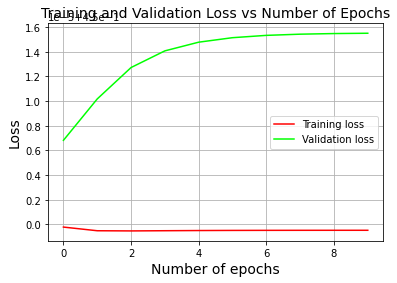

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


training_acc,0.10093
validation_accuracy,0.09167
training_loss,0.45
validation cost,0.45002
epoch,11
_runtime,211
_timestamp,1615429541
_step,9


training_acc,▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▁▁▁▁▁▁▁▁▁
training_loss,█▂▁▂▂▂▂▂▂▂
validation cost,▁▄▆▇▇█████
epoch,▁▂▃▃▄▅▆▆▇█
_runtime,▁▂▃▃▄▅▆▆▇█
_timestamp,▁▂▃▃▄▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: tzu16qi2 with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_f: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	init_mode: xavier
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 3
wandb: 	num_neurons: 128
wandb: 	optimizer: momentum


lr_0.001_ac_tanh_in_xavier_op_momentum_bs_32_L2_0.5_ep_10_nn_128_nh_3
Epoch number : 2
Training cost:  0.40657780239754127 	Validation cost: 0.4255360908875681
Epoch number : 4
Training cost:  0.3316202447817914 	Validation cost: 0.35058477374519115
Epoch number : 6
Training cost:  0.29940699729296116 	Validation cost: 0.31739349473130857
Epoch number : 8
Training cost:  0.2827426051655826 	Validation cost: 0.29955036735162033
Epoch number : 10
Training cost:  0.2730091713763133 	Validation cost: 0.2886570297316318

Final training cost: 0.26964386811727376


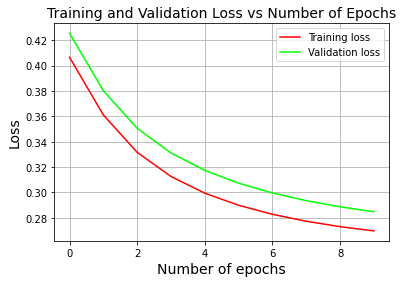

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


training_acc,0.66152
validation_accuracy,0.65383
training_loss,0.26964
validation cost,0.28474
epoch,11
_runtime,152
_timestamp,1615429699
_step,9


training_acc,▁▄▆▇▇█████
validation_accuracy,▁▄▆▇██████
training_loss,█▆▄▃▃▂▂▁▁▁
validation cost,█▆▄▃▃▂▂▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
_runtime,▁▂▃▃▄▅▆▆▇█
_timestamp,▁▂▃▃▄▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: wn1e7z4z with config:
wandb: 	L2_lamb: 0.0005
wandb: 	activation_f: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	init_mode: xavier
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 4
wandb: 	num_neurons: 128
wandb: 	optimizer: sgd


lr_0.001_ac_sigmoid_in_xavier_op_sgd_bs_64_L2_0.0005_ep_5_nn_128_nh_4
Epoch number : 2
Training cost:  0.4598387930105744 	Validation cost: 0.4601252786948745
Epoch number : 4
Training cost:  0.45478392587505 	Validation cost: 0.45504856756734163
Epoch number : 6
Training cost:  0.4530346853088387 	Validation cost: 0.45329304213198884

Final training cost: 0.4530346853088387


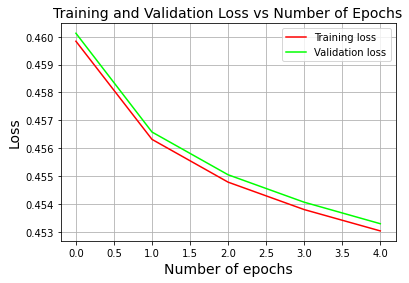

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


training_acc,0.10024
validation_accuracy,0.09783
training_loss,0.45303
validation cost,0.45329
epoch,6
_runtime,70
_timestamp,1615429777
_step,4


training_acc,▁▁▁▁▁
validation_accuracy,▁▁▁▁▁
training_loss,█▄▃▂▁
validation cost,█▄▃▂▁
epoch,▁▃▅▆█
_runtime,▁▃▅▆█
_timestamp,▁▃▅▆█
_step,▁▃▅▆█


wandb: Agent Starting Run: 5mgqpmr5 with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_f: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	init_mode: random_normal
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 5
wandb: 	num_neurons: 32
wandb: 	optimizer: RMSprop


lr_0.001_ac_sigmoid_in_random_normal_op_RMSprop_bs_64_L2_0.5_ep_5_nn_32_nh_5
Epoch number : 2
Training cost:  0.45005432377012233 	Validation cost: 0.45000993194332767
Epoch number : 4
Training cost:  0.45003222622112554 	Validation cost: 0.44999577992321926
Epoch number : 6
Training cost:  0.4500186778091386 	Validation cost: 0.4499921033083235

Final training cost: 0.4500186778091386


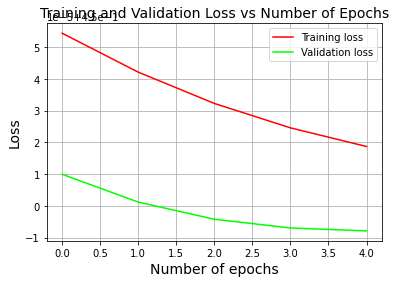

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


training_acc,0.09985
validation_accuracy,0.10133
training_loss,0.45002
validation cost,0.44999
epoch,6
_runtime,29
_timestamp,1615429814
_step,4


training_acc,▁▁▁▁█
validation_accuracy,████▁
training_loss,█▆▄▂▁
validation cost,█▅▂▁▁
epoch,▁▃▅▆█
_runtime,▁▃▄▆█
_timestamp,▁▃▄▆█
_step,▁▃▅▆█


wandb: Agent Starting Run: 8g3kowo3 with config:
wandb: 	L2_lamb: 0.0005
wandb: 	activation_f: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 20
wandb: 	init_mode: xavier
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 3
wandb: 	num_neurons: 64
wandb: 	optimizer: nadam


lr_0.0001_ac_tanh_in_xavier_op_nadam_bs_16_L2_0.0005_ep_20_nn_64_nh_3
Epoch number : 2
Training cost:  0.11819037986784292 	Validation cost: 0.12083704564759237
Epoch number : 4
Training cost:  0.09843663815426955 	Validation cost: 0.1019270774269661
Epoch number : 6
Training cost:  0.09135338744203882 	Validation cost: 0.0961424825293113
Epoch number : 8
Training cost:  0.08660001484526919 	Validation cost: 0.09293036516134492
Epoch number : 10
Training cost:  0.08290823492032084 	Validation cost: 0.09071221106222135
Epoch number : 12
Training cost:  0.07991770245234407 	Validation cost: 0.08912648322941712
Epoch number : 14
Training cost:  0.07741265636281991 	Validation cost: 0.08794656990420759
Epoch number : 16
Training cost:  0.0752472311107211 	Validation cost: 0.08702467809189787
Epoch number : 18
Training cost:  0.07328762723360277 	Validation cost: 0.08626499318681319
Epoch number : 20
Training cost:  0.07143999969666731 	Validation cost: 0.08563306991369642

Final training c

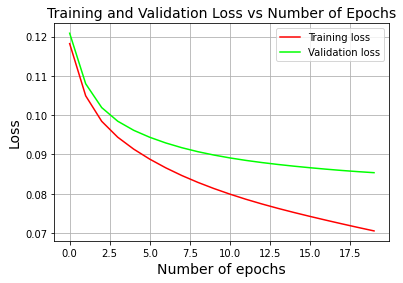

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


training_acc,0.90487
validation_accuracy,0.884
training_loss,0.07056
validation cost,0.08537
epoch,21
_runtime,383
_timestamp,1615430206
_step,19


training_acc,▁▃▄▄▅▅▆▆▆▆▆▇▇▇▇▇████
validation_accuracy,▁▃▄▅▆▆▆▆▆▇▇▇▇▇▇▇▇███
training_loss,█▆▅▅▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁
validation cost,█▅▄▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_runtime,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_timestamp,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Agent Starting Run: gd19yjr0 with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_f: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 40
wandb: 	init_mode: random_uniform
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 3
wandb: 	num_neurons: 128
wandb: 	optimizer: sgd


lr_0.0001_ac_tanh_in_random_uniform_op_sgd_bs_32_L2_0.5_ep_40_nn_128_nh_3
Epoch number : 2
Training cost:  0.4500329079245224 	Validation cost: 0.45020468647988754
Epoch number : 4
Training cost:  0.44997268618347386 	Validation cost: 0.45013778768753093
Epoch number : 6
Training cost:  0.44991766806735 	Validation cost: 0.4500764101143362
Epoch number : 8
Training cost:  0.44986719319925633 	Validation cost: 0.45001987196299387
Epoch number : 10
Training cost:  0.44982070240783506 	Validation cost: 0.44996759451516816
Epoch number : 12
Training cost:  0.44977771979626263 	Validation cost: 0.44991908401031144
Epoch number : 14
Training cost:  0.44973783843951265 	Validation cost: 0.44987391717342307
Epoch number : 16
Training cost:  0.44970070888409425 	Validation cost: 0.4498317295639581
Epoch number : 18
Training cost:  0.4496660298326777 	Validation cost: 0.4497922061263135
Epoch number : 20
Training cost:  0.4496335405468638 	Validation cost: 0.4497550734732686
Epoch number : 22
Tr

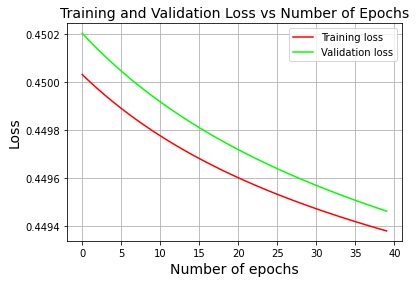

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


training_acc,0.10019
validation_accuracy,0.09833
training_loss,0.44938
validation cost,0.44946
epoch,41
_runtime,526
_timestamp,1615430740
_step,39


training_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
training_loss,██▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁
validation cost,██▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: kyhgw4tr with config:
wandb: 	L2_lamb: 0.0005
wandb: 	activation_f: sigmoid
wandb: 	batch_size: 128
wandb: 	epochs: 10
wandb: 	init_mode: random_normal
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 4
wandb: 	num_neurons: 32
wandb: 	optimizer: nadam


lr_0.001_ac_sigmoid_in_random_normal_op_nadam_bs_128_L2_0.0005_ep_10_nn_32_nh_4
Epoch number : 2
Training cost:  0.4500428012376893 	Validation cost: 0.4499814899361969
Epoch number : 4
Training cost:  0.4500479587055976 	Validation cost: 0.44998761740677035
Epoch number : 6
Training cost:  0.45004889003211085 	Validation cost: 0.44998927471141004
Epoch number : 8
Training cost:  0.4500489922717817 	Validation cost: 0.44998978579508475
Epoch number : 10
Training cost:  0.45004898042719876 	Validation cost: 0.4499899761697932

Final training cost: 0.4500490098696157


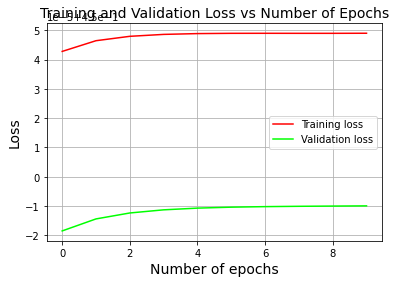

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


training_acc,0.09965
validation_accuracy,0.10317
training_loss,0.45005
validation cost,0.44999
epoch,11
_runtime,42
_timestamp,1615430790
_step,9


training_acc,██▁▁▁▁▁▁▁▁
validation_accuracy,▁▁████████
training_loss,▁▅▇███████
validation cost,▁▄▆▇▇█████
epoch,▁▂▃▃▄▅▆▆▇█
_runtime,▁▂▂▃▄▅▆▆▇█
_timestamp,▁▂▂▃▄▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: h24sslxf with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_f: relu
wandb: 	batch_size: 32
wandb: 	epochs: 40
wandb: 	init_mode: random_uniform
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 4
wandb: 	num_neurons: 64
wandb: 	optimizer: momentum


lr_0.0001_ac_relu_in_random_uniform_op_momentum_bs_32_L2_0.5_ep_40_nn_64_nh_4
Epoch number : 2
Training cost:  0.450017977177385 	Validation cost: 0.45009580052552584
Epoch number : 4
Training cost:  0.4500155743697701 	Validation cost: 0.45009248613446046
Epoch number : 6
Training cost:  0.450013320446545 	Validation cost: 0.4500893390328205
Epoch number : 8
Training cost:  0.4500112075465786 	Validation cost: 0.45008635073546244
Epoch number : 10
Training cost:  0.4500092282198962 	Validation cost: 0.45008351319641743
Epoch number : 12
Training cost:  0.45000737540430885 	Validation cost: 0.45008081878408096
Epoch number : 14
Training cost:  0.4500056424035719 	Validation cost: 0.4500782602580199
Epoch number : 16
Training cost:  0.4500040228669641 	Validation cost: 0.45007583074727253
Epoch number : 18
Training cost:  0.4500025107701665 	Validation cost: 0.4500735237300297
Epoch number : 20
Training cost:  0.45000110039736146 	Validation cost: 0.45007133301459473
Epoch number : 22
T

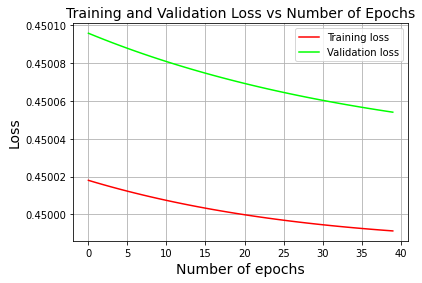

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


training_acc,0.10159
validation_accuracy,0.10083
training_loss,0.44999
validation cost,0.45005
epoch,41
_runtime,254
_timestamp,1615431052
_step,39


training_acc,▁▁▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▆▆▇█
validation_accuracy,▆▆█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▂▂▃▃▄▃▃▂▃▄▅
training_loss,██▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
validation cost,██▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: s43izzsw with config:
wandb: 	L2_lamb: 0.0005
wandb: 	activation_f: tanh
wandb: 	batch_size: 256
wandb: 	epochs: 20
wandb: 	init_mode: random_normal
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 4
wandb: 	num_neurons: 64
wandb: 	optimizer: sgd


lr_0.001_ac_tanh_in_random_normal_op_sgd_bs_256_L2_0.0005_ep_20_nn_64_nh_4
Epoch number : 2
Training cost:  0.44999986650770585 	Validation cost: 0.4500001346630765
Epoch number : 4
Training cost:  0.4499998604483941 	Validation cost: 0.4500001885682221
Epoch number : 6
Training cost:  0.4499998544344158 	Validation cost: 0.45000024229136754
Epoch number : 8
Training cost:  0.449999848465429 	Validation cost: 0.4500002958330201
Epoch number : 10
Training cost:  0.4499998425410934 	Validation cost: 0.45000034919368664
Epoch number : 12
Training cost:  0.4499998366610722 	Validation cost: 0.4500004023738737
Epoch number : 14
Training cost:  0.4499998308250303 	Validation cost: 0.4500004553740868
Epoch number : 16
Training cost:  0.44999982503263547 	Validation cost: 0.45000050819483145
Epoch number : 18
Training cost:  0.4499998192835576 	Validation cost: 0.4500005608366122
Epoch number : 20
Training cost:  0.44999981357747004 	Validation cost: 0.4500006132999335

Final training cost: 0.

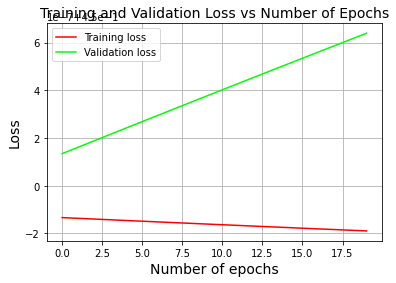

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


training_acc,0.10093
validation_accuracy,0.09167
training_loss,0.45
validation cost,0.45
epoch,21
_runtime,101
_timestamp,1615431162
_step,19


training_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
training_loss,█████▅▅▅▅▅▅▅▅▅▅▁▁▁▁▁
validation cost,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_runtime,▁▁▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇██
_timestamp,▁▁▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Agent Starting Run: t5j2ha10 with config:
wandb: 	L2_lamb: 0
wandb: 	activation_f: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 20
wandb: 	init_mode: random_uniform
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 3
wandb: 	num_neurons: 128
wandb: 	optimizer: momentum


lr_0.0001_ac_sigmoid_in_random_uniform_op_momentum_bs_16_L2_0_ep_20_nn_128_nh_3
Epoch number : 2
Training cost:  0.4500168464299222 	Validation cost: 0.45003926799157673
Epoch number : 4
Training cost:  0.4500093066101273 	Validation cost: 0.45002912889301033
Epoch number : 6
Training cost:  0.4500049934531773 	Validation cost: 0.45002288510637556
Epoch number : 8
Training cost:  0.4500025308984528 	Validation cost: 0.4500189841379571
Epoch number : 10
Training cost:  0.4500011269721157 	Validation cost: 0.4500165060379161
Epoch number : 12
Training cost:  0.4500003272678228 	Validation cost: 0.45001490276862127
Epoch number : 14
Training cost:  0.44999987177108436 	Validation cost: 0.45001384535700034
Epoch number : 16
Training cost:  0.44999961204070105 	Validation cost: 0.4500131343162264
Epoch number : 18
Training cost:  0.44999946349339504 	Validation cost: 0.45001264713068706
Epoch number : 20
Training cost:  0.44999937800906037 	Validation cost: 0.45001230740955966

Final traini

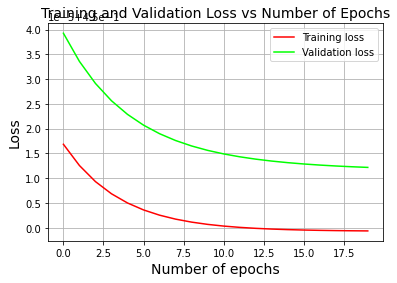

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


training_acc,0.10093
validation_accuracy,0.09167
training_loss,0.45
validation cost,0.45001
epoch,21
_runtime,426
_timestamp,1615431597
_step,19


training_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁████
validation_accuracy,████████████████▁▁▁▁
training_loss,█▆▅▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁
validation cost,█▇▅▄▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_runtime,▁▁▂▂▃▃▃▄▄▄▅▅▅▆▆▇▇▇██
_timestamp,▁▁▂▂▃▃▃▄▄▄▅▅▅▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Agent Starting Run: 2lrh21rx with config:
wandb: 	L2_lamb: 0
wandb: 	activation_f: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	init_mode: random_uniform
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 3
wandb: 	num_neurons: 64
wandb: 	optimizer: adam


lr_0.001_ac_relu_in_random_uniform_op_adam_bs_16_L2_0_ep_10_nn_64_nh_3
Epoch number : 2
Training cost:  nan 	Validation cost: nan
Epoch number : 4
Training cost:  nan 	Validation cost: nan
Epoch number : 6
Training cost:  nan 	Validation cost: nan
Epoch number : 8
Training cost:  nan 	Validation cost: nan
Epoch number : 10
Training cost:  nan 	Validation cost: nan

Final training cost: nan


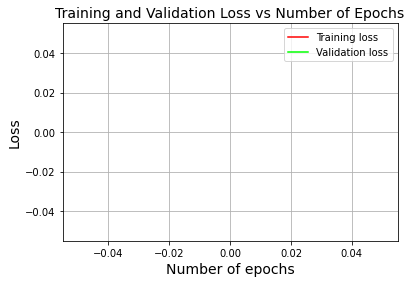

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


training_acc,0.10006
validation_accuracy,0.0995
training_loss,nan
validation cost,nan
epoch,11
_runtime,153
_timestamp,1615431759
_step,9


training_acc,▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▁▁▁▁▁▁▁▁▁
training_loss,
validation cost,
epoch,▁▂▃▃▄▅▆▆▇█
_runtime,▁▂▃▃▄▅▆▆▇█
_timestamp,▁▂▃▃▄▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: t4e0yywb with config:
wandb: 	L2_lamb: 0
wandb: 	activation_f: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	init_mode: xavier
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 5
wandb: 	num_neurons: 64
wandb: 	optimizer: sgd


lr_0.0001_ac_tanh_in_xavier_op_sgd_bs_64_L2_0_ep_5_nn_64_nh_5
Epoch number : 2
Training cost:  0.4488029091002186 	Validation cost: 0.44915918334286986
Epoch number : 4
Training cost:  0.4461739842780139 	Validation cost: 0.44657713866584353
Epoch number : 6
Training cost:  0.44355639538740216 	Validation cost: 0.44401591856027806

Final training cost: 0.44355639538740216


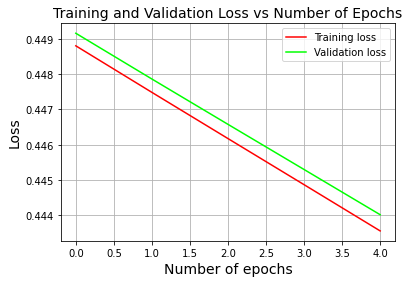

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


training_acc,0.24357
validation_accuracy,0.23833
training_loss,0.44356
validation cost,0.44402
epoch,6
_runtime,43
_timestamp,1615431812
_step,4


training_acc,▁▃▅▆█
validation_accuracy,▁▃▅▆█
training_loss,█▆▄▃▁
validation cost,█▆▄▃▁
epoch,▁▃▅▆█
_runtime,▁▃▅▆█
_timestamp,▁▃▅▆█
_step,▁▃▅▆█


wandb: Agent Starting Run: ip5f6bqo with config:
wandb: 	L2_lamb: 0.0005
wandb: 	activation_f: sigmoid
wandb: 	batch_size: 256
wandb: 	epochs: 10
wandb: 	init_mode: xavier
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 4
wandb: 	num_neurons: 32
wandb: 	optimizer: RMSprop


lr_0.001_ac_sigmoid_in_xavier_op_RMSprop_bs_256_L2_0.0005_ep_10_nn_32_nh_4
Epoch number : 2
Training cost:  0.39908963576068535 	Validation cost: 0.39994297481424945
Epoch number : 4
Training cost:  0.2899569687832255 	Validation cost: 0.29306983451663887
Epoch number : 6
Training cost:  0.21242875510845868 	Validation cost: 0.21750921195165593
Epoch number : 8
Training cost:  0.1813001417043998 	Validation cost: 0.18931252945417656
Epoch number : 10
Training cost:  0.16767245258421534 	Validation cost: 0.17704558138376164

Final training cost: 0.16371468349967772


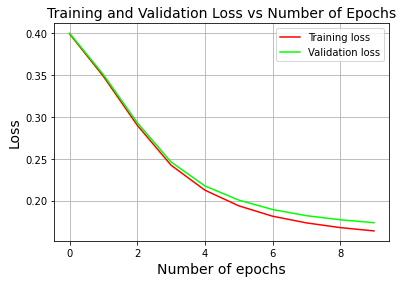

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


training_acc,0.7652
validation_accuracy,0.74767
training_loss,0.16371
validation cost,0.17355
epoch,11
_runtime,37
_timestamp,1615431859
_step,9


training_acc,▁▃▆▇▇▇▇███
validation_accuracy,▁▃▆▇▇▇▇███
training_loss,█▆▅▃▂▂▂▁▁▁
validation cost,█▆▅▃▂▂▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
_runtime,▁▂▂▃▄▅▆▆▇█
_timestamp,▁▂▂▃▄▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: 08q5nzli with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_f: relu
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	init_mode: random_normal
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 4
wandb: 	num_neurons: 32
wandb: 	optimizer: adam


lr_0.0001_ac_relu_in_random_normal_op_adam_bs_32_L2_0.5_ep_20_nn_32_nh_4
Epoch number : 2
Training cost:  0.4499997051990724 	Validation cost: 0.45000555028246736
Epoch number : 4
Training cost:  0.4499994584458494 	Validation cost: 0.450012531408207
Epoch number : 6
Training cost:  0.44999949445595333 	Validation cost: 0.4500147278817704
Epoch number : 8
Training cost:  0.4499995111636756 	Validation cost: 0.4500153165470065
Epoch number : 10
Training cost:  0.44999951626653034 	Validation cost: 0.45001547271959247
Epoch number : 12
Training cost:  0.4499995177117746 	Validation cost: 0.45001551408545554
Epoch number : 14
Training cost:  0.449999518113866 	Validation cost: 0.45001552504483705
Epoch number : 16
Training cost:  0.449999518225261 	Validation cost: 0.4500155279505177
Epoch number : 18
Training cost:  0.44999951825609746 	Validation cost: 0.45001552872158485
Epoch number : 20
Training cost:  0.4499995182646346 	Validation cost: 0.45001552892639296

Final training cost: 0.4

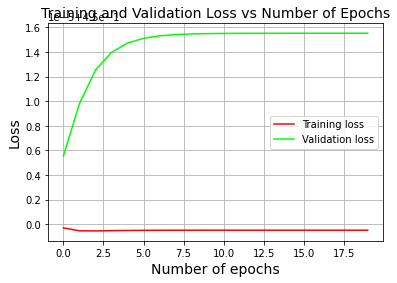

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


training_acc,0.10093
validation_accuracy,0.09167
training_loss,0.45
validation cost,0.45002
epoch,21
_runtime,97
_timestamp,1615431965
_step,19


training_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
training_loss,█▂▁▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
validation cost,▁▄▆▇▇███████████████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_runtime,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_timestamp,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Agent Starting Run: mk1z85rp with config:
wandb: 	L2_lamb: 0
wandb: 	activation_f: tanh
wandb: 	batch_size: 128
wandb: 	epochs: 5
wandb: 	init_mode: random_uniform
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 5
wandb: 	num_neurons: 32
wandb: 	optimizer: RMSprop


lr_0.001_ac_tanh_in_random_uniform_op_RMSprop_bs_128_L2_0_ep_5_nn_32_nh_5
Epoch number : 2
Training cost:  0.3518592988243004 	Validation cost: 0.35286490236698415
Epoch number : 4
Training cost:  0.28268568808077454 	Validation cost: 0.28418157388884285
Epoch number : 6
Training cost:  0.3313169097662052 	Validation cost: 0.3339717328198834

Final training cost: 0.3313169097662052


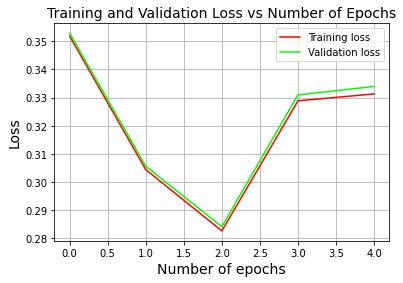

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


training_acc,0.51544
validation_accuracy,0.50867
training_loss,0.33132
validation cost,0.33397
epoch,6
_runtime,25
_timestamp,1615431999
_step,4


training_acc,▁▅█▆▇
validation_accuracy,▁▅█▅▆
training_loss,█▃▁▆▆
validation cost,█▃▁▆▆
epoch,▁▃▅▆█
_runtime,▁▃▄▆█
_timestamp,▁▃▄▆█
_step,▁▃▅▆█


wandb: Agent Starting Run: 4s8p3syg with config:
wandb: 	L2_lamb: 0.0005
wandb: 	activation_f: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 20
wandb: 	init_mode: xavier
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 5
wandb: 	num_neurons: 64
wandb: 	optimizer: adam


lr_0.001_ac_tanh_in_xavier_op_adam_bs_16_L2_0.0005_ep_20_nn_64_nh_5
Epoch number : 2
Training cost:  0.15872792884726455 	Validation cost: 0.1622650174317864
Epoch number : 4
Training cost:  0.11495660599840034 	Validation cost: 0.11862966409771329
Epoch number : 6
Training cost:  0.11503835667215541 	Validation cost: 0.12114307794977873
Epoch number : 8
Training cost:  0.11226769635078757 	Validation cost: 0.11783736400346378
Epoch number : 10
Training cost:  0.1378139228096592 	Validation cost: 0.14156479424917762
Epoch number : 12
Training cost:  0.16061539962217813 	Validation cost: 0.1667248417096587
Epoch number : 14
Training cost:  0.16327704919273275 	Validation cost: 0.16913009205919274
Epoch number : 16
Training cost:  0.18099145392918575 	Validation cost: 0.1844714481630682
Epoch number : 18
Training cost:  0.2021739890469829 	Validation cost: 0.20981561814445276
Epoch number : 20
Training cost:  0.17758990737275915 	Validation cost: 0.18385531416523115

Final training cost:

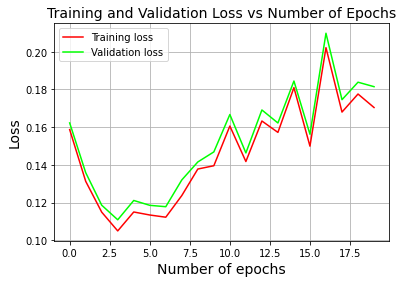

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


training_acc,0.75454
validation_accuracy,0.7365
training_loss,0.17043
validation cost,0.18148
epoch,21
_runtime,436
_timestamp,1615432444
_step,19


training_acc,▄▆▇█▇▇▇▇▆▆▅▆▄▄▄▆▁▄▃▃
validation_accuracy,▅▇██▇▇▇▇▆▆▅▆▄▅▄▆▁▄▃▃
training_loss,▅▃▂▁▂▂▂▂▃▃▅▄▅▅▆▄█▆▆▆
validation cost,▅▃▂▁▂▂▁▂▃▄▅▄▅▅▆▄█▆▆▆
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_runtime,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_timestamp,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Agent Starting Run: dd46h65h with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_f: relu
wandb: 	batch_size: 16
wandb: 	epochs: 40
wandb: 	init_mode: xavier
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 3
wandb: 	num_neurons: 64
wandb: 	optimizer: RMSprop


lr_0.0001_ac_relu_in_xavier_op_RMSprop_bs_16_L2_0.5_ep_40_nn_64_nh_3
Epoch number : 2
Training cost:  0.33179456254189416 	Validation cost: 0.3385537032672761
Epoch number : 4
Training cost:  nan 	Validation cost: nan
Epoch number : 6
Training cost:  nan 	Validation cost: nan
Epoch number : 8
Training cost:  nan 	Validation cost: nan
Epoch number : 10
Training cost:  nan 	Validation cost: nan
Epoch number : 12
Training cost:  nan 	Validation cost: nan
Epoch number : 14
Training cost:  nan 	Validation cost: nan
Epoch number : 16
Training cost:  nan 	Validation cost: nan
Epoch number : 18
Training cost:  nan 	Validation cost: nan
Epoch number : 20
Training cost:  nan 	Validation cost: nan
Epoch number : 22
Training cost:  nan 	Validation cost: nan
Epoch number : 24
Training cost:  nan 	Validation cost: nan
Epoch number : 26
Training cost:  nan 	Validation cost: nan
Epoch number : 28
Training cost:  nan 	Validation cost: nan
Epoch number : 30
Training cost:  nan 	Validation cost: nan
Epoc

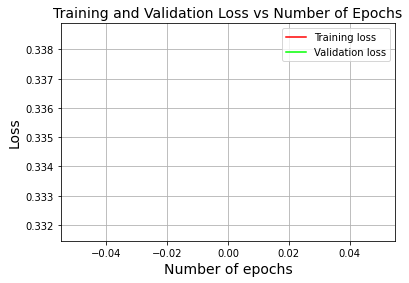

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


training_acc,0.10006
validation_accuracy,0.0995
training_loss,nan
validation cost,nan
epoch,41
_runtime,428
_timestamp,1615432882
_step,39


training_acc,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_accuracy,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
training_loss,▁
validation cost,▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: j448vlic with config:
wandb: 	L2_lamb: 0.0005
wandb: 	activation_f: relu
wandb: 	batch_size: 512
wandb: 	epochs: 10
wandb: 	init_mode: random_normal
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 3
wandb: 	num_neurons: 32
wandb: 	optimizer: RMSprop


lr_0.0001_ac_relu_in_random_normal_op_RMSprop_bs_512_L2_0.0005_ep_10_nn_32_nh_3
Epoch number : 2
Training cost:  0.4498602487449369 	Validation cost: 0.44986093996696774
Epoch number : 4
Training cost:  0.42650306617406775 	Validation cost: 0.4264055319991616
Epoch number : 6
Training cost:  0.3745647691213619 	Validation cost: 0.3755063453042159
Epoch number : 8
Training cost:  0.33542467323380554 	Validation cost: 0.3370002914543872
Epoch number : 10
Training cost:  0.302623329173454 	Validation cost: 0.3051683271218263

Final training cost: 0.28904727252081763


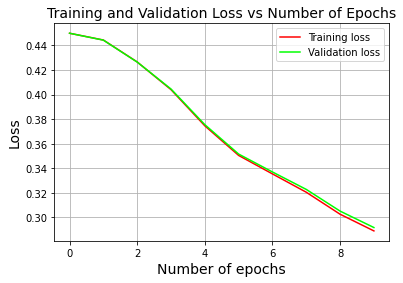

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


training_acc,0.49391
validation_accuracy,0.48383
training_loss,0.28905
validation cost,0.29179
epoch,11
_runtime,19
_timestamp,1615432910
_step,9


training_acc,▁▁▂▃▄▄▅▇██
validation_accuracy,▁▁▂▃▅▅▅▇██
training_loss,██▇▆▅▄▃▂▂▁
validation cost,██▇▆▅▄▃▂▂▁
epoch,▁▂▃▃▄▅▆▆▇█
_runtime,▁▁▃▃▄▅▅▇▇█
_timestamp,▁▁▃▃▄▅▅▇▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: brzimyd9 with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_f: tanh
wandb: 	batch_size: 512
wandb: 	epochs: 5
wandb: 	init_mode: random_uniform
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 5
wandb: 	num_neurons: 128
wandb: 	optimizer: nestorov


lr_0.001_ac_tanh_in_random_uniform_op_nestorov_bs_512_L2_0.5_ep_5_nn_128_nh_5
Epoch number : 2
Training cost:  0.45000442205503877 	Validation cost: 0.45020393268767706
Epoch number : 4
Training cost:  0.45000442205503877 	Validation cost: 0.45020393268767706
Epoch number : 6
Training cost:  0.45000442205503877 	Validation cost: 0.45020393268767706

Final training cost: 0.45000442205503877


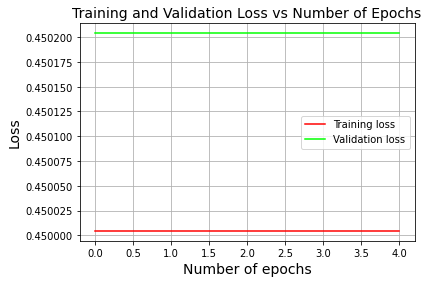

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


training_acc,0.09965
validation_accuracy,0.10317
training_loss,0.45
validation cost,0.4502
epoch,6
_runtime,59
_timestamp,1615432978
_step,4


training_acc,▁▁▁▁▁
validation_accuracy,▁▁▁▁▁
training_loss,▁▁▁▁▁
validation cost,▁▁▁▁▁
epoch,▁▃▅▆█
_runtime,▁▃▅▆█
_timestamp,▁▃▅▆█
_step,▁▃▅▆█


wandb: Agent Starting Run: 8ngnerso with config:
wandb: 	L2_lamb: 0.0005
wandb: 	activation_f: tanh
wandb: 	batch_size: 512
wandb: 	epochs: 40
wandb: 	init_mode: random_uniform
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 3
wandb: 	num_neurons: 64
wandb: 	optimizer: adam


lr_0.001_ac_tanh_in_random_uniform_op_adam_bs_512_L2_0.0005_ep_40_nn_64_nh_3
Epoch number : 2
Training cost:  0.44864465443036244 	Validation cost: 0.4485394421506724
Epoch number : 4
Training cost:  0.3921140816828629 	Validation cost: 0.3932659019821598
Epoch number : 6
Training cost:  0.3757710866303917 	Validation cost: 0.37745499552224643
Epoch number : 8
Training cost:  0.31380036262548716 	Validation cost: 0.3161048437720806
Epoch number : 10
Training cost:  0.2701579289231052 	Validation cost: 0.273429515710433
Epoch number : 12
Training cost:  0.42143530913238164 	Validation cost: 0.42276787733420984
Epoch number : 14
Training cost:  0.3576749957948502 	Validation cost: 0.3612921619407543
Epoch number : 16
Training cost:  0.3704636853831342 	Validation cost: 0.37190156064536006
Epoch number : 18
Training cost:  0.3178500428522191 	Validation cost: 0.31947072964845663
Epoch number : 20
Training cost:  0.23082202205935054 	Validation cost: 0.23391627289224298
Epoch number : 22
T

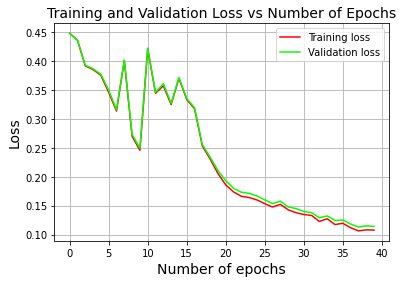

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


training_acc,0.84856
validation_accuracy,0.83867
training_loss,0.10771
validation cost,0.114
epoch,41
_runtime,200
_timestamp,1615433187
_step,39


training_acc,▁▂▂▂▃▄▅▃▆▆▃▄▃▄▃▄▄▆▆▆▇▇▇▇▇▇▇▇▇▇▇█████████
validation_accuracy,▁▂▂▂▃▄▅▃▆▆▃▄▃▄▃▄▄▆▆▆▇▇▇▇▇▇▇▇▇▇▇█████████
training_loss,██▇▇▇▆▅▇▄▄▇▆▆▅▆▆▅▄▄▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
validation cost,██▇▇▇▆▅▇▄▄▇▆▆▅▆▆▅▄▄▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: sp9qilyc with config:
wandb: 	L2_lamb: 0
wandb: 	activation_f: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 20
wandb: 	init_mode: xavier
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 3
wandb: 	num_neurons: 128
wandb: 	optimizer: sgd


lr_0.001_ac_sigmoid_in_xavier_op_sgd_bs_16_L2_0_ep_20_nn_128_nh_3
Epoch number : 2
Training cost:  0.4530341820833782 	Validation cost: 0.4531817204090834
Epoch number : 4
Training cost:  0.4500488149727028 	Validation cost: 0.45009398078176355
Epoch number : 6
Training cost:  0.44983627774024093 	Validation cost: 0.44985880474919226
Epoch number : 8
Training cost:  0.4497493362914501 	Validation cost: 0.44977051707880633
Epoch number : 10
Training cost:  0.4496634450131852 	Validation cost: 0.4496861252729483
Epoch number : 12
Training cost:  0.44957678889607644 	Validation cost: 0.4496013073314595
Epoch number : 14
Training cost:  0.4494892057152205 	Validation cost: 0.4495156230262691
Epoch number : 16
Training cost:  0.44940053814770525 	Validation cost: 0.44942888755982807
Epoch number : 18
Training cost:  0.4493106216394328 	Validation cost: 0.4493409365704884
Epoch number : 20
Training cost:  0.44921928457682614 	Validation cost: 0.4492516018556835

Final training cost: 0.449173

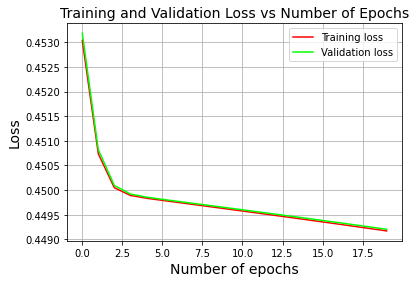

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


training_acc,0.32998
validation_accuracy,0.32033
training_loss,0.44917
validation cost,0.44921
epoch,21
_runtime,357
_timestamp,1615433553
_step,19


training_acc,▁▃▄▄▅▅▆▆▆▇▇▇▇▇▇█████
validation_accuracy,▁▃▄▄▅▅▆▆▆▇▇▇▇▇██████
training_loss,█▄▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
validation cost,█▄▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_runtime,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_timestamp,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Agent Starting Run: bydj6pdn with config:
wandb: 	L2_lamb: 0
wandb: 	activation_f: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	init_mode: xavier
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 3
wandb: 	num_neurons: 32
wandb: 	optimizer: nestorov


lr_0.001_ac_sigmoid_in_xavier_op_nestorov_bs_64_L2_0_ep_10_nn_32_nh_3
Epoch number : 2
Training cost:  0.467491753407207 	Validation cost: 0.46733174076005374
Epoch number : 4
Training cost:  0.467491753407207 	Validation cost: 0.46733174076005374
Epoch number : 6
Training cost:  0.467491753407207 	Validation cost: 0.46733174076005374
Epoch number : 8
Training cost:  0.467491753407207 	Validation cost: 0.46733174076005374
Epoch number : 10
Training cost:  0.467491753407207 	Validation cost: 0.46733174076005374

Final training cost: 0.467491753407207


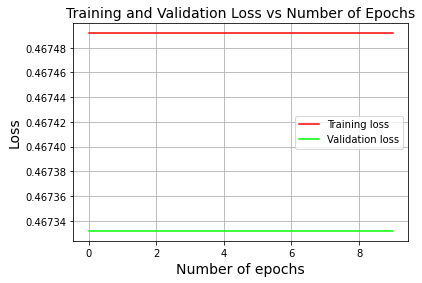

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


training_acc,0.0995
validation_accuracy,0.1045
training_loss,0.46749
validation cost,0.46733
epoch,11
_runtime,35
_timestamp,1615433597
_step,9


training_acc,▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▁▁▁▁▁▁▁▁▁
training_loss,▁▁▁▁▁▁▁▁▁▁
validation cost,▁▁▁▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
_runtime,▁▂▃▃▄▅▆▇▇█
_timestamp,▁▂▃▃▄▅▆▇▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: mjy11zt1 with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_f: tanh
wandb: 	batch_size: 256
wandb: 	epochs: 40
wandb: 	init_mode: xavier
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 4
wandb: 	num_neurons: 32
wandb: 	optimizer: momentum


lr_0.0001_ac_tanh_in_xavier_op_momentum_bs_256_L2_0.5_ep_40_nn_32_nh_4
Epoch number : 2
Training cost:  0.46333658768818203 	Validation cost: 0.46945385201094875
Epoch number : 4
Training cost:  0.4627875086590821 	Validation cost: 0.4688978007393989
Epoch number : 6
Training cost:  0.4622545524379562 	Validation cost: 0.46835815632867606
Epoch number : 8
Training cost:  0.46173585798007166 	Validation cost: 0.4678330625406597
Epoch number : 10
Training cost:  0.46122974695893454 	Validation cost: 0.46732084178820266
Epoch number : 12
Training cost:  0.46073471483509115 	Validation cost: 0.46681998704309324
Epoch number : 14
Training cost:  0.46024941834138705 	Validation cost: 0.46632915005688547
Epoch number : 16
Training cost:  0.4597726610871737 	Validation cost: 0.4658471275937556
Epoch number : 18
Training cost:  0.4593033785003033 	Validation cost: 0.4653728468980934
Epoch number : 20
Training cost:  0.4588406229378068 	Validation cost: 0.4649053512359431
Epoch number : 22
Train

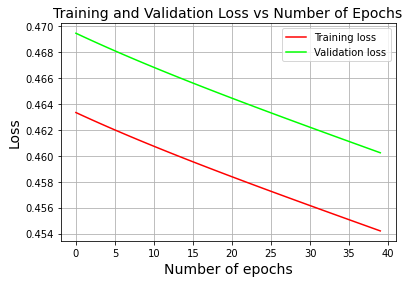

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


training_acc,0.09067
validation_accuracy,0.08683
training_loss,0.45421
validation cost,0.46023
epoch,41
_runtime,130
_timestamp,1615433737
_step,39


training_acc,▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇███
validation_accuracy,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇██
training_loss,███▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
validation cost,███▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: rfiizx9h with config:
wandb: 	L2_lamb: 0
wandb: 	activation_f: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 20
wandb: 	init_mode: xavier
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 4
wandb: 	num_neurons: 128
wandb: 	optimizer: nestorov


lr_0.001_ac_tanh_in_xavier_op_nestorov_bs_64_L2_0_ep_20_nn_128_nh_4
Epoch number : 2
Training cost:  0.45217892389851194 	Validation cost: 0.4525663186081696
Epoch number : 4
Training cost:  0.45217892389851194 	Validation cost: 0.4525663186081696
Epoch number : 6
Training cost:  0.45217892389851194 	Validation cost: 0.4525663186081696
Epoch number : 8
Training cost:  0.45217892389851194 	Validation cost: 0.4525663186081696
Epoch number : 10
Training cost:  0.45217892389851194 	Validation cost: 0.4525663186081696
Epoch number : 12
Training cost:  0.45217892389851194 	Validation cost: 0.4525663186081696
Epoch number : 14
Training cost:  0.45217892389851194 	Validation cost: 0.4525663186081696
Epoch number : 16
Training cost:  0.45217892389851194 	Validation cost: 0.4525663186081696
Epoch number : 18
Training cost:  0.45217892389851194 	Validation cost: 0.4525663186081696
Epoch number : 20
Training cost:  0.45217892389851194 	Validation cost: 0.4525663186081696

Final training cost: 0.45

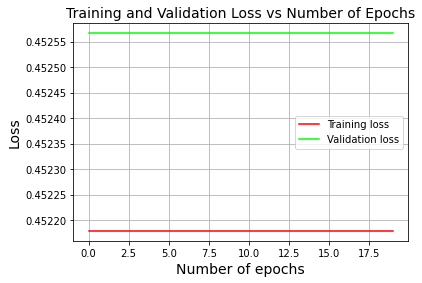

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


training_acc,0.1287
validation_accuracy,0.12783
training_loss,0.45218
validation cost,0.45257
epoch,21
_runtime,250
_timestamp,1615433997
_step,19


training_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
training_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation cost,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_runtime,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_timestamp,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Agent Starting Run: 1e7jqzqb with config:
wandb: 	L2_lamb: 0.0005
wandb: 	activation_f: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	init_mode: xavier
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 5
wandb: 	num_neurons: 64
wandb: 	optimizer: momentum


lr_0.0001_ac_sigmoid_in_xavier_op_momentum_bs_16_L2_0.0005_ep_5_nn_64_nh_5
Epoch number : 2
Training cost:  0.4692090166239126 	Validation cost: 0.46954924975841195
Epoch number : 4
Training cost:  0.4625348126686831 	Validation cost: 0.46298330973207386
Epoch number : 6
Training cost:  0.458997491522829 	Validation cost: 0.45948705782085697

Final training cost: 0.458997491522829


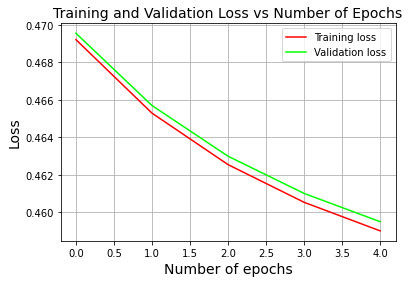

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


training_acc,0.09965
validation_accuracy,0.10317
training_loss,0.459
validation cost,0.45949
epoch,6
_runtime,79
_timestamp,1615434085
_step,4


training_acc,▁▁▁▁▁
validation_accuracy,▁▁▁▁▁
training_loss,█▅▃▂▁
validation cost,█▅▃▂▁
epoch,▁▃▅▆█
_runtime,▁▃▄▆█
_timestamp,▁▃▄▆█
_step,▁▃▅▆█


wandb: Agent Starting Run: z61e8m8c with config:
wandb: 	L2_lamb: 0
wandb: 	activation_f: sigmoid
wandb: 	batch_size: 256
wandb: 	epochs: 40
wandb: 	init_mode: xavier
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 4
wandb: 	num_neurons: 64
wandb: 	optimizer: sgd


lr_0.001_ac_sigmoid_in_xavier_op_sgd_bs_256_L2_0_ep_40_nn_64_nh_4
Epoch number : 2
Training cost:  0.4612963959247722 	Validation cost: 0.46143233035773423
Epoch number : 4
Training cost:  0.45784532125417177 	Validation cost: 0.45807071696453394
Epoch number : 6
Training cost:  0.4558530750110157 	Validation cost: 0.4561252913354068
Epoch number : 8
Training cost:  0.4545654621952126 	Validation cost: 0.45486110784799483
Epoch number : 10
Training cost:  0.45366741670157396 	Validation cost: 0.45397274840480417
Epoch number : 12
Training cost:  0.4530066194226535 	Validation cost: 0.453313209158972
Epoch number : 14
Training cost:  0.4525010247616088 	Validation cost: 0.4528035792449154
Epoch number : 16
Training cost:  0.45210265276187334 	Validation cost: 0.4523978215475215
Epoch number : 18
Training cost:  0.4517815859864986 	Validation cost: 0.45206726759753396
Epoch number : 20
Training cost:  0.45151818951443784 	Validation cost: 0.4517931073580559
Epoch number : 22
Training cos

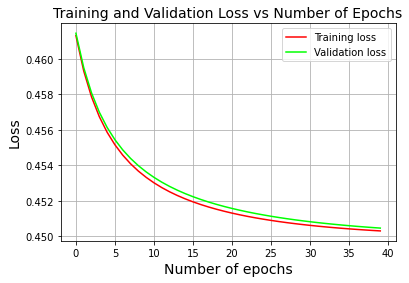

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


training_acc,0.09965
validation_accuracy,0.10317
training_loss,0.4503
validation cost,0.45046
epoch,41
_runtime,237
_timestamp,1615434331
_step,39


training_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
training_loss,█▇▆▅▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation cost,█▇▆▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 27rbqddh with config:
wandb: 	L2_lamb: 0.0005
wandb: 	activation_f: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 20
wandb: 	init_mode: random_uniform
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 4
wandb: 	num_neurons: 128
wandb: 	optimizer: momentum


lr_0.001_ac_tanh_in_random_uniform_op_momentum_bs_16_L2_0.0005_ep_20_nn_128_nh_4
Epoch number : 2
Training cost:  0.44978218294508754 	Validation cost: 0.44976167834635855
Epoch number : 4
Training cost:  0.4494852378619122 	Validation cost: 0.4494368292055517
Epoch number : 6
Training cost:  0.4492829135828769 	Validation cost: 0.4492125373102047
Epoch number : 8
Training cost:  0.44912656370217613 	Validation cost: 0.4490387898922109
Epoch number : 10
Training cost:  0.4489918965107069 	Validation cost: 0.4488902748170211
Epoch number : 12
Training cost:  0.4488656290305113 	Validation cost: 0.4487528526954829
Epoch number : 14
Training cost:  0.4487401594911046 	Validation cost: 0.4486181938131548
Epoch number : 16
Training cost:  0.4486109401456831 	Validation cost: 0.44848114939933903
Epoch number : 18
Training cost:  0.4484750271653037 	Validation cost: 0.44833829761670907
Epoch number : 20
Training cost:  0.4483302460556622 	Validation cost: 0.44818709631713316

Final training c

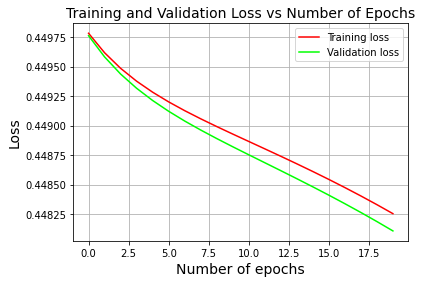

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


training_acc,0.10374
validation_accuracy,0.1105
training_loss,0.44825
validation cost,0.44811
epoch,21
_runtime,485
_timestamp,1615434825
_step,19


training_acc,▂▂▁▁▁▁▁▁▁▁▁▁▁▂▂▂▃▄▆█
validation_accuracy,▁▁▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆▇█
training_loss,█▇▇▆▆▅▅▅▄▄▄▄▃▃▃▂▂▂▁▁
validation cost,█▇▇▆▆▅▅▅▄▄▄▃▃▃▃▂▂▂▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_runtime,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_timestamp,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Agent Starting Run: x2ndqnye with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_f: tanh
wandb: 	batch_size: 128
wandb: 	epochs: 5
wandb: 	init_mode: xavier
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 3
wandb: 	num_neurons: 128
wandb: 	optimizer: sgd


lr_0.0001_ac_tanh_in_xavier_op_sgd_bs_128_L2_0.5_ep_5_nn_128_nh_3
Epoch number : 2
Training cost:  0.46240918368651024 	Validation cost: 0.4818706537346622
Epoch number : 4
Training cost:  0.4574502184210318 	Validation cost: 0.47680051954517844
Epoch number : 6
Training cost:  0.4535335856525365 	Validation cost: 0.4728172241172792

Final training cost: 0.4535335856525365


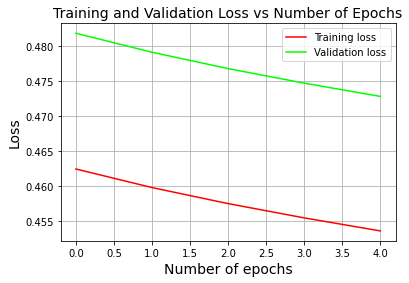

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


training_acc,0.14426
validation_accuracy,0.14
training_loss,0.45353
validation cost,0.47282
epoch,6
_runtime,50
_timestamp,1615434884
_step,4


training_acc,▁▂▄▆█
validation_accuracy,▁▃▄▆█
training_loss,█▆▄▂▁
validation cost,█▆▄▂▁
epoch,▁▃▅▆█
_runtime,▁▃▄▆█
_timestamp,▁▃▄▆█
_step,▁▃▅▆█


wandb: Agent Starting Run: rfmrf2pb with config:
wandb: 	L2_lamb: 0
wandb: 	activation_f: relu
wandb: 	batch_size: 512
wandb: 	epochs: 10
wandb: 	init_mode: random_uniform
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 3
wandb: 	num_neurons: 128
wandb: 	optimizer: RMSprop


lr_0.001_ac_relu_in_random_uniform_op_RMSprop_bs_512_L2_0_ep_10_nn_128_nh_3
Epoch number : 2
Training cost:  0.41936518887364116 	Validation cost: 0.4190839731094324
Epoch number : 4
Training cost:  0.3681037090047372 	Validation cost: 0.3692585299398502
Epoch number : 6
Training cost:  0.26022278790364006 	Validation cost: 0.2625780899771382
Epoch number : 8
Training cost:  0.2111537639709656 	Validation cost: 0.21374463167879368
Epoch number : 10
Training cost:  0.14792267565520748 	Validation cost: 0.15582116135396704

Final training cost: 0.13519483995132803


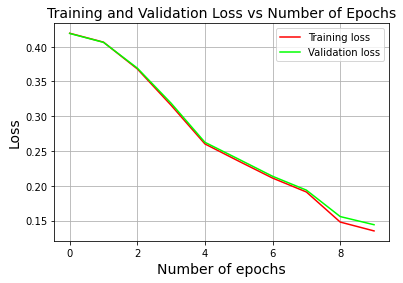

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


training_acc,0.80976
validation_accuracy,0.801
training_loss,0.13519
validation cost,0.14411
epoch,11
_runtime,53
_timestamp,1615434950
_step,9


training_acc,▁▁▂▄▅▆▇▇██
validation_accuracy,▁▁▂▃▅▆▇▇██
training_loss,██▇▅▄▃▃▂▁▁
validation cost,██▇▅▄▃▃▂▁▁
epoch,▁▂▃▃▄▅▆▆▇█
_runtime,▁▂▃▃▄▅▆▆▇█
_timestamp,▁▂▃▃▄▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: 38mxpxiz with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_f: sigmoid
wandb: 	batch_size: 512
wandb: 	epochs: 20
wandb: 	init_mode: random_normal
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 5
wandb: 	num_neurons: 128
wandb: 	optimizer: nestorov


lr_0.0001_ac_sigmoid_in_random_normal_op_nestorov_bs_512_L2_0.5_ep_20_nn_128_nh_5
Epoch number : 2
Training cost:  0.45027675362470393 	Validation cost: 0.45090552417346114
Epoch number : 4
Training cost:  0.45027675362470393 	Validation cost: 0.45090552417346114
Epoch number : 6
Training cost:  0.45027675362470393 	Validation cost: 0.45090552417346114
Epoch number : 8
Training cost:  0.45027675362470393 	Validation cost: 0.45090552417346114
Epoch number : 10
Training cost:  0.45027675362470393 	Validation cost: 0.45090552417346114
Epoch number : 12
Training cost:  0.45027675362470393 	Validation cost: 0.45090552417346114
Epoch number : 14
Training cost:  0.45027675362470393 	Validation cost: 0.45090552417346114
Epoch number : 16
Training cost:  0.45027675362470393 	Validation cost: 0.45090552417346114
Epoch number : 18
Training cost:  0.45027675362470393 	Validation cost: 0.45090552417346114
Epoch number : 20
Training cost:  0.45027675362470393 	Validation cost: 0.45090552417346114

F

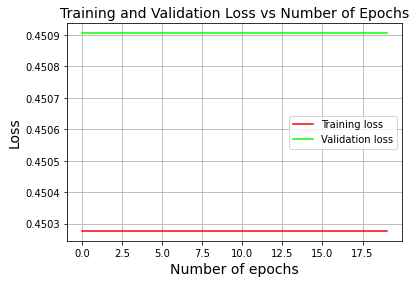

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


training_acc,0.10093
validation_accuracy,0.09167
training_loss,0.45028
validation cost,0.45091
epoch,21
_runtime,247
_timestamp,1615435206
_step,19


training_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
training_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation cost,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_runtime,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_timestamp,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Agent Starting Run: npk0uqny with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_f: sigmoid
wandb: 	batch_size: 128
wandb: 	epochs: 10
wandb: 	init_mode: random_uniform
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 3
wandb: 	num_neurons: 64
wandb: 	optimizer: nadam


lr_0.0001_ac_sigmoid_in_random_uniform_op_nadam_bs_128_L2_0.5_ep_10_nn_64_nh_3
Epoch number : 2
Training cost:  0.45001079525867793 	Validation cost: 0.4500473758197325
Epoch number : 4
Training cost:  0.45000811254498935 	Validation cost: 0.4500202215176598
Epoch number : 6
Training cost:  0.4500064526139982 	Validation cost: 0.4500062846957071
Epoch number : 8
Training cost:  0.45000553102136476 	Validation cost: 0.449999169613603
Epoch number : 10
Training cost:  0.4500050231934007 	Validation cost: 0.44999555811972236

Final training cost: 0.4500048618086536


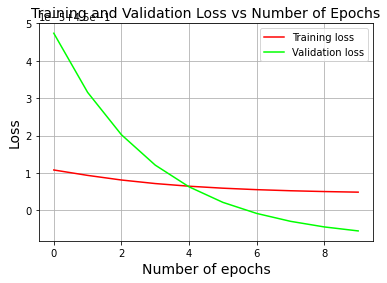

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


training_acc,0.09961
validation_accuracy,0.1035
training_loss,0.45
validation cost,0.44999
epoch,11
_runtime,67
_timestamp,1615435284
_step,9


training_acc,▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▁▁▁▁▁▁▁▁▁
training_loss,█▆▅▄▃▂▂▁▁▁
validation cost,█▆▄▃▃▂▂▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
_runtime,▁▂▃▃▄▅▆▆▇█
_timestamp,▁▂▃▃▄▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: g4sqxpg7 with config:
wandb: 	L2_lamb: 0.0005
wandb: 	activation_f: sigmoid
wandb: 	batch_size: 256
wandb: 	epochs: 10
wandb: 	init_mode: random_normal
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 5
wandb: 	num_neurons: 64
wandb: 	optimizer: nestorov


lr_0.0001_ac_sigmoid_in_random_normal_op_nestorov_bs_256_L2_0.0005_ep_10_nn_64_nh_5
Epoch number : 2
Training cost:  0.4500668541170166 	Validation cost: 0.4501019568527446
Epoch number : 4
Training cost:  0.4500668541170166 	Validation cost: 0.4501019568527446
Epoch number : 6
Training cost:  0.4500668541170166 	Validation cost: 0.4501019568527446
Epoch number : 8
Training cost:  0.4500668541170166 	Validation cost: 0.4501019568527446
Epoch number : 10
Training cost:  0.4500668541170166 	Validation cost: 0.4501019568527446

Final training cost: 0.4500668541170166


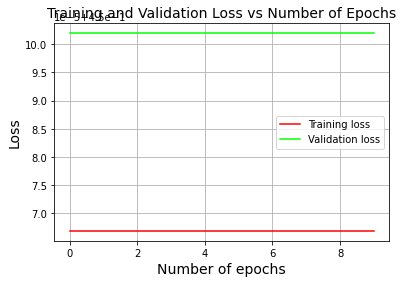

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


training_acc,0.10024
validation_accuracy,0.09783
training_loss,0.45007
validation cost,0.4501
epoch,11
_runtime,71
_timestamp,1615435364
_step,9


training_acc,▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▁▁▁▁▁▁▁▁▁
training_loss,▁▁▁▁▁▁▁▁▁▁
validation cost,▁▁▁▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
_runtime,▁▂▃▃▄▅▆▆▇█
_timestamp,▁▂▃▃▄▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: 3h2tro0l with config:
wandb: 	L2_lamb: 0.0005
wandb: 	activation_f: relu
wandb: 	batch_size: 256
wandb: 	epochs: 5
wandb: 	init_mode: random_uniform
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 5
wandb: 	num_neurons: 128
wandb: 	optimizer: nestorov


lr_0.0001_ac_relu_in_random_uniform_op_nestorov_bs_256_L2_0.0005_ep_5_nn_128_nh_5
Epoch number : 2
Training cost:  0.4499291028147809 	Validation cost: 0.4499178001345957
Epoch number : 4
Training cost:  0.4499291028147809 	Validation cost: 0.4499178001345957
Epoch number : 6
Training cost:  0.4499291028147809 	Validation cost: 0.4499178001345957

Final training cost: 0.4499291028147809


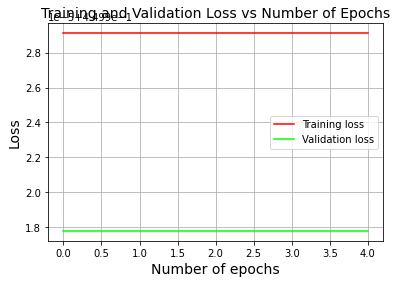

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


training_acc,0.09965
validation_accuracy,0.10317
training_loss,0.44993
validation cost,0.44992
epoch,6
_runtime,35
_timestamp,1615435408
_step,4


training_acc,▁▁▁▁▁
validation_accuracy,▁▁▁▁▁
training_loss,▁▁▁▁▁
validation cost,▁▁▁▁▁
epoch,▁▃▅▆█
_runtime,▁▃▄▆█
_timestamp,▁▃▄▆█
_step,▁▃▅▆█


wandb: Agent Starting Run: 55ctw4m0 with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_f: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	init_mode: random_uniform
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 5
wandb: 	num_neurons: 128
wandb: 	optimizer: sgd


lr_0.001_ac_relu_in_random_uniform_op_sgd_bs_64_L2_0.5_ep_5_nn_128_nh_5
Epoch number : 2
Training cost:  0.4497039024062047 	Validation cost: 0.4498796633134521
Epoch number : 4
Training cost:  0.4493196670086441 	Validation cost: 0.44946345928716136
Epoch number : 6
Training cost:  0.44904016769944916 	Validation cost: 0.44915849789169887

Final training cost: 0.44904016769944916


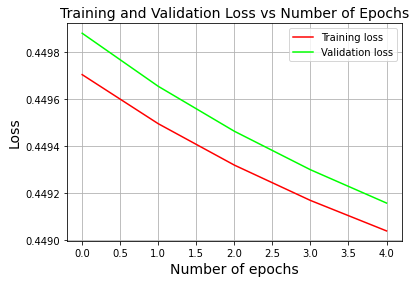

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


training_acc,0.0995
validation_accuracy,0.1045
training_loss,0.44904
validation cost,0.44916
epoch,6
_runtime,48
_timestamp,1615435465
_step,4


training_acc,▅█▁▃▃
validation_accuracy,▄▁███
training_loss,█▆▄▂▁
validation cost,█▆▄▂▁
epoch,▁▃▅▆█
_runtime,▁▃▅▆█
_timestamp,▁▃▅▆█
_step,▁▃▅▆█


wandb: Agent Starting Run: lzdip896 with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_f: sigmoid
wandb: 	batch_size: 256
wandb: 	epochs: 10
wandb: 	init_mode: random_normal
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 4
wandb: 	num_neurons: 128
wandb: 	optimizer: momentum


lr_0.0001_ac_sigmoid_in_random_normal_op_momentum_bs_256_L2_0.5_ep_10_nn_128_nh_4
Epoch number : 2
Training cost:  0.4502217248254753 	Validation cost: 0.4508062164131036
Epoch number : 4
Training cost:  0.4502178979066575 	Validation cost: 0.45080219767496205
Epoch number : 6
Training cost:  0.4502141684527832 	Validation cost: 0.4507982776088967
Epoch number : 8
Training cost:  0.4502105338417458 	Validation cost: 0.4507944535573426
Epoch number : 10
Training cost:  0.45020699152957283 	Validation cost: 0.45079072294265937

Final training cost: 0.4502052542112581


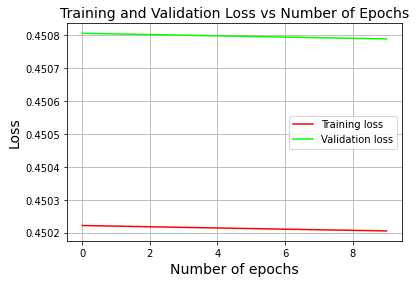

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


training_acc,0.10024
validation_accuracy,0.09783
training_loss,0.45021
validation cost,0.45079
epoch,11
_runtime,112
_timestamp,1615435586
_step,9


training_acc,▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▁▁▁▁▁▁▁▁▁
training_loss,█▇▆▆▅▄▃▂▂▁
validation cost,█▇▆▆▅▄▃▂▂▁
epoch,▁▂▃▃▄▅▆▆▇█
_runtime,▁▂▃▃▄▅▆▆▇█
_timestamp,▁▂▃▃▄▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: 97zyttx6 with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_f: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	init_mode: random_normal
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 3
wandb: 	num_neurons: 32
wandb: 	optimizer: nadam


lr_0.001_ac_relu_in_random_normal_op_nadam_bs_16_L2_0.5_ep_10_nn_32_nh_3
Epoch number : 2
Training cost:  0.45003892748090646 	Validation cost: 0.4500271859613173
Epoch number : 4
Training cost:  0.4500389334097197 	Validation cost: 0.45002632009962873
Epoch number : 6
Training cost:  0.4500389333205638 	Validation cost: 0.4500263190108255
Epoch number : 8
Training cost:  0.450038933296422 	Validation cost: 0.45002631896546497
Epoch number : 10
Training cost:  0.4500389332790244 	Validation cost: 0.4500263189335533

Final training cost: 0.4500389332722295


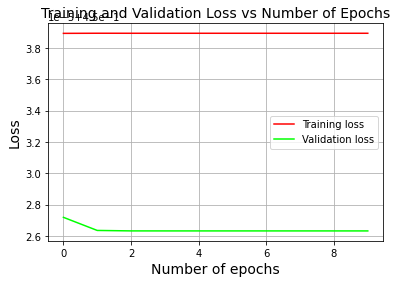

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


training_acc,0.09985
validation_accuracy,0.10133
training_loss,0.45004
validation cost,0.45003
epoch,11
_runtime,220
_timestamp,1615435816
_step,9


training_acc,▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▁▁▁▁▁▁▁▁▁
training_loss,▁▁▁▁▁▁▁▁▁▁
validation cost,█▁▁▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
_runtime,▁▁▁▂▂▂▃▅▆█
_timestamp,▁▁▁▂▂▂▃▅▆█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: fi1tranx with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_f: tanh
wandb: 	batch_size: 128
wandb: 	epochs: 20
wandb: 	init_mode: random_uniform
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 5
wandb: 	num_neurons: 32
wandb: 	optimizer: nestorov


lr_0.0001_ac_tanh_in_random_uniform_op_nestorov_bs_128_L2_0.5_ep_20_nn_32_nh_5
Epoch number : 2
Training cost:  0.45000450828573724 	Validation cost: 0.45004082566341197
Epoch number : 4
Training cost:  0.45000450828573724 	Validation cost: 0.45004082566341197
Epoch number : 6
Training cost:  0.45000450828573724 	Validation cost: 0.45004082566341197
Epoch number : 8
Training cost:  0.45000450828573724 	Validation cost: 0.45004082566341197
Epoch number : 10
Training cost:  0.45000450828573724 	Validation cost: 0.45004082566341197
Epoch number : 12
Training cost:  0.45000450828573724 	Validation cost: 0.45004082566341197
Epoch number : 14
Training cost:  0.45000450828573724 	Validation cost: 0.45004082566341197
Epoch number : 16
Training cost:  0.45000450828573724 	Validation cost: 0.45004082566341197
Epoch number : 18
Training cost:  0.45000450828573724 	Validation cost: 0.45004082566341197
Epoch number : 20
Training cost:  0.45000450828573724 	Validation cost: 0.45004082566341197

Fina

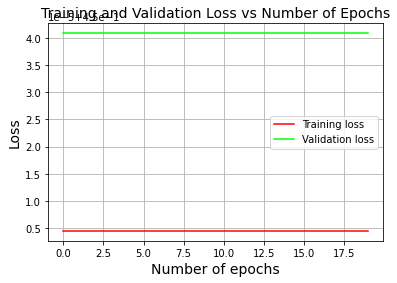

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


training_acc,0.09965
validation_accuracy,0.10317
training_loss,0.45
validation cost,0.45004
epoch,21
_runtime,69
_timestamp,1615435894
_step,19


training_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
training_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation cost,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_runtime,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_timestamp,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Agent Starting Run: yg5n42hy with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_f: relu
wandb: 	batch_size: 256
wandb: 	epochs: 10
wandb: 	init_mode: xavier
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 4
wandb: 	num_neurons: 128
wandb: 	optimizer: nadam


lr_0.001_ac_relu_in_xavier_op_nadam_bs_256_L2_0.5_ep_10_nn_128_nh_4
Epoch number : 2
Training cost:  0.18348134757234913 	Validation cost: 0.20311183504209768
Epoch number : 4
Training cost:  0.15274300127506538 	Validation cost: 0.16208334226359394
Epoch number : 6
Training cost:  0.14400083316610957 	Validation cost: 0.1526456999019264
Epoch number : 8
Training cost:  0.18014366909876817 	Validation cost: 0.18964349960256863
Epoch number : 10
Training cost:  0.1458078171748706 	Validation cost: 0.15451200465034337

Final training cost: 0.14628065591603495


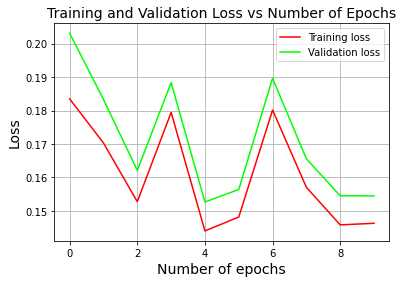

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


training_acc,0.79181
validation_accuracy,0.7875
training_loss,0.14628
validation cost,0.15447
epoch,11
_runtime,73
_timestamp,1615435977
_step,9


training_acc,▃▄▇▂██▁▅▇█
validation_accuracy,▃▄▇▃██▁▆▇▇
training_loss,█▆▃▇▁▂▇▃▁▁
validation cost,█▅▂▆▁▂▆▃▁▁
epoch,▁▂▃▃▄▅▆▆▇█
_runtime,▁▂▃▃▄▅▆▆▇█
_timestamp,▁▂▃▃▄▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: 52tdw2im with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_f: sigmoid
wandb: 	batch_size: 128
wandb: 	epochs: 20
wandb: 	init_mode: random_uniform
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 5
wandb: 	num_neurons: 64
wandb: 	optimizer: adam


lr_0.001_ac_sigmoid_in_random_uniform_op_adam_bs_128_L2_0.5_ep_20_nn_64_nh_5
Epoch number : 2
Training cost:  0.4501101077074026 	Validation cost: 0.45002865161524414
Epoch number : 4
Training cost:  0.4501262501360901 	Validation cost: 0.45005279726892067
Epoch number : 6
Training cost:  0.45013149037731387 	Validation cost: 0.4500606471419222
Epoch number : 8
Training cost:  0.45013338703256706 	Validation cost: 0.45006337300099947
Epoch number : 10
Training cost:  0.4501340630300818 	Validation cost: 0.4500642858333225
Epoch number : 12
Training cost:  0.4501342427402051 	Validation cost: 0.4500644821677076
Epoch number : 14
Training cost:  0.4501342057832915 	Validation cost: 0.45006438134112525
Epoch number : 16
Training cost:  0.4501340676731227 	Validation cost: 0.45006415451431736
Epoch number : 18
Training cost:  0.4501338780009071 	Validation cost: 0.4500638735353602
Epoch number : 20
Training cost:  0.4501336587900666 	Validation cost: 0.45006356894969685

Final training cos

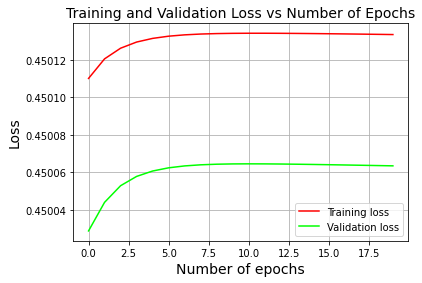

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


training_acc,0.09965
validation_accuracy,0.10317
training_loss,0.45013
validation cost,0.45006
epoch,21
_runtime,174
_timestamp,1615436161
_step,19


training_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
training_loss,▁▄▆▇▇███████████████
validation cost,▁▄▆▇▇███████████████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_runtime,▁▁▂▂▃▃▃▄▄▄▅▅▅▆▆▇▇▇██
_timestamp,▁▁▂▂▃▃▃▄▄▄▅▅▅▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Agent Starting Run: zgh0xzlv with config:
wandb: 	L2_lamb: 0
wandb: 	activation_f: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	init_mode: random_normal
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 4
wandb: 	num_neurons: 32
wandb: 	optimizer: RMSprop


lr_0.001_ac_tanh_in_random_normal_op_RMSprop_bs_32_L2_0_ep_20_nn_32_nh_4
Epoch number : 2
Training cost:  0.24695137749898222 	Validation cost: 0.25141897254915657
Epoch number : 4
Training cost:  0.14916226584547915 	Validation cost: 0.15147691395406615
Epoch number : 6
Training cost:  0.10440048389595534 	Validation cost: 0.11145513930820133
Epoch number : 8
Training cost:  0.0971657835781781 	Validation cost: 0.10414917277135062
Epoch number : 10
Training cost:  0.08951228641846966 	Validation cost: 0.10008016957262234
Epoch number : 12
Training cost:  0.08533737164149359 	Validation cost: 0.09758248540695655
Epoch number : 14
Training cost:  0.08458834157669314 	Validation cost: 0.09779850722572853
Epoch number : 16
Training cost:  0.0832428496120949 	Validation cost: 0.09857803175420946
Epoch number : 18
Training cost:  0.07899047467992881 	Validation cost: 0.09674993388473631
Epoch number : 20
Training cost:  0.08236104261841136 	Validation cost: 0.09921443045465451

Final traini

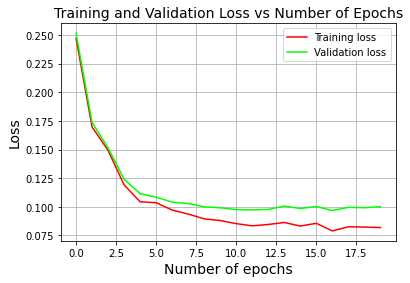

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


training_acc,0.88948
validation_accuracy,0.86817
training_loss,0.08192
validation cost,0.10019
epoch,21
_runtime,119
_timestamp,1615436290
_step,19


training_acc,▁▅▆▇▇▇▇█████████████
validation_accuracy,▁▅▆▇▇▇██████████████
training_loss,█▅▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
validation cost,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_runtime,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▆▇▇██
_timestamp,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▆▇▇██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Agent Starting Run: rz3cmbze with config:
wandb: 	L2_lamb: 0.0005
wandb: 	activation_f: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	init_mode: random_uniform
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 3
wandb: 	num_neurons: 64
wandb: 	optimizer: sgd


lr_0.001_ac_relu_in_random_uniform_op_sgd_bs_32_L2_0.0005_ep_10_nn_64_nh_3
Epoch number : 2
Training cost:  0.4499111010526145 	Validation cost: 0.44990609492375694
Epoch number : 4
Training cost:  0.44970417668485974 	Validation cost: 0.4496855524846931
Epoch number : 6
Training cost:  0.4494971469587045 	Validation cost: 0.44946456602918855
Epoch number : 8
Training cost:  0.4492811935684592 	Validation cost: 0.4492336568837322
Epoch number : 10
Training cost:  0.4490491451786909 	Validation cost: 0.4489850118732389

Final training cost: 0.4489252253610823


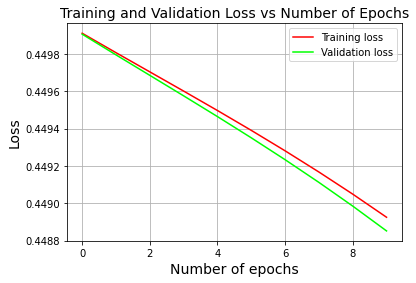

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


training_acc,0.0995
validation_accuracy,0.1045
training_loss,0.44893
validation cost,0.44885
epoch,11
_runtime,53
_timestamp,1615436352
_step,9


training_acc,▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▁▁▁▁▁▁▁▁▁
training_loss,█▇▇▆▅▄▄▃▂▁
validation cost,█▇▇▆▅▄▄▃▂▁
epoch,▁▂▃▃▄▅▆▆▇█
_runtime,▁▂▃▃▄▅▆▆▇█
_timestamp,▁▂▃▃▄▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: 0pnc4ipk with config:
wandb: 	L2_lamb: 0.0005
wandb: 	activation_f: sigmoid
wandb: 	batch_size: 512
wandb: 	epochs: 5
wandb: 	init_mode: random_normal
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 3
wandb: 	num_neurons: 32
wandb: 	optimizer: nadam


lr_0.001_ac_sigmoid_in_random_normal_op_nadam_bs_512_L2_0.0005_ep_5_nn_32_nh_3
Epoch number : 2
Training cost:  0.4500045550233643 	Validation cost: 0.4499948661266335
Epoch number : 4
Training cost:  0.45000748861374334 	Validation cost: 0.4499922378951429
Epoch number : 6
Training cost:  0.4500084187563945 	Validation cost: 0.4499918844431878

Final training cost: 0.4500084187563945


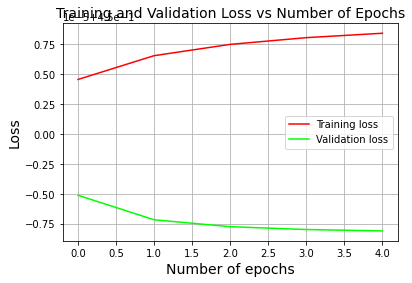

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


training_acc,0.09985
validation_accuracy,0.10133
training_loss,0.45001
validation cost,0.44999
epoch,6
_runtime,17
_timestamp,1615436378
_step,4


training_acc,▁████
validation_accuracy,█▁▁▁▁
training_loss,▁▅▆▇█
validation cost,█▃▂▁▁
epoch,▁▃▅▆█
_runtime,▁▃▄▆█
_timestamp,▁▃▄▆█
_step,▁▃▅▆█


wandb: Agent Starting Run: tci2yfrc with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_f: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 40
wandb: 	init_mode: random_normal
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 3
wandb: 	num_neurons: 32
wandb: 	optimizer: momentum


lr_0.001_ac_tanh_in_random_normal_op_momentum_bs_32_L2_0.5_ep_40_nn_32_nh_3
Epoch number : 2
Training cost:  0.4500115673200119 	Validation cost: 0.45010789305078275
Epoch number : 4
Training cost:  0.450010390157306 	Validation cost: 0.45009755617891906
Epoch number : 6
Training cost:  0.45000932501806856 	Validation cost: 0.45008828107942783
Epoch number : 8
Training cost:  0.4500083611720459 	Validation cost: 0.45007996098975733
Epoch number : 10
Training cost:  0.4500074889852616 	Validation cost: 0.4500724998780595
Epoch number : 12
Training cost:  0.4500066997794619 	Validation cost: 0.4500658113390011
Epoch number : 14
Training cost:  0.4500059857180894 	Validation cost: 0.45005981761231467
Epoch number : 16
Training cost:  0.45000533971211054 	Validation cost: 0.4500544487078314
Epoch number : 18
Training cost:  0.45000475534087386 	Validation cost: 0.45004964162351924
Epoch number : 20
Training cost:  0.4500042267845 	Validation cost: 0.45004533964525173
Epoch number : 22
Trai

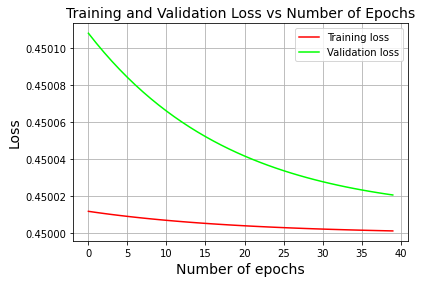

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


training_acc,0.10093
validation_accuracy,0.09167
training_loss,0.45
validation cost,0.45002
epoch,41
_runtime,158
_timestamp,1615436546
_step,39


training_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
training_loss,██▇▇▇▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
validation cost,██▇▇▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 84tchv5s with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_f: relu
wandb: 	batch_size: 512
wandb: 	epochs: 40
wandb: 	init_mode: random_uniform
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 5
wandb: 	num_neurons: 128
wandb: 	optimizer: RMSprop


lr_0.001_ac_relu_in_random_uniform_op_RMSprop_bs_512_L2_0.5_ep_40_nn_128_nh_5
Epoch number : 2
Training cost:  0.4284214142583252 	Validation cost: 0.4284932641411991
Epoch number : 4
Training cost:  0.40717793246329914 	Validation cost: 0.4072668892614535
Epoch number : 6
Training cost:  0.4028483781025857 	Validation cost: 0.40321447943545313
Epoch number : 8
Training cost:  0.41114280973084627 	Validation cost: 0.4129250558737712
Epoch number : 10
Training cost:  0.3855610088187724 	Validation cost: 0.3863952731883749
Epoch number : 12
Training cost:  0.37118291805771697 	Validation cost: 0.37271982951543586
Epoch number : 14
Training cost:  0.41512290969884896 	Validation cost: 0.4176778146103326
Epoch number : 16
Training cost:  0.40538808101960694 	Validation cost: 0.4070199084063067
Epoch number : 18
Training cost:  0.38383170912885445 	Validation cost: 0.3859470581545782
Epoch number : 20
Training cost:  0.3764169588173179 	Validation cost: 0.3793220232917837
Epoch number : 22


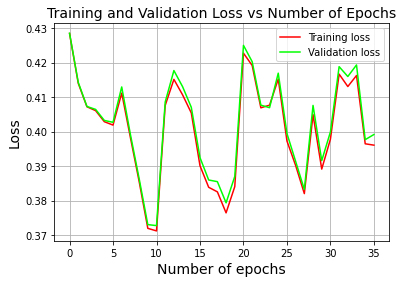

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


training_acc,0.10006
validation_accuracy,0.0995
training_loss,nan
validation cost,nan
epoch,41
_runtime,3706
_timestamp,1615440262
_step,39


training_acc,▅▆▆▆▅█▆▄▄▇▇▅▃▄▅▅▆▆▆▅▃▄▄▄▄▅▅▅▄▅▄▂▄▄▄▅▁▁▁▁
validation_accuracy,▅▆▆▆▅█▅▄▄▇▇▅▄▃▅▅▆▆▆▅▃▄▄▄▄▅▅▅▄▅▅▂▄▃▅▅▁▁▁▁
training_loss,█▆▅▅▅▅▆▄▃▁▁▅▆▆▅▃▃▂▂▃▇▇▅▅▆▄▃▂▅▃▄▇▆▇▄▄
validation cost,█▆▅▅▅▅▆▄▃▁▁▅▇▆▅▃▃▃▂▃█▇▅▅▇▄▃▂▅▃▄▇▆▇▄▄
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇██████
_timestamp,▁▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇██████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: yv19knx4 with config:
wandb: 	L2_lamb: 0.0005
wandb: 	activation_f: tanh
wandb: 	batch_size: 128
wandb: 	epochs: 40
wandb: 	init_mode: random_uniform
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 5
wandb: 	num_neurons: 64
wandb: 	optimizer: RMSprop


lr_0.0001_ac_tanh_in_random_uniform_op_RMSprop_bs_128_L2_0.0005_ep_40_nn_64_nh_5
Epoch number : 2
Training cost:  0.40165921794917675 	Validation cost: 0.4020814432303196
Epoch number : 4
Training cost:  0.3808825513183061 	Validation cost: 0.381524076654414
Epoch number : 6
Training cost:  0.3503816974656485 	Validation cost: 0.3520035106483486
Epoch number : 8
Training cost:  0.3214243396401624 	Validation cost: 0.3229446980535612
Epoch number : 10
Training cost:  0.3120468997871977 	Validation cost: 0.313870870448828
Epoch number : 12
Training cost:  0.3005887291512539 	Validation cost: 0.3020293608735671
Epoch number : 14
Training cost:  0.3052895739119965 	Validation cost: 0.3072568102154295
Epoch number : 16
Training cost:  0.33695566837689533 	Validation cost: 0.33726487110080716
Epoch number : 18
Training cost:  0.28103189627626396 	Validation cost: 0.2804904909772411
Epoch number : 20
Training cost:  0.273489858865762 	Validation cost: 0.2735381543204112
Epoch number : 22
Trai

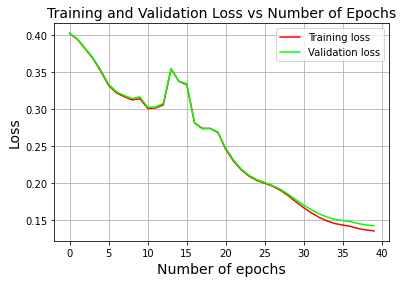

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


training_acc,0.80287
validation_accuracy,0.79033
training_loss,0.135
validation cost,0.14201
epoch,41
_runtime,310
_timestamp,1615440582
_step,39


training_acc,▁▁▁▃▄▄▅▄▄▄▄▄▄▄▄▄▅▆▆▆▆▆▇▇▇▇▇▇▇███████████
validation_accuracy,▁▁▁▃▄▅▅▅▄▄▅▅▄▄▄▄▆▆▆▆▇▇▇▇▇▇▇▇████████████
training_loss,██▇▇▇▆▆▆▆▆▅▅▅▇▆▆▅▅▅▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁
validation cost,██▇▇▇▆▆▆▆▆▅▅▅▇▆▆▅▅▅▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: et4n7d0s with config:
wandb: 	L2_lamb: 0
wandb: 	activation_f: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	init_mode: xavier
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 3
wandb: 	num_neurons: 32
wandb: 	optimizer: sgd


lr_0.001_ac_tanh_in_xavier_op_sgd_bs_16_L2_0_ep_5_nn_32_nh_3
Epoch number : 2
Training cost:  0.40998146767897764 	Validation cost: 0.4105051984160126
Epoch number : 4
Training cost:  0.3295349118389775 	Validation cost: 0.33122876445064325
Epoch number : 6
Training cost:  0.2829923424197288 	Validation cost: 0.2854140126268674

Final training cost: 0.2829923424197288


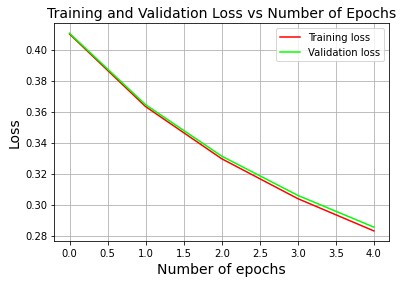

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


training_acc,0.62965
validation_accuracy,0.62717
training_loss,0.28299
validation cost,0.28541
epoch,6
_runtime,30
_timestamp,1615440622
_step,4


training_acc,▁▅▆▇█
validation_accuracy,▁▅▆▇█
training_loss,█▅▄▂▁
validation cost,█▅▄▂▁
epoch,▁▃▅▆█
_runtime,▁▃▅▆█
_timestamp,▁▃▅▆█
_step,▁▃▅▆█


wandb: Agent Starting Run: jeivpz63 with config:
wandb: 	L2_lamb: 0.0005
wandb: 	activation_f: sigmoid
wandb: 	batch_size: 256
wandb: 	epochs: 10
wandb: 	init_mode: random_uniform
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 5
wandb: 	num_neurons: 64
wandb: 	optimizer: momentum


lr_0.0001_ac_sigmoid_in_random_uniform_op_momentum_bs_256_L2_0.0005_ep_10_nn_64_nh_5
Epoch number : 2
Training cost:  0.4500063409245375 	Validation cost: 0.44999169756927515
Epoch number : 4
Training cost:  0.45000623517916183 	Validation cost: 0.4499918186561197
Epoch number : 6
Training cost:  0.4500061309963881 	Validation cost: 0.44999193965042594
Epoch number : 8
Training cost:  0.4500060283533265 	Validation cost: 0.4499920605408821
Epoch number : 10
Training cost:  0.45000592722741806 	Validation cost: 0.4499921813164333

Final training cost: 0.4500058772264362


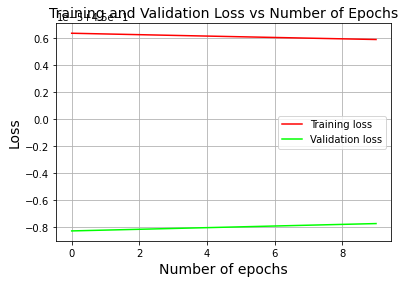

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


training_acc,0.10006
validation_accuracy,0.0995
training_loss,0.45001
validation cost,0.44999
epoch,11
_runtime,71
_timestamp,1615440703
_step,9


training_acc,▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▁▁▁▁▁▁▁▁▁
training_loss,█▇▇▆▅▄▃▂▁▁
validation cost,▁▂▃▃▄▅▆▆▇█
epoch,▁▂▃▃▄▅▆▆▇█
_runtime,▁▂▂▃▄▅▆▇▇█
_timestamp,▁▂▂▃▄▅▆▇▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: 4afnihns with config:
wandb: 	L2_lamb: 0
wandb: 	activation_f: relu
wandb: 	batch_size: 256
wandb: 	epochs: 5
wandb: 	init_mode: random_normal
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 3
wandb: 	num_neurons: 32
wandb: 	optimizer: nestorov


lr_0.0001_ac_relu_in_random_normal_op_nestorov_bs_256_L2_0_ep_5_nn_32_nh_3
Epoch number : 2
Training cost:  0.4499999668049666 	Validation cost: 0.44999997241417045
Epoch number : 4
Training cost:  0.4499999668049666 	Validation cost: 0.44999997241417045
Epoch number : 6
Training cost:  0.4499999668049666 	Validation cost: 0.44999997241417045

Final training cost: 0.4499999668049666


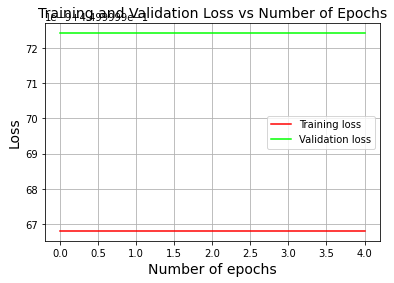

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


training_acc,0.11224
validation_accuracy,0.115
training_loss,0.45
validation cost,0.45
epoch,6
_runtime,11
_timestamp,1615440725
_step,4


training_acc,▁▁▁▁▁
validation_accuracy,▁▁▁▁▁
training_loss,▁▁▁▁▁
validation cost,▁▁▁▁▁
epoch,▁▃▅▆█
_runtime,▁▃▅▆█
_timestamp,▁▃▅▆█
_step,▁▃▅▆█


wandb: Agent Starting Run: 8j2z0qny with config:
wandb: 	L2_lamb: 0.0005
wandb: 	activation_f: tanh
wandb: 	batch_size: 512
wandb: 	epochs: 5
wandb: 	init_mode: xavier
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 5
wandb: 	num_neurons: 64
wandb: 	optimizer: momentum


lr_0.001_ac_tanh_in_xavier_op_momentum_bs_512_L2_0.0005_ep_5_nn_64_nh_5
Epoch number : 2
Training cost:  0.448605274499275 	Validation cost: 0.4489793393359931
Epoch number : 4
Training cost:  0.44531118192733826 	Validation cost: 0.44574622531969416
Epoch number : 6
Training cost:  0.44201301761654216 	Validation cost: 0.4425236426415102

Final training cost: 0.44201301761654216


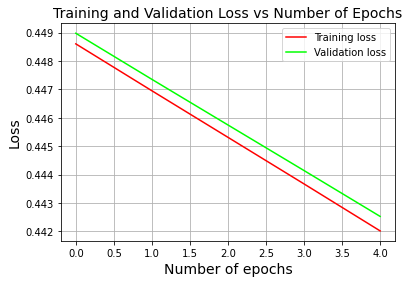

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


training_acc,0.25622
validation_accuracy,0.24967
training_loss,0.44201
validation cost,0.44252
epoch,6
_runtime,35
_timestamp,1615440770
_step,4


training_acc,▁▃▅▇█
validation_accuracy,▁▃▅▆█
training_loss,█▆▅▃▁
validation cost,█▆▄▃▁
epoch,▁▃▅▆█
_runtime,▁▃▄▆█
_timestamp,▁▃▄▆█
_step,▁▃▅▆█


wandb: Agent Starting Run: 0ey9s47w with config:
wandb: 	L2_lamb: 0.0005
wandb: 	activation_f: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 40
wandb: 	init_mode: random_uniform
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 4
wandb: 	num_neurons: 128
wandb: 	optimizer: sgd


lr_0.001_ac_tanh_in_random_uniform_op_sgd_bs_16_L2_0.0005_ep_40_nn_128_nh_4
Epoch number : 2
Training cost:  0.4497817346418011 	Validation cost: 0.44976120321663887
Epoch number : 4
Training cost:  0.44948502150636105 	Validation cost: 0.4494365993937523
Epoch number : 6
Training cost:  0.4492827748379111 	Validation cost: 0.44921239310554745
Epoch number : 8
Training cost:  0.4491264447219138 	Validation cost: 0.4490386699497949
Epoch number : 10
Training cost:  0.44899177388636957 	Validation cost: 0.4488901532288395
Epoch number : 12
Training cost:  0.44886549329364855 	Validation cost: 0.4487527182377738
Epoch number : 14
Training cost:  0.44874000667758795 	Validation cost: 0.44861804137710193
Epoch number : 16
Training cost:  0.4486107679860693 	Validation cost: 0.44848097604693915
Epoch number : 18
Training cost:  0.44847483337163896 	Validation cost: 0.4483381007275398
Epoch number : 20
Training cost:  0.44833002757961454 	Validation cost: 0.4481868727205878
Epoch number : 22


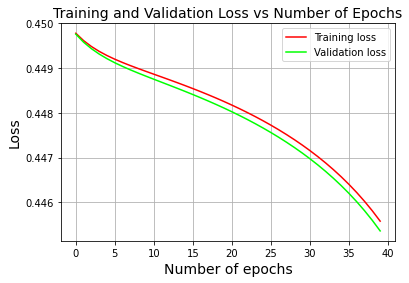

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


training_acc,0.14531
validation_accuracy,0.154
training_loss,0.44558
validation cost,0.44536
epoch,41
_runtime,829
_timestamp,1615441609
_step,39


training_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇██
validation_accuracy,▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▃▃▄▄▄▄▅▅▅▆▆▆▆▆▇▇▇▇██
training_loss,███▇▇▇▇▇▇▇▆▆▆▆▆▆▆▆▆▅▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▂▂▂▁▁
validation cost,██▇▇▇▇▇▇▇▇▆▆▆▆▆▆▆▆▅▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▂▂▂▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: uhrq79ip with config:
wandb: 	L2_lamb: 0
wandb: 	activation_f: relu
wandb: 	batch_size: 32
wandb: 	epochs: 40
wandb: 	init_mode: random_normal
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 3
wandb: 	num_neurons: 32
wandb: 	optimizer: adam


lr_0.001_ac_relu_in_random_normal_op_adam_bs_32_L2_0_ep_40_nn_32_nh_3
Epoch number : 2
Training cost:  0.450004770632322 	Validation cost: 0.4499976944694902
Epoch number : 4
Training cost:  nan 	Validation cost: nan
Epoch number : 6
Training cost:  nan 	Validation cost: nan
Epoch number : 8
Training cost:  nan 	Validation cost: nan
Epoch number : 10
Training cost:  nan 	Validation cost: nan
Epoch number : 12
Training cost:  nan 	Validation cost: nan
Epoch number : 14
Training cost:  nan 	Validation cost: nan
Epoch number : 16
Training cost:  nan 	Validation cost: nan
Epoch number : 18
Training cost:  nan 	Validation cost: nan
Epoch number : 20
Training cost:  nan 	Validation cost: nan
Epoch number : 22
Training cost:  nan 	Validation cost: nan
Epoch number : 24
Training cost:  nan 	Validation cost: nan
Epoch number : 26
Training cost:  nan 	Validation cost: nan
Epoch number : 28
Training cost:  nan 	Validation cost: nan
Epoch number : 30
Training cost:  nan 	Validation cost: nan
Epoch

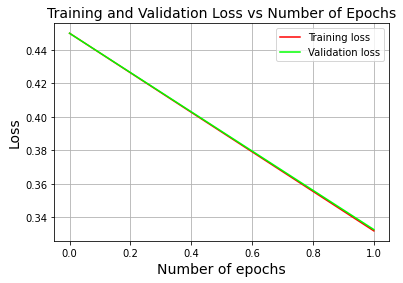

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


training_acc,0.10006
validation_accuracy,0.0995
training_loss,nan
validation cost,nan
epoch,41
_runtime,167
_timestamp,1615441785
_step,39


training_acc,▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
training_loss,█▁
validation cost,█▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: hain187g with config:
wandb: 	L2_lamb: 0.0005
wandb: 	activation_f: sigmoid
wandb: 	batch_size: 256
wandb: 	epochs: 10
wandb: 	init_mode: random_normal
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 4
wandb: 	num_neurons: 64
wandb: 	optimizer: nadam


lr_0.0001_ac_sigmoid_in_random_normal_op_nadam_bs_256_L2_0.0005_ep_10_nn_64_nh_4
Epoch number : 2
Training cost:  0.45000120934925825 	Validation cost: 0.45000727225641785
Epoch number : 4
Training cost:  0.450000840236245 	Validation cost: 0.4500045541221284
Epoch number : 6
Training cost:  0.45000098030680424 	Validation cost: 0.4500038023494764
Epoch number : 8
Training cost:  0.45000104409731473 	Validation cost: 0.45000347836535237
Epoch number : 10
Training cost:  0.45000107803343276 	Validation cost: 0.45000330918343817

Final training cost: 0.4500010890757818


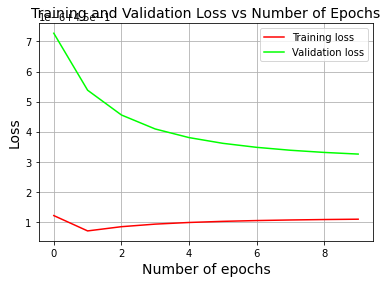

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


training_acc,0.09961
validation_accuracy,0.1035
training_loss,0.45
validation cost,0.45
epoch,11
_runtime,68
_timestamp,1615441862
_step,9


training_acc,█▁▁▁▁▁▁▁▁▁
validation_accuracy,▁█████████
training_loss,█▁▃▄▅▆▆▆▆▆
validation cost,█▅▃▂▂▂▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
_runtime,▁▂▃▃▄▅▆▆▇█
_timestamp,▁▂▃▃▄▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: d6vdo8qc with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_f: tanh
wandb: 	batch_size: 128
wandb: 	epochs: 40
wandb: 	init_mode: random_normal
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 5
wandb: 	num_neurons: 128
wandb: 	optimizer: sgd


lr_0.0001_ac_tanh_in_random_normal_op_sgd_bs_128_L2_0.5_ep_40_nn_128_nh_5
Epoch number : 2
Training cost:  0.4500773403259925 	Validation cost: 0.4506958487562699
Epoch number : 4
Training cost:  0.45007728807144604 	Validation cost: 0.45069540086786797
Epoch number : 6
Training cost:  0.4500772358525268 	Validation cost: 0.450694953274564
Epoch number : 8
Training cost:  0.45007718366920935 	Validation cost: 0.45069450597616223
Epoch number : 10
Training cost:  0.4500771315214682 	Validation cost: 0.4506940589724678
Epoch number : 12
Training cost:  0.4500770794092783 	Validation cost: 0.45069361226328547
Epoch number : 14
Training cost:  0.45007702733261423 	Validation cost: 0.45069316584842045
Epoch number : 16
Training cost:  0.4500769752914505 	Validation cost: 0.4506927197276777
Epoch number : 18
Training cost:  0.4500769232857623 	Validation cost: 0.4506922739008629
Epoch number : 20
Training cost:  0.45007687131552343 	Validation cost: 0.4506918283677814
Epoch number : 22
Train

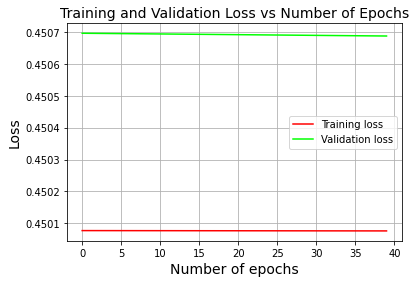

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


training_acc,0.10093
validation_accuracy,0.09167
training_loss,0.45008
validation cost,0.45069
epoch,41
_runtime,469
_timestamp,1615442341
_step,39


training_acc,▁███████████████████████████████████████
validation_accuracy,▁███████████████████████████████████████
training_loss,███▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
validation cost,███▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: a46po9cc with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_f: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	init_mode: random_uniform
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 3
wandb: 	num_neurons: 32
wandb: 	optimizer: sgd


lr_0.001_ac_relu_in_random_uniform_op_sgd_bs_64_L2_0.5_ep_10_nn_32_nh_3
Epoch number : 2
Training cost:  0.4500065286956687 	Validation cost: 0.4500400691142328
Epoch number : 4
Training cost:  0.4500032891549078 	Validation cost: 0.45003601706761076
Epoch number : 6
Training cost:  0.4500004413910405 	Validation cost: 0.4500324026912953
Epoch number : 8
Training cost:  0.4499979437017783 	Validation cost: 0.45002918073661513
Epoch number : 10
Training cost:  0.4499957591337239 	Validation cost: 0.4500263110553484

Final training cost: 0.449994773866195


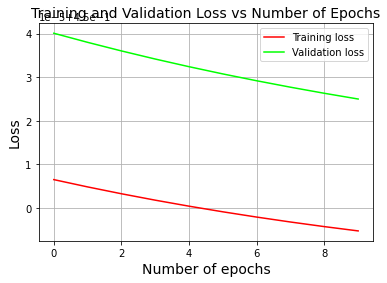

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


training_acc,0.12843
validation_accuracy,0.1255
training_loss,0.44999
validation cost,0.45002
epoch,11
_runtime,24
_timestamp,1615442375
_step,9


training_acc,▁▁▁▁▂▂▃▄▆█
validation_accuracy,▁▁▁▁▂▂▃▄▆█
training_loss,█▇▆▅▄▄▃▂▂▁
validation cost,█▇▆▅▄▄▃▂▂▁
epoch,▁▂▃▃▄▅▆▆▇█
_runtime,▁▂▂▃▄▅▅▆▇█
_timestamp,▁▂▂▃▄▅▅▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: ubuc6ipq with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_f: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 40
wandb: 	init_mode: random_normal
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 5
wandb: 	num_neurons: 128
wandb: 	optimizer: nadam


lr_0.0001_ac_sigmoid_in_random_normal_op_nadam_bs_32_L2_0.5_ep_40_nn_128_nh_5
Epoch number : 2
Training cost:  0.45007278781651605 	Validation cost: 0.4500307859614665
Epoch number : 4
Training cost:  0.45007674719412644 	Validation cost: 0.45003136197420535
Epoch number : 6
Training cost:  0.4500769384545838 	Validation cost: 0.4500316117818945
Epoch number : 8
Training cost:  0.4500769859301938 	Validation cost: 0.4500317349215823
Epoch number : 10
Training cost:  0.45007702506272984 	Validation cost: 0.4500318465024061
Epoch number : 12
Training cost:  0.45007706090671146 	Validation cost: 0.4500319504404158
Epoch number : 14
Training cost:  0.4500770937837387 	Validation cost: 0.4500320472582446
Epoch number : 16
Training cost:  0.4500771238417487 	Validation cost: 0.45003213735663977
Epoch number : 18
Training cost:  0.45007715121883785 	Validation cost: 0.4500322211139496
Epoch number : 20
Training cost:  0.45007717604876724 	Validation cost: 0.45003229888967156
Epoch number : 22

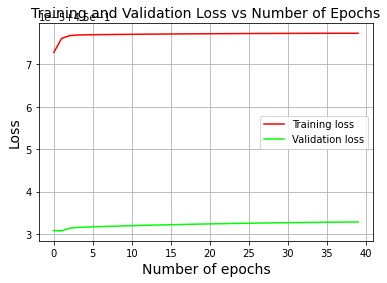

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


training_acc,0.09965
validation_accuracy,0.10317
training_loss,0.45008
validation cost,0.45003
epoch,41
_runtime,1165
_timestamp,1615443550
_step,39


training_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
training_loss,▁▆▇▇▇▇▇▇████████████████████████████████
validation cost,▁▁▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇█████████
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: z2qn0t6z with config:
wandb: 	L2_lamb: 0
wandb: 	activation_f: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 40
wandb: 	init_mode: xavier
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 3
wandb: 	num_neurons: 32
wandb: 	optimizer: RMSprop


lr_0.0001_ac_tanh_in_xavier_op_RMSprop_bs_64_L2_0_ep_40_nn_32_nh_3
Epoch number : 2
Training cost:  0.17846395975791954 	Validation cost: 0.18207346097894078
Epoch number : 4
Training cost:  0.11884443022514694 	Validation cost: 0.12198646857723842
Epoch number : 6
Training cost:  0.10541380618868552 	Validation cost: 0.10896700326135483
Epoch number : 8
Training cost:  0.09865516947492563 	Validation cost: 0.10308395829216971
Epoch number : 10
Training cost:  0.0941724824309437 	Validation cost: 0.09957947855346733
Epoch number : 12
Training cost:  0.09081300900336522 	Validation cost: 0.09716681926874922
Epoch number : 14
Training cost:  0.08816327506390918 	Validation cost: 0.09542502698369018
Epoch number : 16
Training cost:  0.08600824636258517 	Validation cost: 0.09410249873602124
Epoch number : 18
Training cost:  0.08420125224081226 	Validation cost: 0.09303621119264262
Epoch number : 20
Training cost:  0.08263858891673728 	Validation cost: 0.09212568650241826
Epoch number : 22


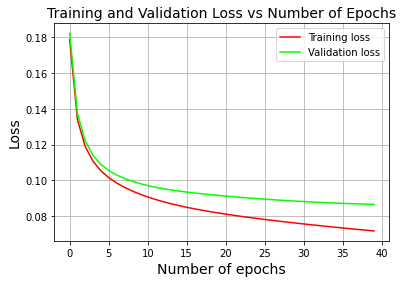

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


training_acc,0.9042
validation_accuracy,0.87967
training_loss,0.07189
validation cost,0.08668
epoch,41
_runtime,158
_timestamp,1615443717
_step,39


training_acc,▁▃▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████████████
validation_accuracy,▁▃▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇████████████████
training_loss,█▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation cost,█▅▄▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: j0aj574x with config:
wandb: 	L2_lamb: 0.0005
wandb: 	activation_f: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 40
wandb: 	init_mode: xavier
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 4
wandb: 	num_neurons: 64
wandb: 	optimizer: adam


lr_0.001_ac_sigmoid_in_xavier_op_adam_bs_16_L2_0.0005_ep_40_nn_64_nh_4
Epoch number : 2
Training cost:  0.2962498408037181 	Validation cost: 0.2971152400862042
Epoch number : 4
Training cost:  0.175064607933361 	Validation cost: 0.17972289064518956
Epoch number : 6
Training cost:  0.12642054816622555 	Validation cost: 0.1297411246394702
Epoch number : 8
Training cost:  0.1074500973969325 	Validation cost: 0.11293044702821088
Epoch number : 10
Training cost:  0.10606482578972688 	Validation cost: 0.11278485021000204
Epoch number : 12
Training cost:  0.11214251081090706 	Validation cost: 0.11962567975949394
Epoch number : 14
Training cost:  0.11116546184658878 	Validation cost: 0.11905624960279826
Epoch number : 16
Training cost:  0.10390591756997006 	Validation cost: 0.1122165494763012
Epoch number : 18
Training cost:  0.09591649960216626 	Validation cost: 0.10548535551686679
Epoch number : 20
Training cost:  0.0920117843126162 	Validation cost: 0.10189986046259598
Epoch number : 22
Tra

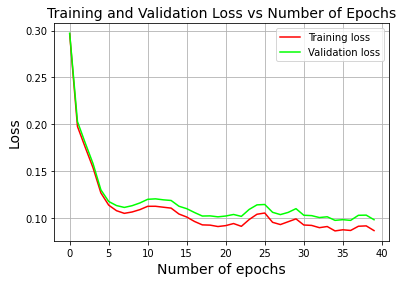

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


training_acc,0.8828
validation_accuracy,0.86917
training_loss,0.08617
validation cost,0.09779
epoch,41
_runtime,795
_timestamp,1615444521
_step,39


training_acc,▁▄▅▆▇▇▇█▇▇▇▇▇▇██████████████████████████
validation_accuracy,▁▄▅▆▇▇███▇▇▇▇▇▇██████████▇██████████████
training_loss,█▅▄▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation cost,█▅▄▃▂▂▂▁▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: nl1okrd2 with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_f: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	init_mode: random_normal
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 3
wandb: 	num_neurons: 32
wandb: 	optimizer: nestorov


lr_0.001_ac_sigmoid_in_random_normal_op_nestorov_bs_64_L2_0.5_ep_5_nn_32_nh_3
Epoch number : 2
Training cost:  0.4500550028875006 	Validation cost: 0.4501432531709383
Epoch number : 4
Training cost:  0.4500550028875006 	Validation cost: 0.4501432531709383
Epoch number : 6
Training cost:  0.4500550028875006 	Validation cost: 0.4501432531709383

Final training cost: 0.4500550028875006


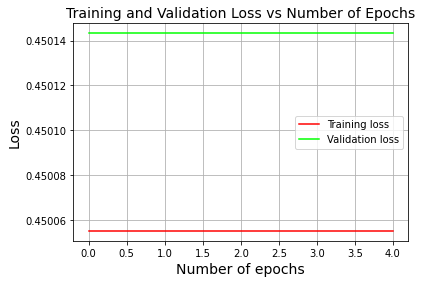

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


training_acc,0.0995
validation_accuracy,0.1045
training_loss,0.45006
validation cost,0.45014
epoch,6
_runtime,18
_timestamp,1615444552
_step,4


training_acc,▁▁▁▁▁
validation_accuracy,▁▁▁▁▁
training_loss,▁▁▁▁▁
validation cost,▁▁▁▁▁
epoch,▁▃▅▆█
_runtime,▁▃▄▆█
_timestamp,▁▃▄▆█
_step,▁▃▅▆█


wandb: Agent Starting Run: uqy8ouc8 with config:
wandb: 	L2_lamb: 0
wandb: 	activation_f: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	init_mode: xavier
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 3
wandb: 	num_neurons: 128
wandb: 	optimizer: nestorov


lr_0.0001_ac_tanh_in_xavier_op_nestorov_bs_64_L2_0_ep_10_nn_128_nh_3
Epoch number : 2
Training cost:  0.46332896472821467 	Validation cost: 0.464539706341587
Epoch number : 4
Training cost:  0.46332896472821467 	Validation cost: 0.464539706341587
Epoch number : 6
Training cost:  0.46332896472821467 	Validation cost: 0.464539706341587
Epoch number : 8
Training cost:  0.46332896472821467 	Validation cost: 0.464539706341587
Epoch number : 10
Training cost:  0.46332896472821467 	Validation cost: 0.464539706341587

Final training cost: 0.46332896472821467


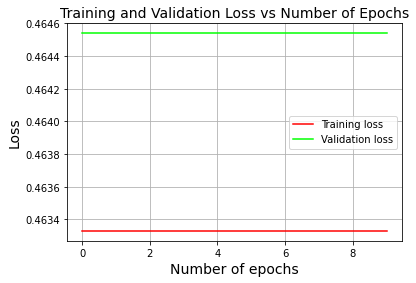

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


training_acc,0.11026
validation_accuracy,0.10917
training_loss,0.46333
validation cost,0.46454
epoch,11
_runtime,106
_timestamp,1615444667
_step,9


training_acc,▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▁▁▁▁▁▁▁▁▁
training_loss,▁▁▁▁▁▁▁▁▁▁
validation cost,▁▁▁▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
_runtime,▁▂▃▃▄▅▆▆▇█
_timestamp,▁▂▃▃▄▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: 2pmzturo with config:
wandb: 	L2_lamb: 0
wandb: 	activation_f: tanh
wandb: 	batch_size: 128
wandb: 	epochs: 20
wandb: 	init_mode: random_uniform
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 4
wandb: 	num_neurons: 128
wandb: 	optimizer: sgd


lr_0.0001_ac_tanh_in_random_uniform_op_sgd_bs_128_L2_0_ep_20_nn_128_nh_4
Epoch number : 2
Training cost:  0.44999335580077676 	Validation cost: 0.44998924243944916
Epoch number : 4
Training cost:  0.4499871952867517 	Validation cost: 0.4499826360098935
Epoch number : 6
Training cost:  0.4499810822015357 	Validation cost: 0.44997607853301413
Epoch number : 8
Training cost:  0.44997501597102313 	Validation cost: 0.44996956942582883
Epoch number : 10
Training cost:  0.4499689960303234 	Validation cost: 0.4499631081146741
Epoch number : 12
Training cost:  0.4499630218235711 	Validation cost: 0.44995669403501287
Epoch number : 14
Training cost:  0.44995709280374224 	Validation cost: 0.44995032663124773
Epoch number : 16
Training cost:  0.449951208432471 	Validation cost: 0.4499440053565395
Epoch number : 18
Training cost:  0.4499453681798746 	Validation cost: 0.4499377296726278
Epoch number : 20
Training cost:  0.4499395715243817 	Validation cost: 0.4499314990496587

Final training cost: 0.

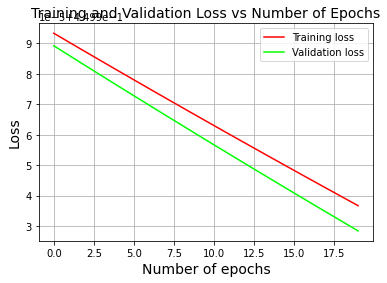

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


training_acc,0.10006
validation_accuracy,0.0995
training_loss,0.44994
validation cost,0.44993
epoch,21
_runtime,228
_timestamp,1615444904
_step,19


training_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
training_loss,██▇▇▆▆▆▅▅▅▄▄▄▃▃▂▂▂▁▁
validation cost,██▇▇▆▆▆▅▅▅▄▄▄▃▃▂▂▂▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_runtime,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_timestamp,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Agent Starting Run: a77fnxz6 with config:
wandb: 	L2_lamb: 0
wandb: 	activation_f: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	init_mode: random_uniform
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 5
wandb: 	num_neurons: 128
wandb: 	optimizer: nestorov


lr_0.001_ac_tanh_in_random_uniform_op_nestorov_bs_32_L2_0_ep_5_nn_128_nh_5
Epoch number : 2
Training cost:  0.4499786091465881 	Validation cost: 0.449971616511621
Epoch number : 4
Training cost:  0.4499786091465881 	Validation cost: 0.449971616511621
Epoch number : 6
Training cost:  0.4499786091465881 	Validation cost: 0.449971616511621

Final training cost: 0.4499786091465881


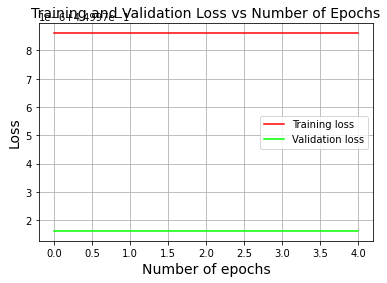

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


training_acc,0.09965
validation_accuracy,0.10317
training_loss,0.44998
validation cost,0.44997
epoch,6
_runtime,88
_timestamp,1615445001
_step,4


training_acc,▁▁▁▁▁
validation_accuracy,▁▁▁▁▁
training_loss,▁▁▁▁▁
validation cost,▁▁▁▁▁
epoch,▁▃▅▆█
_runtime,▁▃▅▆█
_timestamp,▁▃▅▆█
_step,▁▃▅▆█


wandb: Agent Starting Run: qlxp5fn6 with config:
wandb: 	L2_lamb: 0.0005
wandb: 	activation_f: tanh
wandb: 	batch_size: 256
wandb: 	epochs: 5
wandb: 	init_mode: xavier
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 4
wandb: 	num_neurons: 64
wandb: 	optimizer: nestorov


lr_0.0001_ac_tanh_in_xavier_op_nestorov_bs_256_L2_0.0005_ep_5_nn_64_nh_4
Epoch number : 2
Training cost:  0.4471521674194569 	Validation cost: 0.4474895727300002
Epoch number : 4
Training cost:  0.4471521674194569 	Validation cost: 0.4474895727300002
Epoch number : 6
Training cost:  0.4471521674194569 	Validation cost: 0.4474895727300002

Final training cost: 0.4471521674194569


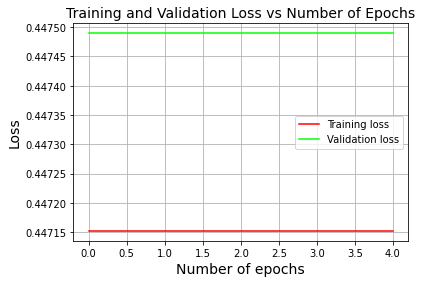

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


training_acc,0.12489
validation_accuracy,0.11917
training_loss,0.44715
validation cost,0.44749
epoch,6
_runtime,31
_timestamp,1615445042
_step,4


training_acc,▁▁▁▁▁
validation_accuracy,▁▁▁▁▁
training_loss,▁▁▁▁▁
validation cost,▁▁▁▁▁
epoch,▁▃▅▆█
_runtime,▁▃▅▆█
_timestamp,▁▃▅▆█
_step,▁▃▅▆█


wandb: Agent Starting Run: fu8ewbfw with config:
wandb: 	L2_lamb: 0
wandb: 	activation_f: relu
wandb: 	batch_size: 256
wandb: 	epochs: 10
wandb: 	init_mode: random_normal
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 5
wandb: 	num_neurons: 64
wandb: 	optimizer: adam


lr_0.001_ac_relu_in_random_normal_op_adam_bs_256_L2_0_ep_10_nn_64_nh_5
Epoch number : 2
Training cost:  0.4499997392334202 	Validation cost: 0.4500067061427171
Epoch number : 4
Training cost:  0.4499997784922736 	Validation cost: 0.45001190045645945
Epoch number : 6
Training cost:  0.4499997456078188 	Validation cost: 0.4500113897656385
Epoch number : 8
Training cost:  0.4499997384158261 	Validation cost: 0.4500108563772801
Epoch number : 10
Training cost:  0.4499997394220621 	Validation cost: 0.45001055279856345

Final training cost: 0.4499997405600886


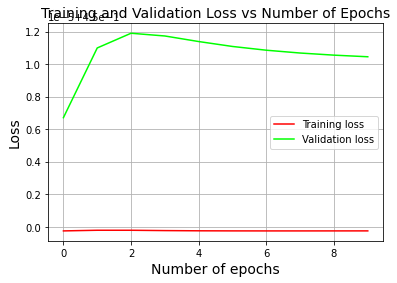

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


training_acc,0.10093
validation_accuracy,0.09167
training_loss,0.45
validation cost,0.45001
epoch,11
_runtime,40
_timestamp,1615445093
_step,9


training_acc,▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▁▁▁▁▁▁▁▁▁
training_loss,▁██▁▁▁▁▁▁▁
validation cost,▁▇██▇▇▇▆▆▆
epoch,▁▂▃▃▄▅▆▆▇█
_runtime,▁▂▃▄▄▅▆▇▇█
_timestamp,▁▂▃▄▄▅▆▇▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: i9c4z7sp with config:
wandb: 	L2_lamb: 0.0005
wandb: 	activation_f: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 40
wandb: 	init_mode: random_uniform
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 3
wandb: 	num_neurons: 64
wandb: 	optimizer: nestorov


lr_0.001_ac_tanh_in_random_uniform_op_nestorov_bs_64_L2_0.0005_ep_40_nn_64_nh_3
Epoch number : 2
Training cost:  0.450009665473649 	Validation cost: 0.45001135561681654
Epoch number : 4
Training cost:  0.450009665473649 	Validation cost: 0.45001135561681654
Epoch number : 6
Training cost:  0.450009665473649 	Validation cost: 0.45001135561681654
Epoch number : 8
Training cost:  0.450009665473649 	Validation cost: 0.45001135561681654
Epoch number : 10
Training cost:  0.450009665473649 	Validation cost: 0.45001135561681654
Epoch number : 12
Training cost:  0.450009665473649 	Validation cost: 0.45001135561681654
Epoch number : 14
Training cost:  0.450009665473649 	Validation cost: 0.45001135561681654
Epoch number : 16
Training cost:  0.450009665473649 	Validation cost: 0.45001135561681654
Epoch number : 18
Training cost:  0.450009665473649 	Validation cost: 0.45001135561681654
Epoch number : 20
Training cost:  0.450009665473649 	Validation cost: 0.45001135561681654
Epoch number : 22
Traini

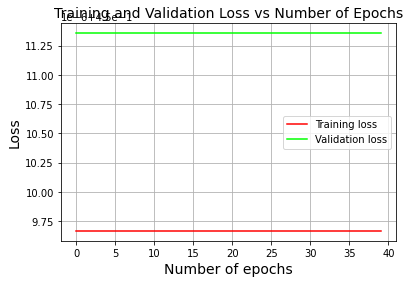

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


training_acc,0.10093
validation_accuracy,0.09167
training_loss,0.45001
validation cost,0.45001
epoch,41
_runtime,205
_timestamp,1615445308
_step,39


training_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
training_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation cost,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 6m4ubmxw with config:
wandb: 	L2_lamb: 0.0005
wandb: 	activation_f: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	init_mode: xavier
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 4
wandb: 	num_neurons: 32
wandb: 	optimizer: nadam


lr_0.0001_ac_sigmoid_in_xavier_op_nadam_bs_64_L2_0.0005_ep_10_nn_32_nh_4
Epoch number : 2
Training cost:  0.45002359475443565 	Validation cost: 0.45001842087025273
Epoch number : 4
Training cost:  0.44996114007102767 	Validation cost: 0.4499578864147334
Epoch number : 6
Training cost:  0.4498973115348664 	Validation cost: 0.4498946187991372
Epoch number : 8
Training cost:  0.4498247605409064 	Validation cost: 0.4498227830158441
Epoch number : 10
Training cost:  0.44973653055464613 	Validation cost: 0.4497353309701074

Final training cost: 0.44968331690666513


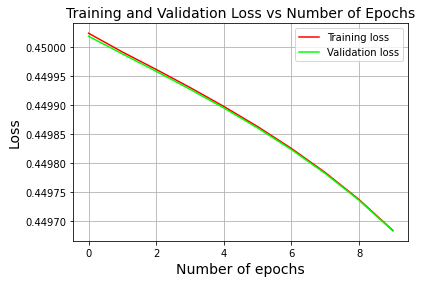

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


training_acc,0.15983
validation_accuracy,0.15933
training_loss,0.44968
validation cost,0.44968
epoch,11
_runtime,51
_timestamp,1615445368
_step,9


training_acc,▂▁▁▅▇██▇▇▇
validation_accuracy,▂▁▁▅███▇▇▇
training_loss,█▇▇▆▅▅▄▃▂▁
validation cost,█▇▇▆▅▅▄▃▂▁
epoch,▁▂▃▃▄▅▆▆▇█
_runtime,▁▂▃▃▄▅▆▇▇█
_timestamp,▁▂▃▃▄▅▆▇▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: 59x5v3n4 with config:
wandb: 	L2_lamb: 0.0005
wandb: 	activation_f: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	init_mode: random_normal
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 5
wandb: 	num_neurons: 64
wandb: 	optimizer: sgd


lr_0.0001_ac_tanh_in_random_normal_op_sgd_bs_16_L2_0.0005_ep_5_nn_64_nh_5
Epoch number : 2
Training cost:  0.4500000239129272 	Validation cost: 0.45000032230238884
Epoch number : 4
Training cost:  0.45000001440890963 	Validation cost: 0.45000040838764305
Epoch number : 6
Training cost:  0.4500000050198691 	Validation cost: 0.4500004940094584

Final training cost: 0.4500000050198691


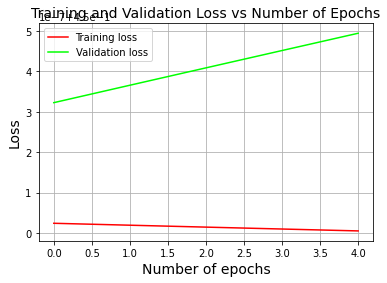

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


training_acc,0.10093
validation_accuracy,0.09167
training_loss,0.45
validation cost,0.45
epoch,6
_runtime,61
_timestamp,1615445439
_step,4


training_acc,▁▁▁▁▁
validation_accuracy,▁▁▁▁▁
training_loss,▁▁▁▁▁
validation cost,▁▃▅▇█
epoch,▁▃▅▆█
_runtime,▁▃▅▆█
_timestamp,▁▃▅▆█
_step,▁▃▅▆█


wandb: Agent Starting Run: smwrv1nm with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_f: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	init_mode: xavier
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 5
wandb: 	num_neurons: 128
wandb: 	optimizer: nadam


lr_0.0001_ac_relu_in_xavier_op_nadam_bs_64_L2_0.5_ep_10_nn_128_nh_5
Epoch number : 2
Training cost:  0.23146396333448058 	Validation cost: 0.24826758078565184
Epoch number : 4
Training cost:  0.2176228084909937 	Validation cost: 0.22709779032425229
Epoch number : 6
Training cost:  nan 	Validation cost: nan
Epoch number : 8
Training cost:  nan 	Validation cost: nan
Epoch number : 10
Training cost:  nan 	Validation cost: nan

Final training cost: nan


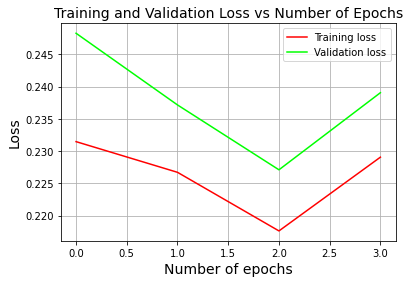

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


training_acc,0.10006
validation_accuracy,0.0995
training_loss,nan
validation cost,nan
epoch,11
_runtime,141
_timestamp,1615445590
_step,9


training_acc,▇▇██▁▁▁▁▁▁
validation_accuracy,▇▇██▁▁▁▁▁▁
training_loss,█▆▁▇
validation cost,█▄▁▅
epoch,▁▂▃▃▄▅▆▆▇█
_runtime,▁▂▃▃▄▅▆▆▇█
_timestamp,▁▂▃▃▄▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: 1ij748q7 with config:
wandb: 	L2_lamb: 0
wandb: 	activation_f: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	init_mode: random_uniform
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 5
wandb: 	num_neurons: 32
wandb: 	optimizer: momentum


lr_0.0001_ac_relu_in_random_uniform_op_momentum_bs_64_L2_0_ep_10_nn_32_nh_5
Epoch number : 2
Training cost:  0.44999991969907405 	Validation cost: 0.4499999291005379
Epoch number : 4
Training cost:  0.4499999170943938 	Validation cost: 0.4499999506082076
Epoch number : 6
Training cost:  0.44999991449702975 	Validation cost: 0.4499999720868271
Epoch number : 8
Training cost:  0.44999991190695915 	Validation cost: 0.4499999935364286
Epoch number : 10
Training cost:  0.4499999093241603 	Validation cost: 0.45000001495704395

Final training cost: 0.4499999080354812


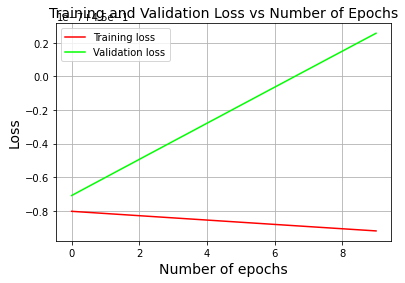

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


training_acc,0.10093
validation_accuracy,0.09167
training_loss,0.45
validation cost,0.45
epoch,11
_runtime,32
_timestamp,1615445631
_step,9


training_acc,▄█▄▁▁▁▁▁▁▁
validation_accuracy,▅█▄▁▁▁▁▁▁▁
training_loss,█████▁▁▁▁▁
validation cost,▁▁▃▃▃▆▆███
epoch,▁▂▃▃▄▅▆▆▇█
_runtime,▁▂▃▃▄▅▆▆▇█
_timestamp,▁▂▃▃▄▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: aw29nf74 with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_f: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 40
wandb: 	init_mode: random_uniform
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 4
wandb: 	num_neurons: 64
wandb: 	optimizer: nestorov


lr_0.0001_ac_tanh_in_random_uniform_op_nestorov_bs_32_L2_0.5_ep_40_nn_64_nh_4
Epoch number : 2
Training cost:  0.45001251928974956 	Validation cost: 0.45009053024441886
Epoch number : 4
Training cost:  0.45001251928974956 	Validation cost: 0.45009053024441886
Epoch number : 6
Training cost:  0.45001251928974956 	Validation cost: 0.45009053024441886
Epoch number : 8
Training cost:  0.45001251928974956 	Validation cost: 0.45009053024441886
Epoch number : 10
Training cost:  0.45001251928974956 	Validation cost: 0.45009053024441886
Epoch number : 12
Training cost:  0.45001251928974956 	Validation cost: 0.45009053024441886
Epoch number : 14
Training cost:  0.45001251928974956 	Validation cost: 0.45009053024441886
Epoch number : 16
Training cost:  0.45001251928974956 	Validation cost: 0.45009053024441886
Epoch number : 18
Training cost:  0.45001251928974956 	Validation cost: 0.45009053024441886
Epoch number : 20
Training cost:  0.45001251928974956 	Validation cost: 0.45009053024441886
Epoch 

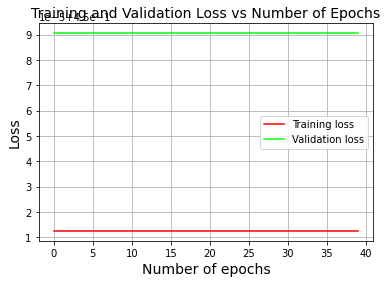

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


training_acc,0.09985
validation_accuracy,0.10133
training_loss,0.45001
validation cost,0.45009
epoch,41
_runtime,283
_timestamp,1615445923
_step,39


training_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
training_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation cost,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: nd2deebm with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_f: sigmoid
wandb: 	batch_size: 256
wandb: 	epochs: 20
wandb: 	init_mode: random_normal
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 4
wandb: 	num_neurons: 128
wandb: 	optimizer: nestorov


lr_0.0001_ac_sigmoid_in_random_normal_op_nestorov_bs_256_L2_0.5_ep_20_nn_128_nh_4
Epoch number : 2
Training cost:  0.4502236013952677 	Validation cost: 0.4508081696387928
Epoch number : 4
Training cost:  0.4502236013952677 	Validation cost: 0.4508081696387928
Epoch number : 6
Training cost:  0.4502236013952677 	Validation cost: 0.4508081696387928
Epoch number : 8
Training cost:  0.4502236013952677 	Validation cost: 0.4508081696387928
Epoch number : 10
Training cost:  0.4502236013952677 	Validation cost: 0.4508081696387928
Epoch number : 12
Training cost:  0.4502236013952677 	Validation cost: 0.4508081696387928
Epoch number : 14
Training cost:  0.4502236013952677 	Validation cost: 0.4508081696387928
Epoch number : 16
Training cost:  0.4502236013952677 	Validation cost: 0.4508081696387928
Epoch number : 18
Training cost:  0.4502236013952677 	Validation cost: 0.4508081696387928
Epoch number : 20
Training cost:  0.4502236013952677 	Validation cost: 0.4508081696387928

Final training cost: 

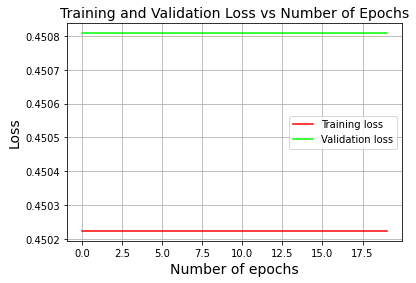

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


training_acc,0.10024
validation_accuracy,0.09783
training_loss,0.45022
validation cost,0.45081
epoch,21
_runtime,215
_timestamp,1615446147
_step,19


training_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
training_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation cost,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_runtime,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_timestamp,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Agent Starting Run: 4q5ctqz1 with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_f: relu
wandb: 	batch_size: 512
wandb: 	epochs: 40
wandb: 	init_mode: random_normal
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 3
wandb: 	num_neurons: 64
wandb: 	optimizer: RMSprop


lr_0.0001_ac_relu_in_random_normal_op_RMSprop_bs_512_L2_0.5_ep_40_nn_64_nh_3
Epoch number : 2
Training cost:  0.45000395955580386 	Validation cost: 0.4500396146241996
Epoch number : 4
Training cost:  0.4499996565613798 	Validation cost: 0.45000411305574345
Epoch number : 6
Training cost:  0.4499995187702106 	Validation cost: 0.4500057659140426
Epoch number : 8
Training cost:  0.4499994374143715 	Validation cost: 0.45000733248521085
Epoch number : 10
Training cost:  0.4499993833839733 	Validation cost: 0.450008683074308
Epoch number : 12
Training cost:  0.4499993484180449 	Validation cost: 0.45000984513481884
Epoch number : 14
Training cost:  0.4499993266352627 	Validation cost: 0.4500108433327074
Epoch number : 16
Training cost:  0.4499993138663139 	Validation cost: 0.45001169960140436
Epoch number : 18
Training cost:  0.4499993071703867 	Validation cost: 0.450012433287466
Epoch number : 20
Training cost:  0.4499993044856382 	Validation cost: 0.4500130613471476
Epoch number : 22
Traini

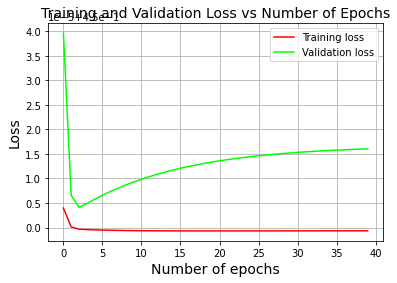

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


training_acc,0.10093
validation_accuracy,0.09167
training_loss,0.45
validation cost,0.45002
epoch,41
_runtime,108
_timestamp,1615446265
_step,39


training_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
training_loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation cost,█▁▁▁▁▁▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: xa4lag20 with config:
wandb: 	L2_lamb: 0
wandb: 	activation_f: sigmoid
wandb: 	batch_size: 256
wandb: 	epochs: 20
wandb: 	init_mode: xavier
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 3
wandb: 	num_neurons: 32
wandb: 	optimizer: momentum


lr_0.0001_ac_sigmoid_in_xavier_op_momentum_bs_256_L2_0_ep_20_nn_32_nh_3
Epoch number : 2
Training cost:  0.46738707491692016 	Validation cost: 0.46722887196259116
Epoch number : 4
Training cost:  0.4671728417677545 	Validation cost: 0.4670182647192913
Epoch number : 6
Training cost:  0.46696447333694685 	Validation cost: 0.46681334621610876
Epoch number : 8
Training cost:  0.4667617027356154 	Validation cost: 0.46661385767971897
Epoch number : 10
Training cost:  0.46656427859881483 	Validation cost: 0.4664195554550628
Epoch number : 12
Training cost:  0.4663719640205978 	Validation cost: 0.46623020996303055
Epoch number : 14
Training cost:  0.46618453557215167 	Validation cost: 0.4660456047398324
Epoch number : 16
Training cost:  0.4660017823958475 	Validation cost: 0.4658655355509752
Epoch number : 18
Training cost:  0.4658235053686901 	Validation cost: 0.4656898095734299
Epoch number : 20
Training cost:  0.4656495163292775 	Validation cost: 0.4655182446401709

Final training cost: 0.

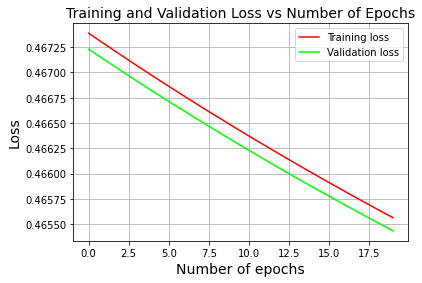

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


training_acc,0.0995
validation_accuracy,0.1045
training_loss,0.46556
validation cost,0.46543
epoch,21
_runtime,59
_timestamp,1615446333
_step,19


training_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
training_loss,██▇▇▆▆▆▅▅▄▄▄▃▃▃▂▂▂▁▁
validation cost,██▇▇▆▆▆▅▅▄▄▄▃▃▃▂▂▂▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_runtime,▁▁▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇██
_timestamp,▁▁▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Agent Starting Run: rdkfzafg with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_f: sigmoid
wandb: 	batch_size: 512
wandb: 	epochs: 10
wandb: 	init_mode: random_normal
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 3
wandb: 	num_neurons: 128
wandb: 	optimizer: nestorov


lr_0.001_ac_sigmoid_in_random_normal_op_nestorov_bs_512_L2_0.5_ep_10_nn_128_nh_3
Epoch number : 2
Training cost:  0.450199778311538 	Validation cost: 0.4507151331896143
Epoch number : 4
Training cost:  0.450199778311538 	Validation cost: 0.4507151331896143
Epoch number : 6
Training cost:  0.450199778311538 	Validation cost: 0.4507151331896143
Epoch number : 8
Training cost:  0.450199778311538 	Validation cost: 0.4507151331896143
Epoch number : 10
Training cost:  0.450199778311538 	Validation cost: 0.4507151331896143

Final training cost: 0.450199778311538


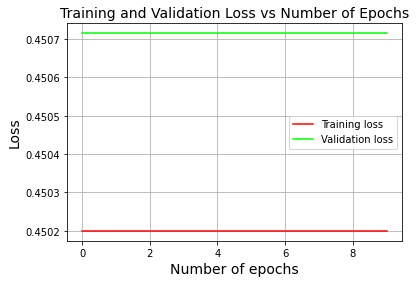

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


training_acc,0.10006
validation_accuracy,0.0995
training_loss,0.4502
validation cost,0.45072
epoch,11
_runtime,86
_timestamp,1615446428
_step,9


training_acc,▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▁▁▁▁▁▁▁▁▁
training_loss,▁▁▁▁▁▁▁▁▁▁
validation cost,▁▁▁▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
_runtime,▁▂▃▃▄▅▆▆▇█
_timestamp,▁▂▃▃▄▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: 2j8tglsp with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_f: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 40
wandb: 	init_mode: xavier
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 3
wandb: 	num_neurons: 128
wandb: 	optimizer: momentum


lr_0.0001_ac_sigmoid_in_xavier_op_momentum_bs_64_L2_0.5_ep_40_nn_128_nh_3
Epoch number : 2
Training cost:  0.4664611448270401 	Validation cost: 0.484667707616663
Epoch number : 4
Training cost:  0.46443949678191987 	Validation cost: 0.4826758129067507
Epoch number : 6
Training cost:  0.46296116205839116 	Validation cost: 0.4812047495914634
Epoch number : 8
Training cost:  0.46182084578661675 	Validation cost: 0.4800564337911519
Epoch number : 10
Training cost:  0.46090458511440013 	Validation cost: 0.4791214183318483
Epoch number : 12
Training cost:  0.46014461121957745 	Validation cost: 0.4783349049751495
Epoch number : 14
Training cost:  0.45949835123729377 	Validation cost: 0.4776563540365586
Epoch number : 16
Training cost:  0.45893782753641016 	Validation cost: 0.4770592250133432
Epoch number : 18
Training cost:  0.4584439386823969 	Validation cost: 0.4765254594592163
Epoch number : 20
Training cost:  0.45800320293346075 	Validation cost: 0.47604234923783145
Epoch number : 22
Trai

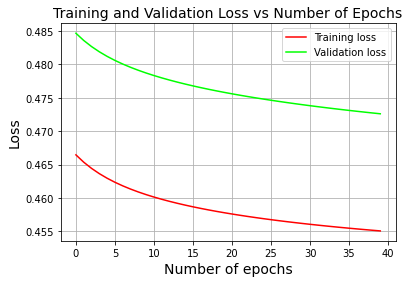

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


training_acc,0.03952
validation_accuracy,0.04583
training_loss,0.45508
validation cost,0.47261
epoch,41
_runtime,473
_timestamp,1615446910
_step,39


training_acc,████████████████████████████▇▇▇▆▅▄▄▃▂▂▁▁
validation_accuracy,█████████████████████████████▇▆▆▅▅▄▃▂▂▁▁
training_loss,█▇▇▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
validation cost,█▇▇▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: yl9ldj7j with config:
wandb: 	L2_lamb: 0
wandb: 	activation_f: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 40
wandb: 	init_mode: xavier
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 4
wandb: 	num_neurons: 128
wandb: 	optimizer: adam


lr_0.001_ac_tanh_in_xavier_op_adam_bs_32_L2_0_ep_40_nn_128_nh_4
Epoch number : 2
Training cost:  0.11427745077129373 	Validation cost: 0.11924270336741616
Epoch number : 4
Training cost:  0.0991265025179296 	Validation cost: 0.1050697631135584
Epoch number : 6
Training cost:  0.08973899399396898 	Validation cost: 0.09994180026700142
Epoch number : 8
Training cost:  0.0836162261585525 	Validation cost: 0.0950343565743161
Epoch number : 10
Training cost:  0.0809611311761293 	Validation cost: 0.09505856907712293
Epoch number : 12
Training cost:  0.07593649813159266 	Validation cost: 0.08983909651060772
Epoch number : 14
Training cost:  0.078231866057311 	Validation cost: 0.09395070591984936
Epoch number : 16
Training cost:  0.07925294832848488 	Validation cost: 0.09576467975489264
Epoch number : 18
Training cost:  0.07522746251539682 	Validation cost: 0.09230732603241004
Epoch number : 20
Training cost:  0.0807201312956204 	Validation cost: 0.09326768076714863
Epoch number : 22
Training c

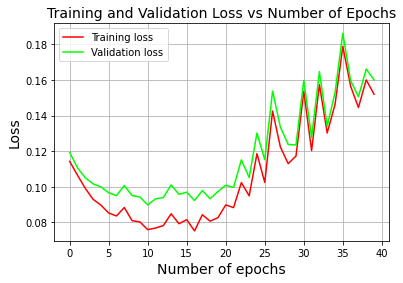

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


training_acc,0.79211
validation_accuracy,0.78283
training_loss,0.15191
validation cost,0.16001
epoch,41
_runtime,993
_timestamp,1615447912
_step,39


training_acc,▅▆▇▇▇▇▇▇█████▇███▇██▇▇▆▇▅▆▄▅▆▅▃▅▃▄▄▁▃▄▃▄
validation_accuracy,▆▇▇▇▇▇█▇███▇█▇▇▇█▇█▇▇▇▆▇▅▆▄▅▆▆▃▅▃▅▄▁▃▄▃▄
training_loss,▄▃▃▂▂▂▂▂▁▁▁▁▁▂▁▁▁▂▁▂▂▂▃▂▄▃▆▄▄▄▆▄▇▅▆█▆▆▇▆
validation cost,▃▃▂▂▂▁▁▂▁▁▁▁▁▂▁▂▁▂▁▂▂▂▃▂▄▃▆▄▃▃▆▄▆▄▆█▆▅▇▆
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 24txpaka with config:
wandb: 	L2_lamb: 0
wandb: 	activation_f: relu
wandb: 	batch_size: 128
wandb: 	epochs: 20
wandb: 	init_mode: xavier
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 3
wandb: 	num_neurons: 32
wandb: 	optimizer: sgd


lr_0.0001_ac_relu_in_xavier_op_sgd_bs_128_L2_0_ep_20_nn_32_nh_3
Epoch number : 2
Training cost:  0.45359987766863524 	Validation cost: 0.4536390366407447
Epoch number : 4
Training cost:  0.452744569803639 	Validation cost: 0.4528067760810923
Epoch number : 6
Training cost:  0.45197924438568776 	Validation cost: 0.4520666642509171
Epoch number : 8
Training cost:  0.4512806652346508 	Validation cost: 0.45139582751127083
Epoch number : 10
Training cost:  0.45063718581055606 	Validation cost: 0.4507733100717049
Epoch number : 12
Training cost:  0.4500385393311548 	Validation cost: 0.45019224393031854
Epoch number : 14
Training cost:  0.44947659974799353 	Validation cost: 0.4496455649132294
Epoch number : 16
Training cost:  0.44894455493190055 	Validation cost: 0.44912950351876507
Epoch number : 18
Training cost:  0.4484378411062443 	Validation cost: 0.44863632810703885
Epoch number : 20
Training cost:  0.447952930547242 	Validation cost: 0.4481597905317743

Final training cost: 0.447717418

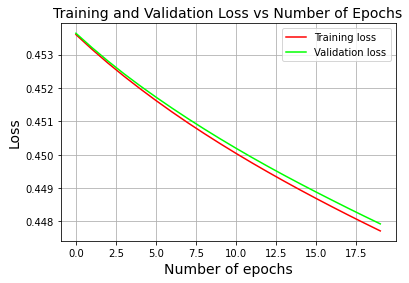

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


training_acc,0.14965
validation_accuracy,0.14917
training_loss,0.44772
validation cost,0.44793
epoch,21
_runtime,40
_timestamp,1615447961
_step,19


training_acc,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▇▇██
validation_accuracy,▁▁▂▂▂▂▂▃▄▄▅▅▅▆▆▆▇▇██
training_loss,█▇▇▇▆▆▅▅▄▄▄▃▃▃▂▂▂▂▁▁
validation cost,█▇▇▇▆▆▅▅▄▄▄▃▃▃▂▂▂▂▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_runtime,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_timestamp,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Agent Starting Run: hduqel2l with config:
wandb: 	L2_lamb: 0
wandb: 	activation_f: relu
wandb: 	batch_size: 16
wandb: 	epochs: 20
wandb: 	init_mode: random_normal
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 4
wandb: 	num_neurons: 128
wandb: 	optimizer: sgd


lr_0.0001_ac_relu_in_random_normal_op_sgd_bs_16_L2_0_ep_20_nn_128_nh_4
Epoch number : 2
Training cost:  0.4499999154865503 	Validation cost: 0.449999980458684
Epoch number : 4
Training cost:  0.44999986673056175 	Validation cost: 0.45000002828055563
Epoch number : 6
Training cost:  0.4499998317895492 	Validation cost: 0.45000008719184187
Epoch number : 8
Training cost:  0.44999980080972474 	Validation cost: 0.4500001494070067
Epoch number : 10
Training cost:  0.4499997823924576 	Validation cost: 0.45000022467589784
Epoch number : 12
Training cost:  0.4499997691754092 	Validation cost: 0.45000030472406477
Epoch number : 14
Training cost:  0.44999975687285537 	Validation cost: 0.45000038515621155
Epoch number : 16
Training cost:  0.4499997439115333 	Validation cost: 0.45000046422835205
Epoch number : 18
Training cost:  0.4499997267331469 	Validation cost: 0.45000053800453427
Epoch number : 20
Training cost:  0.4499997072123287 	Validation cost: 0.4500006091863823

Final training cost: 0.

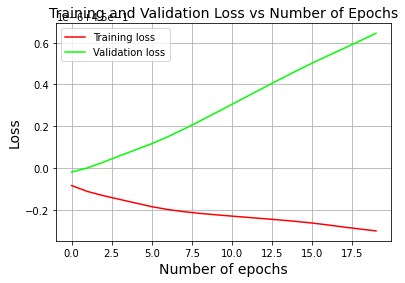

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


training_acc,0.10093
validation_accuracy,0.09167
training_loss,0.45
validation cost,0.45
epoch,21
_runtime,319
_timestamp,1615448289
_step,19


training_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
training_loss,█▇▆▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▁
validation cost,▁▁▁▂▂▂▃▃▄▄▅▅▅▆▆▆▇▇██
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_runtime,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_timestamp,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Agent Starting Run: etuwtbgm with config:
wandb: 	L2_lamb: 0.0005
wandb: 	activation_f: sigmoid
wandb: 	batch_size: 256
wandb: 	epochs: 40
wandb: 	init_mode: random_uniform
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 3
wandb: 	num_neurons: 32
wandb: 	optimizer: RMSprop


lr_0.0001_ac_sigmoid_in_random_uniform_op_RMSprop_bs_256_L2_0.0005_ep_40_nn_32_nh_3
Epoch number : 2
Training cost:  0.45000013660452587 	Validation cost: 0.450007343314343
Epoch number : 4
Training cost:  0.44999991707627934 	Validation cost: 0.4500089213544749
Epoch number : 6
Training cost:  0.4499998653946119 	Validation cost: 0.4500090867452934
Epoch number : 8
Training cost:  0.449999812620633 	Validation cost: 0.4500092093861233
Epoch number : 10
Training cost:  0.4499997487276594 	Validation cost: 0.45000932045546127
Epoch number : 12
Training cost:  0.449999663957573 	Validation cost: 0.45000942277869305
Epoch number : 14
Training cost:  0.4499995409550922 	Validation cost: 0.4500095140000634
Epoch number : 16
Training cost:  0.4499993416845061 	Validation cost: 0.450009581853074
Epoch number : 18
Training cost:  0.44999896867715167 	Validation cost: 0.45000958262233165
Epoch number : 20
Training cost:  0.4499981211692328 	Validation cost: 0.4500093430668149
Epoch number : 22


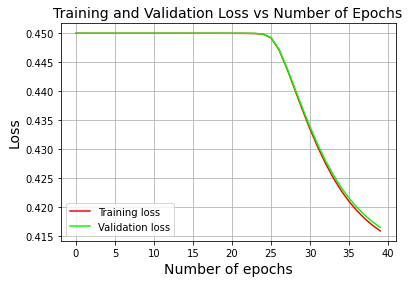

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


training_acc,0.20057
validation_accuracy,0.189
training_loss,0.41594
validation cost,0.41654
epoch,41
_runtime,113
_timestamp,1615448411
_step,39


training_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁██████████████
validation_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁██████████████
training_loss,██████████████████████████▇▇▆▅▅▄▃▃▂▂▂▁▁▁
validation cost,██████████████████████████▇▇▆▅▅▄▃▃▂▂▂▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Sweep Agent: Waiting for job.
502 response executing GraphQL.

<html><head>
<meta http-equiv="content-type" content="text/html;charset=utf-8">
<title>502 Server Error</title>
</head>
<body text=#000000 bgcolor=#ffffff>
<h1>Error: Server Error</h1>
<h2>The server encountered a temporary error and could not complete your request.<p>Please try again in 30 seconds.</h2>
<h2></h2>
</body></html>

wandb: Job received.
wandb: Agent Starting Run: iat043v2 with config:
wandb: 	L2_lamb: 0
wandb: 	activation_f: tanh
wandb: 	batch_size: 256
wandb: 	epochs: 5
wandb: 	init_mode: xavier
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 3
wandb: 	num_neurons: 64
wandb: 	optimizer: adam


lr_0.0001_ac_tanh_in_xavier_op_adam_bs_256_L2_0_ep_5_nn_64_nh_3
Epoch number : 2
Training cost:  0.2629653906749314 	Validation cost: 0.26657666734761976
Epoch number : 4
Training cost:  0.16262547185769838 	Validation cost: 0.1660730153007208
Epoch number : 6
Training cost:  0.13595917284373707 	Validation cost: 0.13902531861197456

Final training cost: 0.13595917284373707


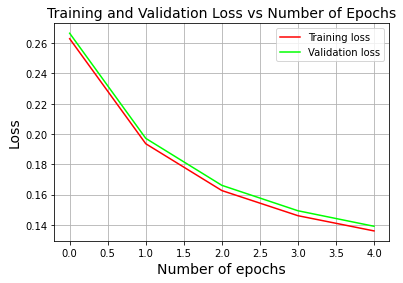

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


training_acc,0.8155
validation_accuracy,0.8085
training_loss,0.13596
validation cost,0.13903
epoch,6
_runtime,31
_timestamp,1615448491
_step,4


training_acc,▁▅▇██
validation_accuracy,▁▅▇██
training_loss,█▄▂▂▁
validation cost,█▄▂▂▁
epoch,▁▃▅▆█
_runtime,▁▃▅▆█
_timestamp,▁▃▅▆█
_step,▁▃▅▆█


wandb: Agent Starting Run: 44ah420v with config:
wandb: 	L2_lamb: 0
wandb: 	activation_f: relu
wandb: 	batch_size: 128
wandb: 	epochs: 10
wandb: 	init_mode: random_uniform
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 3
wandb: 	num_neurons: 32
wandb: 	optimizer: adam


lr_0.0001_ac_relu_in_random_uniform_op_adam_bs_128_L2_0_ep_10_nn_32_nh_3
Epoch number : 2
Training cost:  0.4499048742068197 	Validation cost: 0.4498992792854272
Epoch number : 4
Training cost:  0.4486295518685151 	Validation cost: 0.44854380745629024
Epoch number : 6
Training cost:  0.43912633458463884 	Validation cost: 0.43850498463460985
Epoch number : 8
Training cost:  0.41650680726736666 	Validation cost: 0.4159108258997275
Epoch number : 10
Training cost:  0.4094508829161982 	Validation cost: 0.4095812660652241

Final training cost: 0.4042347531560996


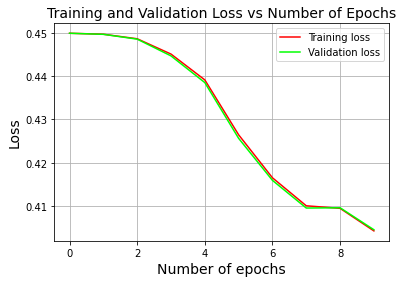

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


training_acc,0.21674
validation_accuracy,0.21183
training_loss,0.40423
validation cost,0.4045
epoch,11
_runtime,25
_timestamp,1615448527
_step,9


training_acc,▂▁▁▁▃▅▇█▇▆
validation_accuracy,▂▁▁▁▃▅██▇▆
training_loss,███▇▆▄▃▂▂▁
validation cost,███▇▆▄▃▂▂▁
epoch,▁▂▃▃▄▅▆▆▇█
_runtime,▁▂▃▃▄▅▆▇▇█
_timestamp,▁▂▃▃▄▅▆▇▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: 58jfyicf with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_f: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 20
wandb: 	init_mode: xavier
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 3
wandb: 	num_neurons: 64
wandb: 	optimizer: momentum


lr_0.0001_ac_sigmoid_in_xavier_op_momentum_bs_64_L2_0.5_ep_20_nn_64_nh_3
Epoch number : 2
Training cost:  0.46851586351853136 	Validation cost: 0.4789441761903241
Epoch number : 4
Training cost:  0.46724542526235524 	Validation cost: 0.47764726722860434
Epoch number : 6
Training cost:  0.46615350892446616 	Validation cost: 0.4765273001073324
Epoch number : 8
Training cost:  0.46520031997416716 	Validation cost: 0.4755446882499217
Epoch number : 10
Training cost:  0.46435715682316253 	Validation cost: 0.47467092910279624
Epoch number : 12
Training cost:  0.46360285913811405 	Validation cost: 0.47388504731108577
Epoch number : 14
Training cost:  0.4629215232301261 	Validation cost: 0.4731713077881778
Epoch number : 16
Training cost:  0.46230099022218224 	Validation cost: 0.4725177032505986
Epoch number : 18
Training cost:  0.46173182025437126 	Validation cost: 0.47191492877476765
Epoch number : 20
Training cost:  0.46120658098872364 	Validation cost: 0.47135567120025856

Final training c

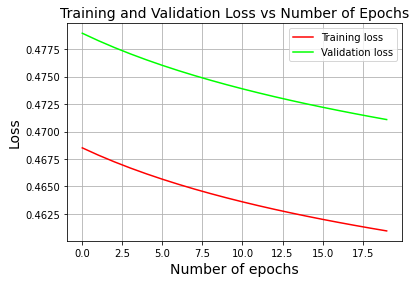

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


training_acc,0.10006
validation_accuracy,0.0995
training_loss,0.46096
validation cost,0.47109
epoch,21
_runtime,128
_timestamp,1615448665
_step,19


training_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
training_loss,█▇▇▆▆▅▅▅▄▄▃▃▃▃▂▂▂▁▁▁
validation cost,█▇▇▆▆▅▅▅▄▄▃▃▃▃▂▂▂▁▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_runtime,▁▁▂▂▃▃▃▄▄▄▅▅▅▆▆▇▇▇██
_timestamp,▁▁▂▂▃▃▃▄▄▄▅▅▅▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Agent Starting Run: dtmpj5w8 with config:
wandb: 	L2_lamb: 0.0005
wandb: 	activation_f: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 40
wandb: 	init_mode: random_normal
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 4
wandb: 	num_neurons: 128
wandb: 	optimizer: nadam


lr_0.001_ac_sigmoid_in_random_normal_op_nadam_bs_16_L2_0.0005_ep_40_nn_128_nh_4
Epoch number : 2
Training cost:  0.4571805616541008 	Validation cost: 0.4573147131363571
Epoch number : 4
Training cost:  0.4572639627033701 	Validation cost: 0.45749664470905194
Epoch number : 6
Training cost:  0.4572648664689013 	Validation cost: 0.4576997982772188
Epoch number : 8
Training cost:  0.45727638777382706 	Validation cost: 0.45799095541591117
Epoch number : 10
Training cost:  0.4572968444216285 	Validation cost: 0.45835157418753336
Epoch number : 12
Training cost:  0.45732443380803645 	Validation cost: 0.4587655843608193
Epoch number : 14
Training cost:  nan 	Validation cost: nan
Epoch number : 16
Training cost:  nan 	Validation cost: nan
Epoch number : 18
Training cost:  nan 	Validation cost: nan
Epoch number : 20
Training cost:  nan 	Validation cost: nan
Epoch number : 22
Training cost:  nan 	Validation cost: nan
Epoch number : 24
Training cost:  nan 	Validation cost: nan
Epoch number : 26
T

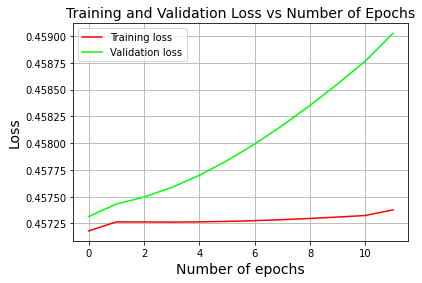

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


training_acc,0.10006
validation_accuracy,0.0995
training_loss,nan
validation cost,nan
epoch,41
_runtime,1534
_timestamp,1615450209
_step,39


training_acc,▁▁▁▁▁▁▁▁▁▁▁▁████████████████████████████
validation_accuracy,████████████▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
training_loss,▁▄▄▄▄▄▄▅▅▆▆█
validation cost,▁▁▂▂▃▃▄▄▅▆▇█
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 4z7esk54 with config:
wandb: 	L2_lamb: 0.0005
wandb: 	activation_f: relu
wandb: 	batch_size: 128
wandb: 	epochs: 40
wandb: 	init_mode: random_uniform
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 5
wandb: 	num_neurons: 32
wandb: 	optimizer: sgd


lr_0.0001_ac_relu_in_random_uniform_op_sgd_bs_128_L2_0.0005_ep_40_nn_32_nh_5
Epoch number : 2
Training cost:  0.4499999249044816 	Validation cost: 0.44999996445332996
Epoch number : 4
Training cost:  0.44999992360251784 	Validation cost: 0.4499999751958838
Epoch number : 6
Training cost:  0.4499999223023822 	Validation cost: 0.44999998593118146
Epoch number : 8
Training cost:  0.4499999210040721 	Validation cost: 0.44999999665922663
Epoch number : 10
Training cost:  0.4499999197075846 	Validation cost: 0.45000000738002344
Epoch number : 12
Training cost:  0.4499999184129169 	Validation cost: 0.450000018093576
Epoch number : 14
Training cost:  0.44999991712006626 	Validation cost: 0.45000002879988815
Epoch number : 16
Training cost:  0.44999991582903015 	Validation cost: 0.4500000394989637
Epoch number : 18
Training cost:  0.4499999145398056 	Validation cost: 0.4500000501908072
Epoch number : 20
Training cost:  0.44999991325238986 	Validation cost: 0.4500000608754222
Epoch number : 22
T

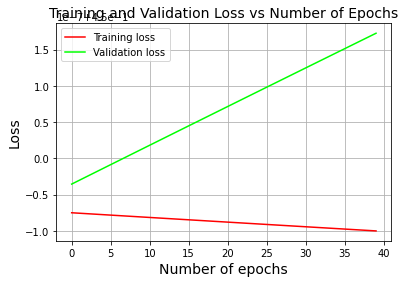

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


training_acc,0.10093
validation_accuracy,0.09167
training_loss,0.45
validation cost,0.45
epoch,41
_runtime,88
_timestamp,1615450307
_step,39


training_acc,▁▃██▆▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▂▄██▆▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
training_loss,██████████████████▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation cost,▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 7osgayu7 with config:
wandb: 	L2_lamb: 0
wandb: 	activation_f: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 20
wandb: 	init_mode: random_uniform
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 3
wandb: 	num_neurons: 128
wandb: 	optimizer: nadam


lr_0.001_ac_tanh_in_random_uniform_op_nadam_bs_16_L2_0_ep_20_nn_128_nh_3
Epoch number : 2
Training cost:  0.15123829870042918 	Validation cost: 0.15634230108798128
Epoch number : 4
Training cost:  0.1331718430596101 	Validation cost: 0.13735137385652574
Epoch number : 6
Training cost:  0.11454144525817644 	Validation cost: 0.12041471994695248
Epoch number : 8
Training cost:  0.11927513584702476 	Validation cost: 0.12472701965693735
Epoch number : 10
Training cost:  0.11995981971574513 	Validation cost: 0.130111093910777
Epoch number : 12
Training cost:  0.17478242761282015 	Validation cost: 0.1785022918578126
Epoch number : 14
Training cost:  0.1339773337184482 	Validation cost: 0.1397822601116391
Epoch number : 16
Training cost:  0.15380847000447134 	Validation cost: 0.1574963573148188
Epoch number : 18
Training cost:  0.16639966513172827 	Validation cost: 0.1709767983354581
Epoch number : 20
Training cost:  0.17506763204748582 	Validation cost: 0.18027286936790696

Final training cos

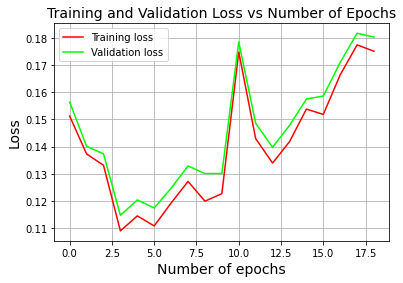

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


training_acc,0.10006
validation_accuracy,0.0995
training_loss,nan
validation cost,nan
epoch,21
_runtime,704
_timestamp,1615451020
_step,19


training_acc,▇█████████▇▇███▇▇▇▇▁
validation_accuracy,▇█████████▇▇███▇▇▇▇▁
training_loss,▅▄▃▁▂▁▂▃▂▂█▄▄▄▆▅▇██
validation cost,▅▄▃▁▂▁▂▃▃▃█▅▄▄▅▆▇██
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_runtime,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_timestamp,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: Agent Starting Run: 2ftyeu6t with config:
wandb: 	L2_lamb: 0.0005
wandb: 	activation_f: relu
wandb: 	batch_size: 256
wandb: 	epochs: 10
wandb: 	init_mode: random_uniform
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 5
wandb: 	num_neurons: 64
wandb: 	optimizer: sgd


lr_0.0001_ac_relu_in_random_uniform_op_sgd_bs_256_L2_0.0005_ep_10_nn_64_nh_5
Epoch number : 2
Training cost:  0.4499981480294873 	Validation cost: 0.44999809030668425
Epoch number : 4
Training cost:  0.4499981193847648 	Validation cost: 0.4499980659480746
Epoch number : 6
Training cost:  0.44999809074030883 	Validation cost: 0.44999804158785695
Epoch number : 8
Training cost:  0.44999806209611376 	Validation cost: 0.44999801722602645
Epoch number : 10
Training cost:  0.44999803345217415 	Validation cost: 0.4499979928625782

Final training cost: 0.4499980191302985


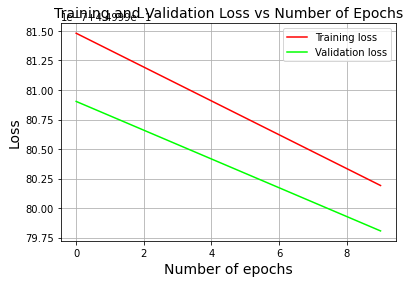

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


training_acc,0.10006
validation_accuracy,0.0995
training_loss,0.45
validation cost,0.45
epoch,11
_runtime,37
_timestamp,1615451067
_step,9


training_acc,▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▁▁▁▁▁▁▁▁▁
training_loss,██▆▆▅▅▃▃▁▁
validation cost,███▆▆▃▃▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
_runtime,▁▂▃▃▄▅▆▆▇█
_timestamp,▁▂▃▃▄▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: 39us1vdm with config:
wandb: 	L2_lamb: 0
wandb: 	activation_f: relu
wandb: 	batch_size: 128
wandb: 	epochs: 40
wandb: 	init_mode: random_normal
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 4
wandb: 	num_neurons: 32
wandb: 	optimizer: nadam


lr_0.0001_ac_relu_in_random_normal_op_nadam_bs_128_L2_0_ep_40_nn_32_nh_4
Epoch number : 2
Training cost:  0.44999994629696133 	Validation cost: 0.45000055642855014
Epoch number : 4
Training cost:  0.4499997007287981 	Validation cost: 0.45000398905726136
Epoch number : 6
Training cost:  0.44999956058116747 	Validation cost: 0.45000686440037113
Epoch number : 8
Training cost:  0.4499994946589534 	Validation cost: 0.45000882342937726
Epoch number : 10
Training cost:  0.449999463520353 	Validation cost: 0.4500100775226402
Epoch number : 12
Training cost:  0.4499994477740186 	Validation cost: 0.45001085917745887
Epoch number : 14
Training cost:  0.44999943967183803 	Validation cost: 0.45001134043631646
Epoch number : 16
Training cost:  0.4499994352880178 	Validation cost: 0.4500116344750539
Epoch number : 18
Training cost:  0.44999943279820276 	Validation cost: 0.4500118132703093
Epoch number : 20
Training cost:  0.44999943130724634 	Validation cost: 0.45001192168341764
Epoch number : 22
Tr

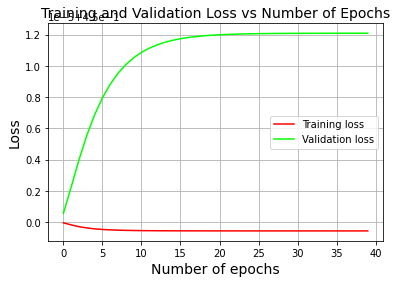

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


training_acc,0.10093
validation_accuracy,0.09167
training_loss,0.45
validation cost,0.45001
epoch,41
_runtime,96
_timestamp,1615451172
_step,39


training_acc,▁▁▁█████████████████████████████████████
validation_accuracy,███▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
training_loss,█▆▅▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation cost,▁▂▃▄▅▅▆▆▇▇▇▇████████████████████████████
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: magwbnsv with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_f: sigmoid
wandb: 	batch_size: 512
wandb: 	epochs: 40
wandb: 	init_mode: random_uniform
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 5
wandb: 	num_neurons: 128
wandb: 	optimizer: sgd


lr_0.0001_ac_sigmoid_in_random_uniform_op_sgd_bs_512_L2_0.5_ep_40_nn_128_nh_5
Epoch number : 2
Training cost:  0.45005024743470307 	Validation cost: 0.4502214589107301
Epoch number : 4
Training cost:  0.45004980095618585 	Validation cost: 0.4502214546751703
Epoch number : 6
Training cost:  0.4500493624273375 	Validation cost: 0.450221454373878
Epoch number : 8
Training cost:  0.45004893170424276 	Validation cost: 0.45022145789915485
Epoch number : 10
Training cost:  0.45004850864565543 	Validation cost: 0.45022146514562983
Epoch number : 12
Training cost:  0.4500480931129432 	Validation cost: 0.4502214760102113
Epoch number : 14
Training cost:  0.4500476849700395 	Validation cost: 0.4502214903920404
Epoch number : 16
Training cost:  0.4500472840833933 	Validation cost: 0.45022150819244494
Epoch number : 18
Training cost:  0.45004689032192136 	Validation cost: 0.4502215293148948
Epoch number : 20
Training cost:  0.4500465035569605 	Validation cost: 0.4502215536649578
Epoch number : 22
T

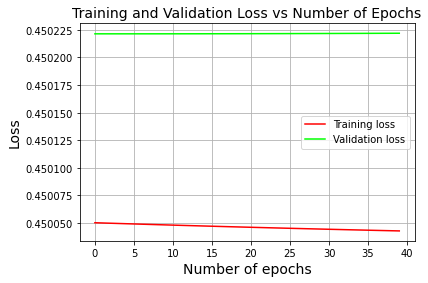

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


training_acc,0.09965
validation_accuracy,0.10317
training_loss,0.45004
validation cost,0.45022
epoch,41
_runtime,494
_timestamp,1615451676
_step,39


training_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
training_loss,███▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
validation cost,▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇██
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: pay3lspg with config:
wandb: 	L2_lamb: 0.0005
wandb: 	activation_f: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 40
wandb: 	init_mode: random_normal
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 4
wandb: 	num_neurons: 64
wandb: 	optimizer: adam


lr_0.0001_ac_sigmoid_in_random_normal_op_adam_bs_16_L2_0.0005_ep_40_nn_64_nh_4
Epoch number : 2
Training cost:  0.4500662860213714 	Validation cost: 0.4500273175787285
Epoch number : 4
Training cost:  0.4500684263125587 	Validation cost: 0.4500293783836095
Epoch number : 6
Training cost:  0.4500733578363567 	Validation cost: 0.45003503312393117
Epoch number : 8
Training cost:  0.45008259370298753 	Validation cost: 0.4500458121025018
Epoch number : 10
Training cost:  0.4500984712510469 	Validation cost: 0.450064811003355
Epoch number : 12
Training cost:  0.4501253015658564 	Validation cost: 0.4500975243503311
Epoch number : 14
Training cost:  0.45016582883219003 	Validation cost: 0.4501472788969504
Epoch number : 16
Training cost:  0.4502060908801701 	Validation cost: 0.4501974022200933
Epoch number : 18
Training cost:  0.45022951585514764 	Validation cost: 0.45022862339790226
Epoch number : 20
Training cost:  0.4502407327529151 	Validation cost: 0.4502463960007102
Epoch number : 22
Tra

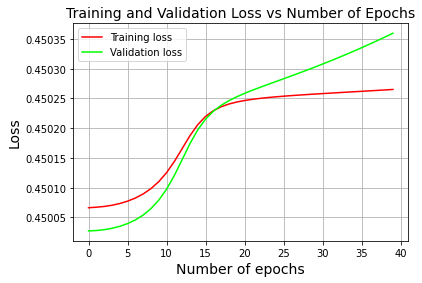

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


training_acc,0.09965
validation_accuracy,0.10317
training_loss,0.45027
validation cost,0.45036
epoch,41
_runtime,766
_timestamp,1615452452
_step,39


training_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
training_loss,▁▁▁▁▁▁▂▂▂▃▃▄▅▅▆▆▇▇▇▇▇▇▇█████████████████
validation cost,▁▁▁▁▁▁▁▂▂▂▂▃▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇████
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 0zt3q5sj with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_f: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 40
wandb: 	init_mode: random_normal
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 3
wandb: 	num_neurons: 128
wandb: 	optimizer: adam


lr_0.001_ac_tanh_in_random_normal_op_adam_bs_16_L2_0.5_ep_40_nn_128_nh_3
Epoch number : 2
Training cost:  0.45003892905451237 	Validation cost: 0.4500271888540889
Epoch number : 4
Training cost:  0.45003893456537497 	Validation cost: 0.45002632221917416
Epoch number : 6
Training cost:  0.4500389341555376 	Validation cost: 0.45002632054225267
Epoch number : 8
Training cost:  0.45003893389971134 	Validation cost: 0.45002632007197585
Epoch number : 10
Training cost:  0.4500389337149254 	Validation cost: 0.4500263197330608
Epoch number : 12
Training cost:  0.4500389335814143 	Validation cost: 0.4500263194881855
Epoch number : 14
Training cost:  0.4500389334849479 	Validation cost: 0.4500263193112525
Epoch number : 16
Training cost:  0.4500389334152466 	Validation cost: 0.45002631918340874
Epoch number : 18
Training cost:  0.4500389333648832 	Validation cost: 0.45002631909103386
Epoch number : 20
Training cost:  0.4500389333284925 	Validation cost: 0.45002631902428686
Epoch number : 22
Trai

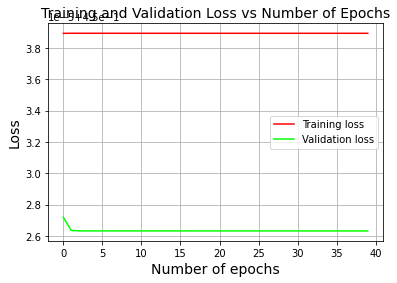

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


training_acc,0.09985
validation_accuracy,0.10133
training_loss,0.45004
validation cost,0.45003
epoch,41
_runtime,1215
_timestamp,1615453676
_step,39


training_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
training_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation cost,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: r5seruat with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_f: tanh
wandb: 	batch_size: 256
wandb: 	epochs: 10
wandb: 	init_mode: random_normal
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 4
wandb: 	num_neurons: 32
wandb: 	optimizer: RMSprop


lr_0.001_ac_tanh_in_random_normal_op_RMSprop_bs_256_L2_0.5_ep_10_nn_32_nh_4
Epoch number : 2
Training cost:  0.44999940881929296 	Validation cost: 0.45000905765856597
Epoch number : 4
Training cost:  0.44999940784333187 	Validation cost: 0.45001258673803995
Epoch number : 6
Training cost:  0.4499994189627368 	Validation cost: 0.4500129954719927
Epoch number : 8
Training cost:  0.44999942063871295 	Validation cost: 0.45001303639680323
Epoch number : 10
Training cost:  0.4499994204967498 	Validation cost: 0.45001304313414453

Final training cost: 0.4499994214247802


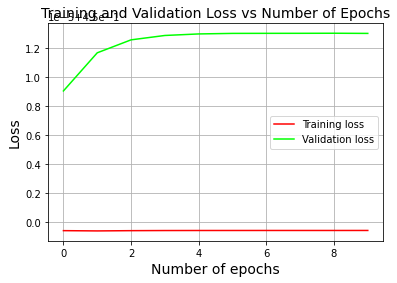

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


training_acc,0.10093
validation_accuracy,0.09167
training_loss,0.45
validation cost,0.45001
epoch,11
_runtime,29
_timestamp,1615453714
_step,9


training_acc,▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▁▁▁▁▁▁▁▁▁
training_loss,█▁████████
validation cost,▁▆▇███████
epoch,▁▂▃▃▄▅▆▆▇█
_runtime,▁▂▃▃▄▅▆▆▇█
_timestamp,▁▂▃▃▄▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: pxhj8blo with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_f: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 40
wandb: 	init_mode: xavier
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 3
wandb: 	num_neurons: 32
wandb: 	optimizer: adam


lr_0.001_ac_tanh_in_xavier_op_adam_bs_32_L2_0.5_ep_40_nn_32_nh_3
Epoch number : 2
Training cost:  0.2671807639788495 	Validation cost: 0.27076033290449675
Epoch number : 4
Training cost:  0.2721379547729959 	Validation cost: 0.27538173415725636
Epoch number : 6
Training cost:  0.287166361045879 	Validation cost: 0.2896725953118433
Epoch number : 8
Training cost:  0.2865752162696922 	Validation cost: 0.28907956946853625
Epoch number : 10
Training cost:  0.28630834505248415 	Validation cost: 0.28881469310994573
Epoch number : 12
Training cost:  0.28620064603030004 	Validation cost: 0.28870888739927447
Epoch number : 14
Training cost:  0.28615648034582625 	Validation cost: 0.2886659365933893
Epoch number : 16
Training cost:  0.2861381029762695 	Validation cost: 0.28864825207577904
Epoch number : 18
Training cost:  0.2861304665949358 	Validation cost: 0.28864099557025946
Epoch number : 20
Training cost:  0.2861273620921664 	Validation cost: 0.28863810032105824
Epoch number : 22
Training co

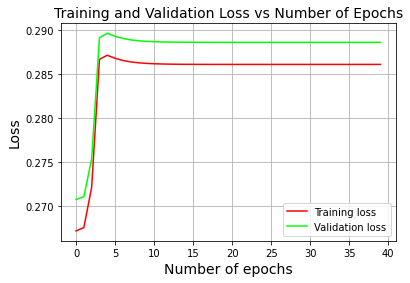

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


training_acc,0.6047
validation_accuracy,0.6
training_loss,0.28613
validation cost,0.28864
epoch,41
_runtime,217
_timestamp,1615453941
_step,39


training_acc,██▇▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
validation_accuracy,▇██▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
training_loss,▁▁▃█████████████████████████████████████
validation cost,▁▁▃█████████████████████████████████████
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: xfkkgb7f with config:
wandb: 	L2_lamb: 0.0005
wandb: 	activation_f: sigmoid
wandb: 	batch_size: 256
wandb: 	epochs: 40
wandb: 	init_mode: xavier
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 4
wandb: 	num_neurons: 32
wandb: 	optimizer: RMSprop


lr_0.0001_ac_sigmoid_in_xavier_op_RMSprop_bs_256_L2_0.0005_ep_40_nn_32_nh_4
Epoch number : 2
Training cost:  0.44969999857640097 	Validation cost: 0.4497273286437498
Epoch number : 4
Training cost:  0.44357812052722645 	Validation cost: 0.4436437894660895
Epoch number : 6
Training cost:  0.4290170737734134 	Validation cost: 0.4291612379648957
Epoch number : 8
Training cost:  0.41346215770275774 	Validation cost: 0.4137257065707459
Epoch number : 10
Training cost:  0.4037831884662441 	Validation cost: 0.40434543433232895
Epoch number : 12
Training cost:  0.39664585273293074 	Validation cost: 0.3976547015462836
Epoch number : 14
Training cost:  0.387895599140113 	Validation cost: 0.3892184009468273
Epoch number : 16
Training cost:  0.3760237536215525 	Validation cost: 0.3775978677302908
Epoch number : 18
Training cost:  0.36360048685498547 	Validation cost: 0.3654611697535196
Epoch number : 20
Training cost:  0.3527264736955149 	Validation cost: 0.35491836254873843


In [ ]:
sweep_config = {
  "name": "CS6910 Assignment 1 - Squared Error Loss",
  "metric": {
      "name":"validation_accuracy",
      "goal": "maximize"
  },
  "method": "random",
  "parameters": {
        "learning_rate": {
            "values": [0.001, 0.0001]
        },
        "activation_f": {
            "values": ["sigmoid", "relu", "tanh"]
        },
        "init_mode": {
            "values": ["xavier", "random_uniform", "random_normal"]
        },
        "optimizer": {
            "values": ["sgd", "momentum", "nestorov", "adam", "nadam", "RMSprop"]
        },
        "batch_size": {
            "values": [16,32,64,128,256,512]
        },
        "epochs": {
            "values": [5, 10, 20, 40]
        },
        "L2_lamb": {
            "values": [0, 0.0005, 0.5]
        },
        "num_neurons": {
            "values": [32, 64, 128]
        },
        "num_hidden": {
            "values": [3, 4, 5]
        }
    }
}

sweep_id = wandb.sweep(sweep_config, entity="ee17b154tony", project="dl_assignment1")
wandb.agent(sweep_id, NN_fit, count=120)

# Training the model with the best combination of hyperparameters

#### Setting Hyperparameters based on wandb results

These are the best choices for hyperparameters chosen using wandb.ai's sweep feature

In [15]:
LEARNING_RATE = 0.0001
ACTIVATION = "tanh"
INITIALIZER = "xavier"
OPTIMIZER = "nadam"
BATCH_SIZE = 16
EPOCHS = 20
L2_lambda = 0.0005
NUM_NEURONS = 64
NUM_HIDDEN = 3

LOSS = 'mse'

#### Training on the full dataset

In [16]:
def NN_best_fit(X_train, y_train_one_hot, learning_rate = 0.001, activation_f = 'tanh', init_mode = 'xavier', 
                optimizer = 'adam', batch_size = 512, loss = 'categorical_crossentropy', epochs = 20, L2_lamb = 0,
                num_neurons = 64, num_hidden = 3):
    """
    This function is used to train the neural network on the full dataset given the best set of hyperparameter values
    """
    #Layer sizes
    layer_dims = [num_features] + [num_neurons]*num_hidden + [num_classes]

    params, previous_updates = initialize_parameters(layer_dims, init_mode) # initialize the parameters and past updates matrices
    
    epoch_cost = []
    
    count = 1
    t = 1 # initialize timestep for Adam optimizer
    v = previous_updates.copy()
    m = previous_updates.copy()
    params_look_ahead = params.copy() # initialization for nestorov
    beta = 0.9
    loss = 'categorical_crossentropy'    

    while count<=epochs:
        count = count + 1 # increment the number of epochs
        for i in range(0, X_train.shape[1], batch_size):
            batch_count = batch_size
            if i + batch_size > X_train.shape[1]: # the last mini-batch might contain fewer than "batch_size" examples
                batch_count = X_train.shape[1] - i + 1

            if optimizer == 'nesterov':
                L = len(params)//2
                for l in range(1, L+1):
                    params_look_ahead["W"+str(l)] = params["W"+str(l)] - beta*previous_updates["W"+str(l)]
                    params_look_ahead["b"+str(l)] = params["b"+str(l)] - beta*previous_updates["b"+str(l)]
                    
                output,A,Z = forward_propagate(X_train[:,i:i+batch_size],params_look_ahead,activation_f)
                gradients = backprop(output,y_train_one_hot[:,i:i+batch_size],A,Z,params_look_ahead,activation_f, batch_count, loss, L2_lamb)
                params,previous_updates = update_parameters_momentum(params, gradients, learning_rate, beta, previous_updates)
                
            elif optimizer=='nadam':
                L = len(params)//2
                for l in range(1, L+1):
                    params_look_ahead["W"+str(l)] = params["W"+str(l)] - beta*previous_updates["W"+str(l)]
                    params_look_ahead["b"+str(l)] = params["b"+str(l)] - beta*previous_updates["b"+str(l)]

                output,A,Z = forward_propagate(X_train[:,i:i+batch_size],params_look_ahead,activation_f)
                gradients = backprop(output,y_train_one_hot[:,i:i+batch_size],A,Z,params_look_ahead,activation_f, batch_count, loss, L2_lamb)
                params, v, m, t = update_parameters_adam(params, gradients, learning_rate, v, m, t)

            else:
                output,A,Z = forward_propagate(X_train[:,i:i+batch_size],params,activation_f)
                gradients = backprop(output,y_train_one_hot[:,i:i+batch_size],A,Z,params,activation_f, batch_count, loss, L2_lamb)

                if optimizer == 'sgd':
                    params = update_params_sgd(params,gradients,learning_rate)
                elif optimizer == 'momentum':
                    params,previous_updates = update_parameters_momentum(params, gradients, learning_rate, beta, previous_updates)
                elif optimizer == 'RMSprop':
                    params,previous_updates = update_parameters_RMSprop(params, gradients, learning_rate, beta, previous_updates)
                elif optimizer == 'adam':
                    params, v, m, t = update_parameters_adam(params, gradients, learning_rate, v, m, t)
                    
        # Mean loss for the full training set
        full_output, _, _ = forward_propagate(X_train, params, activation_f)
        cost = compute_multiclass_loss(y_train_one_hot, full_output, M, loss, L2_lamb, params)

        if (count % 2 == 0):
            print("Epoch number: ", count, "\tTraining cost:", cost)

        epoch_cost.append(cost)

    
    # Plot the training cost curve
    plt.plot(list(range(len(epoch_cost))), epoch_cost, 'r', label="Training loss")
    plt.title("Training Loss vs Number of Epochs", size=14)
    plt.xlabel("Number of epochs", size=14)
    plt.ylabel("Loss", size=14)
    plt.grid()
    plt.legend()
    plt.show()

    return params, epoch_cost

Epoch number:  2 	Training cost: 0.49185878824697116
Epoch number:  4 	Training cost: 0.4382157921640919
Epoch number:  6 	Training cost: 0.4169785065708766
Epoch number:  8 	Training cost: 0.3948833367563255
Epoch number:  10 	Training cost: 0.379925819407838
Epoch number:  12 	Training cost: 0.3755185413267766
Epoch number:  14 	Training cost: 0.36971823934519277
Epoch number:  16 	Training cost: 0.36967167171598464
Epoch number:  18 	Training cost: 0.3658059726060923
Epoch number:  20 	Training cost: 0.3653852651483509


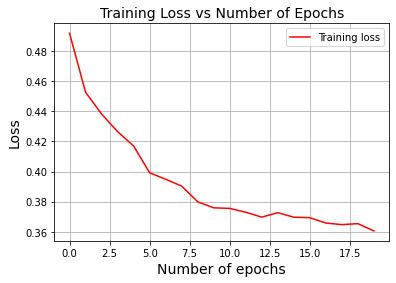

In [17]:
# One hot encoding for class labels (full training data)
y_one_hot = np.zeros((10, M + Mval))
y_one_hot[y, np.array(list(range(M+Mval)))] = 1

learned_parameters, epoch_cost = NN_best_fit(X, y_one_hot,
                            learning_rate=LEARNING_RATE,
                            activation_f = ACTIVATION,
                            init_mode = INITIALIZER,
                            optimizer = OPTIMIZER,
                            batch_size = BATCH_SIZE,
                            loss = LOSS,
                            epochs = EPOCHS,
                            L2_lamb = L2_lambda,
                            num_neurons = NUM_NEURONS,
                            num_hidden = NUM_HIDDEN)

#### Model Evaluation with X_test dataset

In [18]:
train_predictions, test_predictions = NN_evaluate(X, y, X_test, y_test, learned_parameters, ACTIVATION)

Training accuracy = 89.43 %
Test accuracy = 86.71 %
Classification report for the test set:

              precision    recall  f1-score   support

           0       0.83      0.82      0.83      1000
           1       0.98      0.96      0.97      1000
           2       0.80      0.73      0.76      1000
           3       0.83      0.91      0.87      1000
           4       0.73      0.83      0.78      1000
           5       0.97      0.92      0.94      1000
           6       0.72      0.61      0.66      1000
           7       0.89      0.97      0.93      1000
           8       0.96      0.97      0.96      1000
           9       0.96      0.94      0.95      1000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



#### Confusion Matrix (Training set)

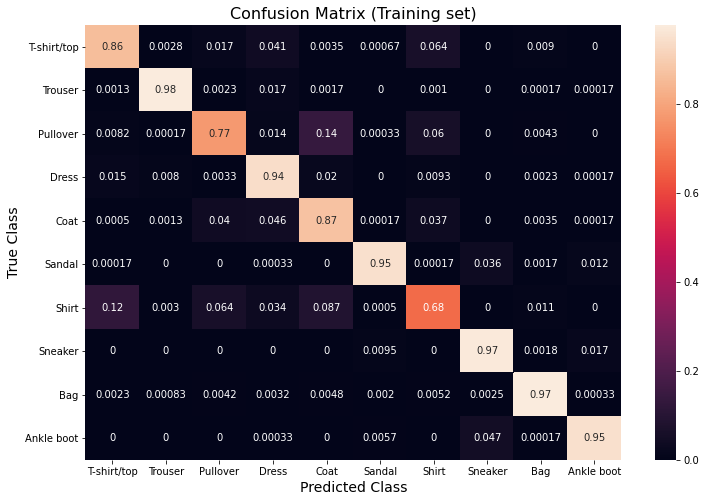

In [19]:
bern_cnf_matrix_train = confusion_matrix(y, train_predictions, normalize='true')
plt.figure(figsize=(12, 8))
ax = sns.heatmap(bern_cnf_matrix_train, annot=bern_cnf_matrix_train,xticklabels=class_names, yticklabels=class_names)
ax.set_title("Confusion Matrix (Training set)", size=16)
ax.set_xlabel("Predicted Class", size=14)
ax.set_ylabel("True Class", size=14)
plt.savefig("trainmatrix")
plt.show()

#### Confusion Matrix (Test set)

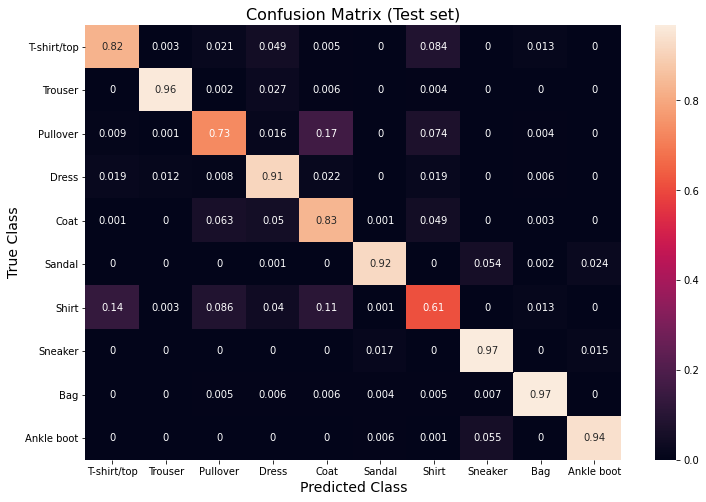

In [20]:
bern_cnf_matrix_test = confusion_matrix(y_test, test_predictions, normalize='true')
plt.figure(figsize=(12, 8))
ax = sns.heatmap(bern_cnf_matrix_test, annot=bern_cnf_matrix_test,xticklabels=class_names, yticklabels=class_names)
ax.set_title("Confusion Matrix (Test set)", size=16)
ax.set_xlabel("Predicted Class", size=14)
ax.set_ylabel("True Class", size=14)
plt.savefig("testmatrix")
plt.show()